# Recommendation algorithms

Based on the paper "Recommendation Fairness in eParticipation: Listening to a Minority, Vulnerable and NIMBY Citizens" by [Marina Alonso-Cortés, Iván Cantador and Alejandro Bellogín], we will implement the recommendation algorithms used in the paper, following their code but adapting it to the datasets we have: Cambridge, Miami and New York City datasets for years 2014, 2015, 2016 and 2017.

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import warnings
warnings.simplefilter('ignore')
import scipy.sparse as sps
# DB connection and path modification
import sys
import os
import matplotlib.pyplot as plt


#implicit
from implicit.evaluation import train_test_split
from implicit.cpu.lmf import LogisticMatrixFactorization
from implicit.cpu.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import CosineRecommender

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    python_path = os.path.join(module_path, 'python')
    sys.path.append(python_path)

# Recommenders
from implicit_extend.popularity import PopularityRecommender, PopularityNumCommentsRecommender
from implicit_extend.random import RandomRecommender
from implicit_extend.nearest_neighbours_ub import CosineRecommenderUB
from implicit_extend.content_based import ContentBasedRecommender
from implicit_extend.evaluation import ranking_metrics_at_k
from implicit_extend.hybrid import HybridRecommenderUB, HybridRecommenderIB
# Auxiliary functions
from dusa_function_lib import get_rm_train_test_info, build_db_name
from dusa_function_lib import build_directory_city_name
from dusa_function_lib import tunning_and_metrics
from dusa_function_lib import gen_recommendations
from dusa_function_lib import get_n_for_ndcg
from dusa_function_lib import get_item_category_info, get_item_location_info


# Data charge

We need to create a structure that will store the different datasets. We will define a dictionary with the following structure:
- `key`: db_name
- `values`: dictionary with three keys:
    - `rm_info`: it will store another dictionary with the following keys:
        - `rm`: it will store the sparse matrix of the whole dataset.
        - `user_mapping`: it will store the mapping between the userId and its index in the matrix.
        - `item_mapping`: it will store the mapping between the itemId and its index in the matrix.
    - `rm_train`: it will store the sparse matrix of the training set.
    - `rm_test`: it will store the sparse matrix of the test set.

In [ ]:
all_data = dict()
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']
for city in cities:
    for year in years:
        db_name = build_db_name(city, year)
        all_data[db_name] = dict()
        rm_info, rm_train, rm_test = get_rm_train_test_info(city, year)
        all_data[db_name]['rm_info'] = rm_info
        all_data[db_name]['rm_train'] = rm_train
        all_data[db_name]['rm_test'] = rm_test
        
it_cat_data = dict()

for city in cities:
    for year in years:
        db_name = build_db_name(city, year)
        it_cat_data[db_name] = dict()
        it_cat_info = get_item_category_info(city, year)
        it_cat_data[db_name]['it_cat_info'] = it_cat_info

# Recommendation algorithms
We will implement the following recommendation algorithms:

In [ ]:
MODEL_ORDER = {"rand":2, "pop": 0, "pop_nc":1,
               "ib": 3, "ub":4, "mf": 5, "bpr": 6,
               "cb_cat": 7, "cb_loc": 8,
               "cbub_cat":9, "cbub_loc":10,
               "cbib_cat":11, "cbib_loc":12}

Before we start with the recommendation algorithms, we need to take into account that the recommendation algorithms will be evaluated using the `NDCG@N` metric: Normalized Discounted Cumulative Gain at N. It is a ranking evaluation metric commonly used in recommendation systems and information retrieval. It measures the quality of recommendations by considering both the relevance of items and their ranking positions in the recommendation list. 
##### How is it calculated?
`NDCG@N` is based on Discounted Cumulative Gain at N (`DCG@N`), which assigns higher importance to relevant items appearing at the top of the ranking. The formula is
$$
\text{DCG@N} = \sum_{i=1}^{N} \frac{rel_i}{\log_2(i+1)}
$$
where:
   - $rel_i$ is the relevance of the item at position $i$ in the ranking.
   - $\log_2(i+1)$ penalizes lower-ranked relevant items.
   - $N$ represents the number of top-ranked items considered when calculating the metric.

After calculating `DCG@N`, we need to normalize it by the Ideal Discounted Cumulative Gain at N (`IDCG@N`). It is the maximum possible `DCG@N`, obtained when all relevant items are ranked at the top of the list. The final formula for `NDCG@N` is:
$$
\text{NDCG@N} = \frac{\text{DCG@N}}{\text{IDCG@N}}
$$


As we have seen, not all the Datasets have the same number of proposals. Therefore, we will need to adapt the `N` parameter to the number of proposals in each dataset. We will define the following rules in order to adapt the `N` parameter:
- Firstly, we will calculate the 15% of the number of proposals in the dataset. $N=round(0.15*|P|)$, where $|P|$ is the number of proposals in the dataset.
- If $N<30$, we will set $N=30$.
- If $N>100$, we will set $N=100$.

This function will be defined as `get_n_for_ndcg(min_n, max_n, n_proposals, percentage)` in `dusa_function_lib.py`.

In [26]:
# We define the cuttoff for the Hyperparameter Search (N=100), for the final rankings and metrics (Nf=50)
# and the number of Cross Validation Folds cvk=5
cities = ['Cambridge']
years = ['2014']
N=100
Nf=50
cvk=5

In [27]:
# we define the N for the different cities and years
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']
n_ndcg_dict = dict()
nf_ndcg_dict = dict()
for city in cities:
    n_ndcg_dict[city] = dict()
    nf_ndcg_dict[city] = dict()
    for year in years:
        db_name = build_db_name(city, year)
        number_of_proposals = all_data[db_name]['rm_info']['rm'].shape[1]
        n_ndcg = get_n_for_ndcg(30, 100, number_of_proposals, 0.15)
        nf_ndcg = get_n_for_ndcg(30, 100, number_of_proposals, 0.20)
        n_ndcg_dict[city][year] = n_ndcg
        nf_ndcg_dict[city][year] = nf_ndcg
        
print(n_ndcg_dict)
print(nf_ndcg_dict)



{'Cambridge': {'2014': 52, '2015': 38, '2016': 57, '2017': 82}, 'Miami': {'2014': 44, '2015': 38, '2016': 49, '2017': 49}, 'New York': {'2014': 60, '2015': 81, '2016': 96, '2017': 100}}
{'Cambridge': {'2014': 70, '2015': 50, '2016': 76, '2017': 100}, 'Miami': {'2014': 59, '2015': 50, '2016': 66, '2017': 65}, 'New York': {'2014': 81, '2015': 100, '2016': 100, '2017': 100}}


## Popularity Recommender
A popularity recommender is simple, yet effective algorithm used in recommender systems that suggests items based solely on their popularity across all users, without considering the personal preferences of individual users. The core idea is that popular items, by virtue of their high interaction levels, have a higher likelihood of satisfying a broader audience.

In this implementation, item popularity is defined as the total number of unique users who have interacted with the item, Thus, each user receives recommendations consisting of the top-K most popular items they have not yet seen or interacted with. 

Mathematically, for a given item $i$, its popularity $p_i$ is calculated as:
$$
p_i = |\{ u \in U \mid r_{u,i} > 0 \}|
$$

Where:
- $U$ is the set of all users.
- $r_{u,i}$ represents the interaction of user $u$ with item $i$.

Recommendations are generated by recommending the top N items with the highest popularity scores.

In [ ]:
cv_metrics_results = {}
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']

for city in cities:
    cv_metrics_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        model = {"pop": {'m': PopularityRecommender, 'params': {}}}
        
        metric_results_pop, _, _, final_metrics_users_pop = \
            tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=n_ndcg_dict[city][year], model=model)
        cv_metrics_results[city][year] = metric_results_pop
        
        print(f"City: {city}, Year: {year}")
        print(metric_results_pop)
        


In [29]:
final_metrics_pop_results = {}
for city in cities:
    final_metrics_pop_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        m = PopularityRecommender()
        m.fit(rm_train)
        
        final_metrics_pop = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=nf_ndcg_dict[city][year]).mean().to_dict(),
            index=['pop']
        )
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_pop.to_csv(f"../../data/final_metrics/{city_year_directory_name}/pop_final_metrics.csv", sep="|")
        
        final_metrics_pop_results[city][year] = final_metrics_pop
        print(f"City: {city}, Year: {year}")
        print(final_metrics_pop)


IntProgress(value=0, max=319)

PopularityRecommender
City: Cambridge, Year: 2014
     precision    recall       map   ndcg@70       auc       mrr        f1
pop   0.018719  0.699946  0.183095  0.306515  0.102985  0.211307  0.035052


IntProgress(value=0, max=200)

PopularityRecommender
City: Cambridge, Year: 2015
     precision    recall      map   ndcg@50       auc      mrr        f1
pop     0.0187  0.559599  0.14449  0.244665  0.078654  0.16502  0.035502


IntProgress(value=0, max=290)

PopularityRecommender
City: Cambridge, Year: 2016
     precision    recall       map   ndcg@76       auc       mrr        f1
pop   0.013385  0.629884  0.106028  0.221659  0.088849  0.128705  0.025477


IntProgress(value=0, max=568)

PopularityRecommender
City: Cambridge, Year: 2017
     precision    recall       map  ndcg@100      auc       mrr       f1
pop    0.01331  0.626504  0.108418  0.225571  0.07956  0.128312  0.02533


IntProgress(value=0, max=1060)

PopularityRecommender
City: Miami, Year: 2014
     precision    recall       map  ndcg@59       auc       mrr        f1
pop   0.014503  0.741633  0.151137  0.27393  0.107289  0.153647  0.028279


IntProgress(value=0, max=1535)

PopularityRecommender
City: Miami, Year: 2015
     precision    recall       map   ndcg@50       auc       mrr        f1
pop   0.017537  0.854571  0.194652  0.332379  0.125211  0.195712  0.034337


IntProgress(value=0, max=1595)

PopularityRecommender
City: Miami, Year: 2016
     precision    recall       map   ndcg@66       auc       mrr        f1
pop   0.013347  0.842753  0.235274  0.359973  0.130775  0.236978  0.026218


IntProgress(value=0, max=1464)

PopularityRecommender
City: Miami, Year: 2017
     precision    recall       map   ndcg@65       auc       mrr        f1
pop   0.013714  0.842848  0.192059  0.325138  0.126365  0.192479  0.026919


IntProgress(value=0, max=462)

PopularityRecommender
City: New York, Year: 2014
     precision    recall       map   ndcg@81       auc       mrr        f1
pop   0.011304  0.847818  0.263381  0.388019  0.144519  0.264728  0.022261


IntProgress(value=0, max=544)

PopularityRecommender
City: New York, Year: 2015
     precision    recall       map  ndcg@100      auc       mrr        f1
pop   0.008989  0.805359  0.221933  0.351223  0.13325  0.222822  0.017649


IntProgress(value=0, max=608)

PopularityRecommender
City: New York, Year: 2016
     precision    recall       map  ndcg@100       auc       mrr       f1
pop   0.007599  0.689885  0.171089  0.275265  0.084759  0.173526  0.01501


IntProgress(value=0, max=776)

PopularityRecommender
City: New York, Year: 2017
     precision    recall       map  ndcg@100      auc       mrr        f1
pop    0.00741  0.662118  0.238227  0.326117  0.05475  0.240834  0.014601


In [ ]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        
        recs_pop = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='pop',
            model=PopularityRecommender,
            city=city,
            year=year,
            N=nf_ndcg_dict[city][year],
            save=True
        )
        
        print(f"Recomendations saved for {city}-{year}")

Recomendations saved for Cambridge-2014
Recomendations saved for Cambridge-2015
Recomendations saved for Cambridge-2016
Recomendations saved for Cambridge-2017
Recomendations saved for Miami-2014
Recomendations saved for Miami-2015
Recomendations saved for Miami-2016


## Popularity Num Comments Recommender
This algorithm is a variant of Popularity Recommender. Unlike the standard Popularity Recommender, which ranks items by the count of unique users interacting with them, the Popularity Num Comments Recommender ranks items by the cumulative number of interactions they have attracted.

In this case, the popularity score $p_i$ for an item $i$ is calculated as the sum of all interactions from user:
$$
p_i = \sum_{u \in U} r_{u,i}$$

Where:
- $U$ is the set of all users.
- $r_{u,i}$ represents the number of interactions of user $u$ with item $i$.

In [ ]:
cv_metrics_results = {}
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']

for city in cities:
    cv_metrics_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        model = {"pop_nc": {'m': PopularityNumCommentsRecommender, 'params': {}}}
        
        metric_results_popnc, _, _, _ = \
            tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=n_ndcg_dict[city][year], model=model)
        cv_metrics_results[city][year] = metric_results_popnc
        
        print(f"City: {city}, Year: {year}")
        print(metric_results_popnc)

IntProgress(value=0, max=319)

PopularityNumCommentsRecommender
City: Cambridge, Year: 2014
        precision    recall       map  ndcg@52       auc       mrr        f1
pop_nc   0.022185  0.641986  0.181524   0.2945  0.068794  0.210606  0.040947


IntProgress(value=0, max=200)

PopularityNumCommentsRecommender
City: Cambridge, Year: 2015
        precision    recall       map  ndcg@38       auc       mrr        f1
pop_nc   0.021579  0.504454  0.142464  0.23265  0.053464  0.164348  0.040424


IntProgress(value=0, max=290)

PopularityNumCommentsRecommender
City: Cambridge, Year: 2016
        precision    recall       map   ndcg@57       auc      mrr        f1
pop_nc   0.016031  0.585988  0.102761  0.211035  0.058332  0.12562  0.030408


IntProgress(value=0, max=568)

PopularityNumCommentsRecommender
City: Cambridge, Year: 2017
        precision    recall       map   ndcg@82       auc       mrr        f1
pop_nc   0.015051  0.587996  0.107617  0.218254  0.059927  0.127958  0.028391


IntProgress(value=0, max=1060)

PopularityNumCommentsRecommender
City: Miami, Year: 2014
        precision   recall       map   ndcg@44       auc       mrr        f1
pop_nc   0.016895  0.66351  0.149232  0.259138  0.071548  0.152184  0.032739


IntProgress(value=0, max=1535)

PopularityNumCommentsRecommender
City: Miami, Year: 2015
        precision    recall       map   ndcg@38       auc       mrr        f1
pop_nc   0.021396  0.794962  0.193232  0.321359  0.085697  0.194378  0.041623


IntProgress(value=0, max=1595)

PopularityNumCommentsRecommender
City: Miami, Year: 2016
        precision   recall       map   ndcg@49      auc      mrr        f1
pop_nc   0.016762  0.79149  0.234413  0.351101  0.08852  0.23608  0.032768


IntProgress(value=0, max=1464)

PopularityNumCommentsRecommender
City: Miami, Year: 2017
        precision    recall       map   ndcg@49       auc      mrr        f1
pop_nc   0.017007  0.790226  0.191095  0.315999  0.086351  0.19157  0.033203


IntProgress(value=0, max=462)

PopularityNumCommentsRecommender
City: New York, Year: 2014
        precision    recall       map  ndcg@60       auc       mrr        f1
pop_nc    0.01461  0.816759  0.262926  0.38278  0.101069  0.264259  0.028643


IntProgress(value=0, max=544)

PopularityNumCommentsRecommender
City: New York, Year: 2015
        precision    recall       map   ndcg@81       auc      mrr        f1
pop_nc   0.010893  0.795157  0.221866  0.349586  0.105262  0.22279  0.021307


IntProgress(value=0, max=608)

PopularityNumCommentsRecommender
City: New York, Year: 2016
        precision    recall       map   ndcg@96       auc       mrr        f1
pop_nc   0.007881  0.689008  0.171091  0.275088  0.080525  0.173504  0.015562


IntProgress(value=0, max=776)

PopularityNumCommentsRecommender
City: New York, Year: 2017
        precision    recall       map  ndcg@100      auc       mrr        f1
pop_nc    0.00741  0.662118  0.238227  0.326117  0.05475  0.240834  0.014601


In [ ]:
final_metrics_popnc_results = {}
for city in cities:
    final_metrics_popnc_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        m = PopularityNumCommentsRecommender()
        m.fit(rm_train)
        
        final_metrics_pop = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=nf_ndcg_dict[city][year]).mean().to_dict(),
            index=['pop_nc']
        )
        
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_pop.to_csv(f"../../data/final_metrics/{city_year_directory_name}/pop_nc_final_metrics.csv", sep="|")
        final_metrics_popnc_results[city][year] = final_metrics_pop
        
        print(f"City: {city}, Year: {year}")
        print(final_metrics_pop)


IntProgress(value=0, max=319)

PopularityNumCommentsRecommender
City: Cambridge, Year: 2014
        precision    recall       map   ndcg@70       auc       mrr        f1
pop_nc   0.017376  0.684417  0.214155  0.324618  0.103671  0.233775  0.032687


IntProgress(value=0, max=200)

PopularityNumCommentsRecommender
City: Cambridge, Year: 2015
        precision   recall      map   ndcg@50       auc       mrr        f1
pop_nc      0.019  0.59119  0.14055  0.246232  0.080805  0.160395  0.036162


IntProgress(value=0, max=290)

PopularityNumCommentsRecommender
City: Cambridge, Year: 2016
        precision    recall       map   ndcg@76       auc       mrr        f1
pop_nc   0.012613  0.627957  0.099552  0.212882  0.088239  0.111565  0.024162


IntProgress(value=0, max=568)

PopularityNumCommentsRecommender
City: Cambridge, Year: 2017
        precision    recall       map  ndcg@100       auc       mrr        f1
pop_nc   0.011831  0.606795  0.104119  0.215299  0.077305  0.119657  0.022643


IntProgress(value=0, max=1060)

PopularityNumCommentsRecommender
City: Miami, Year: 2014
        precision    recall       map   ndcg@59       auc       mrr        f1
pop_nc   0.013591  0.755793  0.151182  0.274802  0.109333  0.154214  0.026637


IntProgress(value=0, max=1535)

PopularityNumCommentsRecommender
City: Miami, Year: 2015
        precision    recall       map   ndcg@50       auc       mrr        f1
pop_nc   0.017511  0.853431  0.194473  0.331971  0.124987  0.195527  0.034286


IntProgress(value=0, max=1595)

PopularityNumCommentsRecommender
City: Miami, Year: 2016
        precision    recall       map   ndcg@66       auc       mrr      f1
pop_nc   0.013337  0.844509  0.234914  0.359855  0.130991  0.236694  0.0262


IntProgress(value=0, max=1464)

PopularityNumCommentsRecommender
City: Miami, Year: 2017
        precision    recall       map   ndcg@65       auc       mrr        f1
pop_nc   0.013798  0.850481  0.191696  0.325843  0.126088  0.192392  0.027092


IntProgress(value=0, max=462)

PopularityNumCommentsRecommender
City: New York, Year: 2014
        precision    recall       map   ndcg@81       auc       mrr        f1
pop_nc    0.01125  0.844151  0.256448  0.383133  0.144874  0.258558  0.022161


IntProgress(value=0, max=544)

PopularityNumCommentsRecommender
City: New York, Year: 2015
        precision    recall       map  ndcg@100       auc      mrr        f1
pop_nc   0.008787  0.813004  0.221997  0.351986  0.134053  0.22289  0.017312


IntProgress(value=0, max=608)

PopularityNumCommentsRecommender
City: New York, Year: 2016
        precision    recall       map  ndcg@100       auc       mrr       f1
pop_nc   0.007401  0.689474  0.170648  0.274336  0.085284  0.173274  0.01463


IntProgress(value=0, max=776)

PopularityNumCommentsRecommender
City: New York, Year: 2017
        precision    recall       map  ndcg@100      auc       mrr        f1
pop_nc   0.007281  0.667517  0.238733  0.327197  0.05527  0.241313  0.014361


In [ ]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        
        recs_pop = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='pop_nc',
            model=PopularityNumCommentsRecommender,
            city=city,
            year=year,
            N=nf_ndcg_dict[city][year],
            save=True
        )
        
        print(f"Recomendations saved for {city}-{year}")

Recomendations saved for Cambridge-2014
Recomendations saved for Cambridge-2015
Recomendations saved for Cambridge-2016
Recomendations saved for Cambridge-2017
Recomendations saved for Miami-2014
Recomendations saved for Miami-2015
Recomendations saved for Miami-2016
Recomendations saved for Miami-2017
Recomendations saved for New York-2014
Recomendations saved for New York-2015
Recomendations saved for New York-2016
Recomendations saved for New York-2017


## Random Recommender
The Random Recommender generates recommendations by randomly selecting items from the pool of items that a user has not yet interacted with. 

Mathematically, given a user $u$ and given $I$ the total set of items, and let $I_u$ represent the set of items that a user has already interacted with. Then, the set of items to recommend $R_u$ is defined as:
$$
R_u = random_sample(I \setminus I_u, N)
$$

Where:
- $N$ is the number of items to recommend.

In [ ]:
cv_metrics_results = {}
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']

for city in cities:
    cv_metrics_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        model = {"rand": {'m': RandomRecommender, 'params': {}}}
        
        metric_results_random, _, _, _ = \
            tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=n_ndcg_dict[city][year], model=model)
        cv_metrics_results[city][year] = metric_results_random
        
        print(f"City: {city}, Year: {year}")
        print(metric_results_random)

IntProgress(value=0, max=319)

RandomRecommender
City: Cambridge, Year: 2014
      precision    recall       map   ndcg@52       auc       mrr        f1
rand   0.005968  0.126984  0.013184  0.039957  0.009708  0.020992  0.010438


IntProgress(value=0, max=200)

RandomRecommender
City: Cambridge, Year: 2015
      precision    recall       map   ndcg@38       auc       mrr        f1
rand   0.005921  0.097492  0.017673  0.040666  0.007548  0.039364  0.010847


IntProgress(value=0, max=290)

RandomRecommender
City: Cambridge, Year: 2016
      precision    recall       map  ndcg@57       auc      mrr        f1
rand   0.005263  0.183064  0.010772  0.04564  0.012597  0.01799  0.009587


IntProgress(value=0, max=568)

RandomRecommender
City: Cambridge, Year: 2017
      precision    recall       map   ndcg@82       auc       mrr        f1
rand   0.004358  0.157144  0.012113  0.044205  0.012794  0.021765  0.008107


IntProgress(value=0, max=1060)

RandomRecommender
City: Miami, Year: 2014
      precision    recall       map   ndcg@44       auc       mrr        f1
rand   0.004009  0.149243  0.014445  0.041433  0.010971  0.018226  0.007725


IntProgress(value=0, max=1535)

RandomRecommender
City: Miami, Year: 2015
      precision    recall       map   ndcg@38       auc       mrr        f1
rand   0.003806  0.138187  0.017331  0.041023  0.010575  0.018156  0.007392


IntProgress(value=0, max=1595)

RandomRecommender
City: Miami, Year: 2016
      precision    recall       map   ndcg@49       auc       mrr        f1
rand    0.00316  0.138674  0.011321  0.035592  0.009942  0.012522  0.006136


IntProgress(value=0, max=1464)

RandomRecommender
City: Miami, Year: 2017
      precision    recall       map   ndcg@49       auc       mrr        f1
rand    0.00336  0.151803  0.014602  0.040775  0.011394  0.016413  0.006538


IntProgress(value=0, max=462)

RandomRecommender
City: New York, Year: 2014
      precision   recall       map   ndcg@60       auc       mrr        f1
rand   0.003102  0.15537  0.014087  0.041069  0.012238  0.015236  0.006031


IntProgress(value=0, max=544)

RandomRecommender
City: New York, Year: 2015
      precision    recall       map   ndcg@81       auc       mrr       f1
rand   0.002678  0.152912  0.007613  0.034407  0.010985  0.009598  0.00513


IntProgress(value=0, max=608)

RandomRecommender
City: New York, Year: 2016
      precision  recall       map   ndcg@96       auc       mrr        f1
rand    0.00185  0.1402  0.007935  0.031983  0.011308  0.009424  0.003637


IntProgress(value=0, max=776)

RandomRecommender
City: New York, Year: 2017
      precision    recall       map  ndcg@100       auc       mrr        f1
rand    0.00125  0.090076  0.004916   0.02074  0.004664  0.006671  0.002436


In [ ]:
final_metrics_rand_results = {}
for city in cities:
    final_metrics_rand_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        m = RandomRecommender()
        m.fit(rm_train)
        
        final_metrics_rand = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=nf_ndcg_dict[city][year]).mean().to_dict(),
            index=['rand']
        )
        
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_rand.to_csv(f"../../data/final_metrics/{city_year_directory_name}/rand_final_metrics.csv", sep="|")
        final_metrics_rand_results[city][year] = final_metrics_rand
        
        print(f"City: {city}, Year: {year}")
        print(final_metrics_rand)


IntProgress(value=0, max=319)

RandomRecommender
City: Cambridge, Year: 2014
      precision    recall       map   ndcg@70       auc       mrr        f1
rand   0.005643  0.169038  0.009554  0.044488  0.016556  0.018559  0.010281


IntProgress(value=0, max=200)

RandomRecommender
City: Cambridge, Year: 2015
      precision    recall       map   ndcg@50       auc      mrr        f1
rand     0.0073  0.187942  0.020348  0.058511  0.018512  0.02748  0.013785


IntProgress(value=0, max=290)

RandomRecommender
City: Cambridge, Year: 2016
      precision    recall       map   ndcg@76      auc       mrr        f1
rand    0.00422  0.199636  0.013489  0.052041  0.02373  0.024502  0.008013


IntProgress(value=0, max=568)

RandomRecommender
City: Cambridge, Year: 2017
      precision    recall       map  ndcg@100     auc       mrr        f1
rand   0.004472  0.190457  0.012283  0.050292  0.0174  0.023175  0.008479


IntProgress(value=0, max=1060)

RandomRecommender
City: Miami, Year: 2014
      precision    recall      map   ndcg@59       auc       mrr        f1
rand   0.004829  0.240458  0.01737  0.059767  0.024228  0.019989  0.009406


IntProgress(value=0, max=1535)

RandomRecommender
City: Miami, Year: 2015
      precision   recall       map   ndcg@50       auc       mrr        f1
rand   0.004143  0.20051  0.016911  0.051091  0.019661  0.017175  0.008111


IntProgress(value=0, max=1595)

RandomRecommender
City: Miami, Year: 2016
      precision    recall       map   ndcg@66       auc       mrr        f1
rand   0.003334  0.199876  0.017009  0.050658  0.020692  0.018457  0.006528


IntProgress(value=0, max=1464)

RandomRecommender
City: Miami, Year: 2017
      precision    recall      map  ndcg@65      auc       mrr        f1
rand   0.003352  0.200044  0.01392  0.04754  0.01886  0.014735  0.006567


IntProgress(value=0, max=462)

RandomRecommender
City: New York, Year: 2014
      precision   recall       map   ndcg@81       auc       mrr        f1
rand   0.003073  0.20435  0.018787  0.053139  0.022046  0.020847  0.006013


IntProgress(value=0, max=544)

RandomRecommender
City: New York, Year: 2015
      precision    recall       map  ndcg@100       auc       mrr        f1
rand   0.002335  0.179356  0.011628  0.041166  0.016817  0.013609  0.004528


IntProgress(value=0, max=608)

RandomRecommender
City: New York, Year: 2016
      precision    recall       map  ndcg@100       auc       mrr        f1
rand   0.001891  0.157552  0.007616  0.034022  0.012233  0.009632  0.003724


IntProgress(value=0, max=776)

RandomRecommender
City: New York, Year: 2017
      precision    recall       map  ndcg@100       auc       mrr        f1
rand   0.001198  0.084704  0.005512  0.019668  0.003991  0.006279  0.002333


In [ ]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        
        recs_pop = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='rand',
            model=RandomRecommender,
            city=city,
            year=year,
            N=nf_ndcg_dict[city][year],
            save=True
        )
        
        print(f"Recomendations saved for {city}-{year}")

Recomendations saved for Cambridge-2014
Recomendations saved for Cambridge-2015
Recomendations saved for Cambridge-2016
Recomendations saved for Cambridge-2017
Recomendations saved for Miami-2014
Recomendations saved for Miami-2015
Recomendations saved for Miami-2016
Recomendations saved for Miami-2017
Recomendations saved for New York-2014
Recomendations saved for New York-2015
Recomendations saved for New York-2016
Recomendations saved for New York-2017


## Logistic Matrix Factorization for K factors
LogisticMatrixFactorization has a hyperparameter `factors` that defines the number of factors to use in the factorization. We optimize the number of factors `k` through hyperparameter tuning and evaluate the best model for each dataset based on the NDCG@N metric.

For each city and year, we will define the Logistic Matrix Factorization model with different values of `k` (ranging from `5`to `40` with a step of `5`). We will perform hyperparameter tuning using cross-validation and store the validation results.

In [ ]:
mf_metrics_results = {}
mf_train_results = {}
mf_test_results = {}
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']
for city in cities:
    mf_metrics_results[city] = {}
    mf_train_results[city] = {}
    mf_test_results[city] = {}
    for year in years:
        print(f"START OF City: {city}, Year: {year}")
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        model = {"mf": {'m':LogisticMatrixFactorization, 'params':{'factors': [i for i in range(5, 41, 5)]}}}
        
        metric_results_mf, train_results_mf, test_results_mf, _ = \
            tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=n_ndcg_dict[city][year], model=model, check_overfitting=True)
        mf_metrics_results[city][year] = metric_results_mf
        mf_train_results[city][year] = train_results_mf
        mf_test_results[city][year] = test_results_mf
        
        
        

The second step consists of extracting the best value of `k` based on the highest NDCG@N value obtained during the hyperparameter tuning process. We display the best value of `k` and the corresponding NDCG@N value for each city and year.

In [ ]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        print(mf_metrics_results[city][year])
        # I need to take the best hyperparameter
        best_hyperparameter = int(mf_metrics_results[city][year].index[0][2:])
        print(f"Best hyperparameter: {best_hyperparameter} ")
        

City: Cambridge, Year: 2014
     precision    recall       map   ndcg@52       auc       mrr        f1
mf5   0.024054  0.685332  0.229938  0.341894  0.075419  0.260492  0.044323
Best hyperparameter: 5 
City: Cambridge, Year: 2015
     precision    recall       map   ndcg@38       auc       mrr        f1
mf5   0.021447  0.505101  0.147987  0.236983  0.053261  0.173023  0.040224
Best hyperparameter: 5 
City: Cambridge, Year: 2016
     precision    recall      map   ndcg@57      auc       mrr        f1
mf5   0.015245  0.559126  0.12929  0.230286  0.05994  0.155144  0.029049
Best hyperparameter: 5 
City: Cambridge, Year: 2017
      precision    recall       map   ndcg@82       auc       mrr        f1
mf10   0.015652  0.612973  0.097032  0.219776  0.065353  0.130771  0.029576
Best hyperparameter: 10 
City: Miami, Year: 2014
      precision    recall       map   ndcg@44       auc       mrr        f1
mf20   0.019533  0.741389  0.158676  0.281962  0.078228  0.165081  0.037755
Best hyperparamet

### Result LogisticMatrixFactorization NDGG@N
- `factors=int(mf_metrics_results[city][year].index[0][2:])`
Now, we train Logistic Matrix Factorization using the best `k`value found in the previous step and evaluate its performance. The final results will be stored in a dictionary.

In [ ]:
final_metrics_mf_results = {}
for city in cities:
    final_metrics_mf_results[city] = {}
    for year in years:
        dataset = build_db_name(city, year)
        best_factor = int(mf_metrics_results[city][year].index[0][2:])
        m = LogisticMatrixFactorization(factors=best_factor)
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        m.fit(rm_train)
        
        final_metrics_mf = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=nf_ndcg_dict[city][year]).mean().to_dict(),
            index=['mf']
        )
        
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_mf.to_csv(f"../../data/final_metrics/{city_year_directory_name}/mf_final_metrics.csv", sep="|")
        final_metrics_mf_results[city][year] = final_metrics_mf

Finally, we generate and save final recommendations based on the train model and save them for future use.

In [ ]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        best_factor = int(mf_metrics_results[city][year].index[0][2:])
        
        recs_pop = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='mf',
            model=LogisticMatrixFactorization,
            city=city,
            year=year,
            N=nf_ndcg_dict[city][year],
            params={'factors':best_factor},
            save=True
        )
        
        print(f"Recomendations saved for {city}-{year}")

  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2014


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2015


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2016


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2017


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for Miami-2014


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for Miami-2015


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for Miami-2016


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for Miami-2017


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for New York-2014


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for New York-2015


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for New York-2016


  0%|          | 0/30 [00:00<?, ?it/s]

Recomendations saved for New York-2017


## Nearest Neighbors Item Based, Cosine Distance
We are going to implement an Item-Based Nearest Neighbors Recommender using Cosine Distance as the similarity measure. The goal is to determine the optimal number of neighbors `k` for each dataset and evaluate the performance of the model based on the NDCG@N metric.

**Cosine Distance** is a metric used to measure the dissimilarity between two vectors. It is derived from Cosine Similarity, which measures the angle between two vectors in an N-dimensional space. The closer the angle is to 0, the more similar the vectors are. 

The Cosine Similarity between two vectors $A$ and $B$ is calculated as:
$$
\text{Cosine Similarity}(\theta) = \frac{A \cdot B}{\|A\|\|B\|}
$$
Where:
- $A \cdot B$ is the dot product of vectors $A$ and $B$.
- $\|A\|$ and $\|B\|$ are the L2 norms of vectors $A$ and $B$ respectively.
Cosine Distance is then computed as:
$$
\text{Cosine Distance} = 1 - \text{Cosine Similarity}(\theta)
$$

- A lower Cosine Distance indicates higher similarity between two vectors.
- A higher Cosine Similarity indicates higher similarity between two vectors.

This metric is commonly used in recommendation systems because it is scale-invariant.

In [ ]:
import numpy as np
import implicit

print("NumPy version:", np.__version__)
print("Implicit version:", implicit.__version__)
ib_metrics_results = {}
ib_train_results = {}
ib_test_results = {}
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']
for city in cities:
    ib_metrics_results[city] = {}
    ib_train_results[city] = {}
    ib_test_results[city] = {}
    for year in years:
        print(f"START OF City: {city}, Year: {year}")
        db_name = build_db_name(city, year)
        # scipy.sparse as sps

        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        print(f"Before conversion: {rm_train.dtype}, {rm_test.dtype}")
        rm_train = sps.csr_matrix(rm_train.astype(np.float32))
        rm_test = sps.csr_matrix(rm_test.astype(np.float32))

        print(f"After conversion: {sps.csr_matrix(rm_train).dtype}, {sps.csr_matrix(rm_test).dtype}")

        
        model={"ib": {'m':CosineRecommender,
               'params':{"K": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]}}}
        
        metric_results_ib, train_results_ib, test_results_ib, _ = \
            tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=n_ndcg_dict[city][year], model=model, check_overfitting=True)
        ib_metrics_results[city][year] = metric_results_ib
        ib_train_results[city][year] = train_results_ib
        ib_test_results[city][year] = test_results_ib

After performing hyperparameter tuning in the previous step, we now analyze the results and select the best `k` number of neighbors for each dataset based on the highest NDCG@N value obtained during the tuning process.

In [ ]:
# ib_metrics_results[city][year] = metric_results_ib
# ib_train_results[city][year] = train_results_ib
# ib_test_results[city][year] = test_results_ib
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        print(ib_metrics_results[city][year])
        # I need to take the best hyperparameter
        best_hyperparameter = int(ib_metrics_results[city][year].index[0][2:])
        print(f"Best hyperparameter: {best_hyperparameter} ")

City: Cambridge, Year: 2014
       precision    recall       map   ndcg@52       auc       mrr        f1
ib100   0.013745  0.254376  0.059263  0.115539  0.024887  0.097564  0.024476
Best hyperparameter: 100 
City: Cambridge, Year: 2015
       precision    recall       map   ndcg@38       auc       mrr        f1
ib100   0.016711  0.302571  0.056195  0.122953  0.027057  0.093275  0.030866
Best hyperparameter: 100 
City: Cambridge, Year: 2016
      precision    recall       map   ndcg@57       auc       mrr        f1
ib50   0.007381  0.228102  0.103117  0.135633  0.020477  0.127056  0.013388
Best hyperparameter: 50 
City: Cambridge, Year: 2017
       precision    recall       map   ndcg@82       auc       mrr        f1
ib100   0.012453  0.340854  0.082013  0.155693  0.035248  0.129766  0.023176
Best hyperparameter: 100 
City: Miami, Year: 2014
      precision    recall      map   ndcg@44       auc       mrr        f1
ib80   0.006132  0.149618  0.07643  0.094442  0.014952  0.083505  0.0115

City: Cambridge, Year: 2014


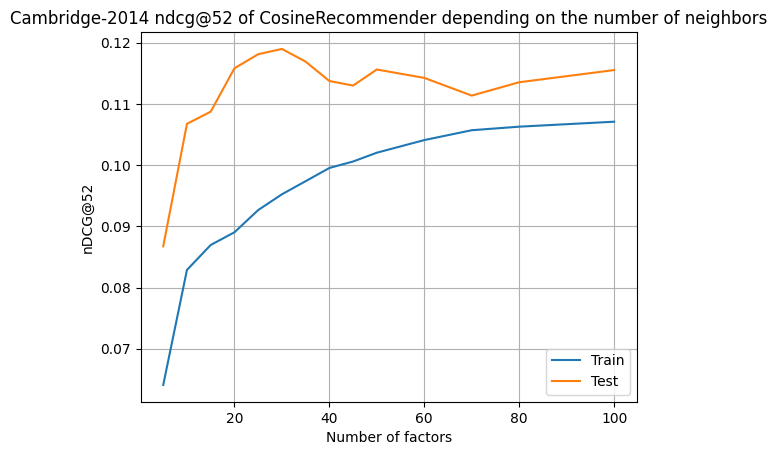

City: Cambridge, Year: 2015


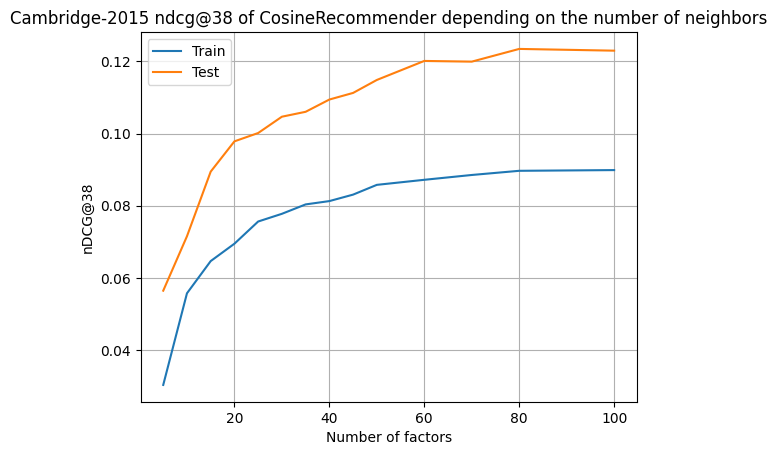

City: Cambridge, Year: 2016


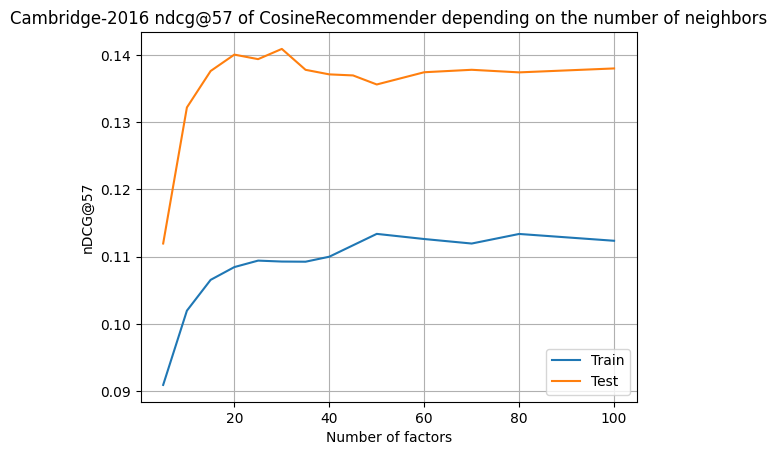

City: Cambridge, Year: 2017


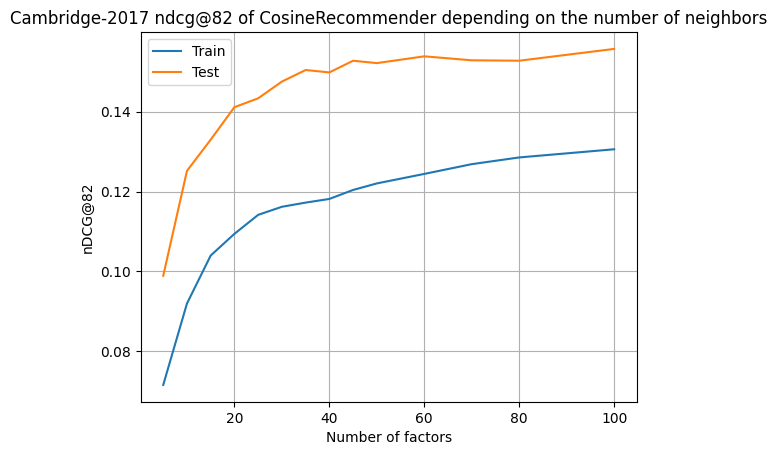

City: Miami, Year: 2014


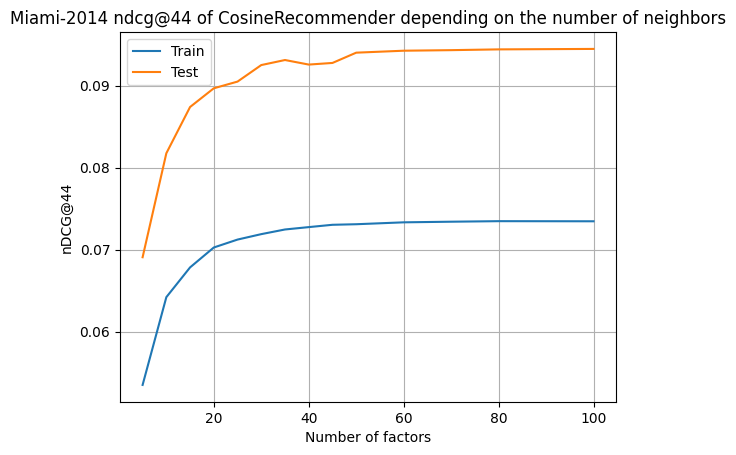

City: Miami, Year: 2015


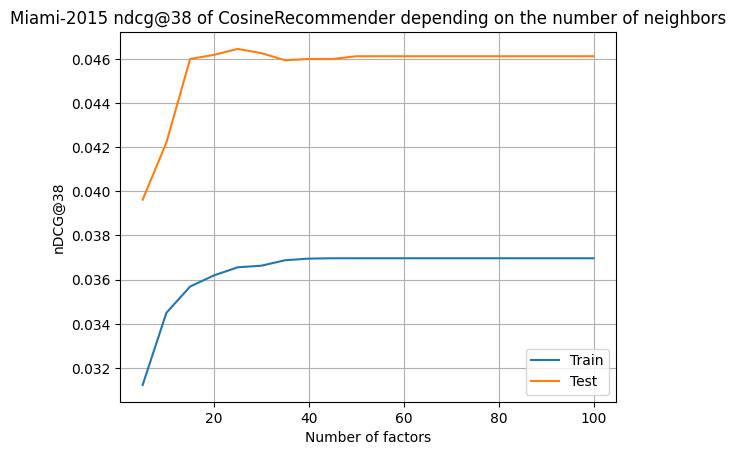

City: Miami, Year: 2016


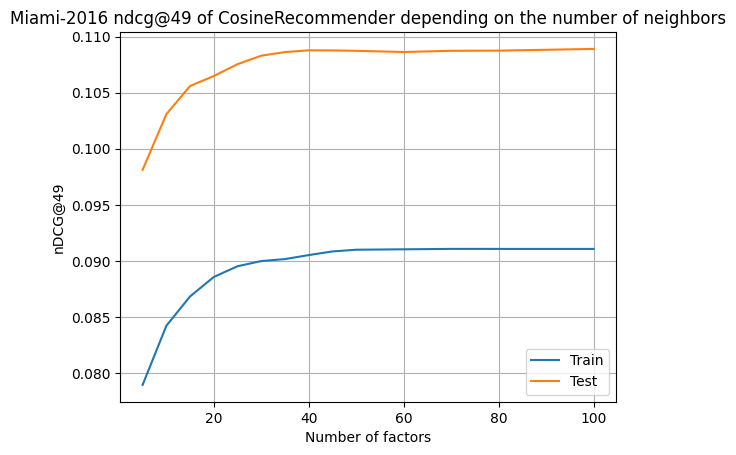

City: Miami, Year: 2017


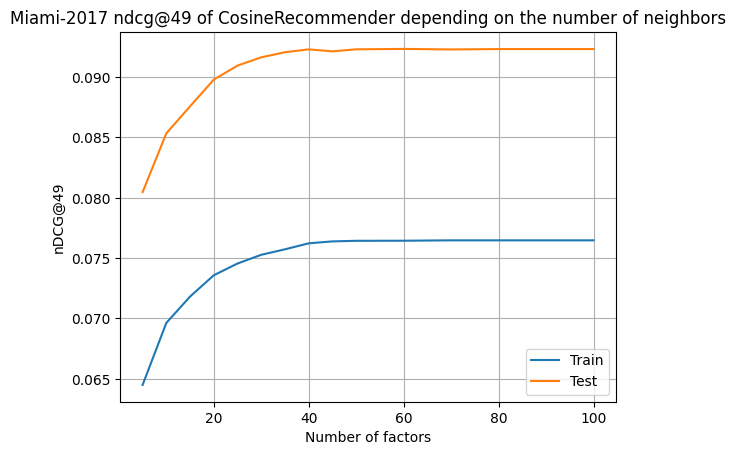

City: New York, Year: 2014


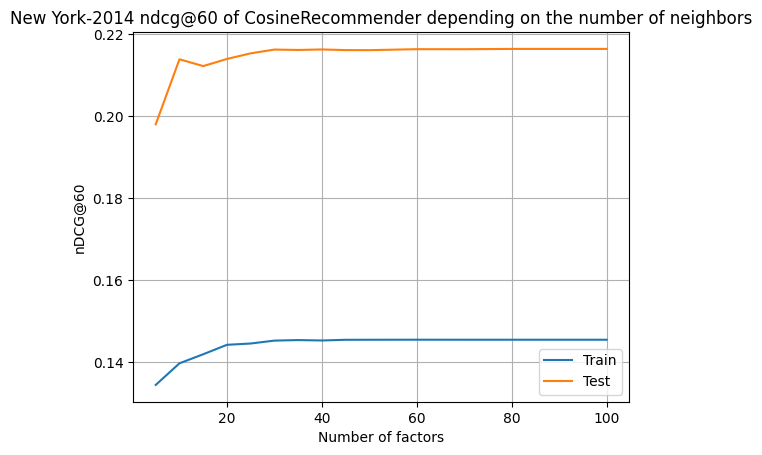

City: New York, Year: 2015


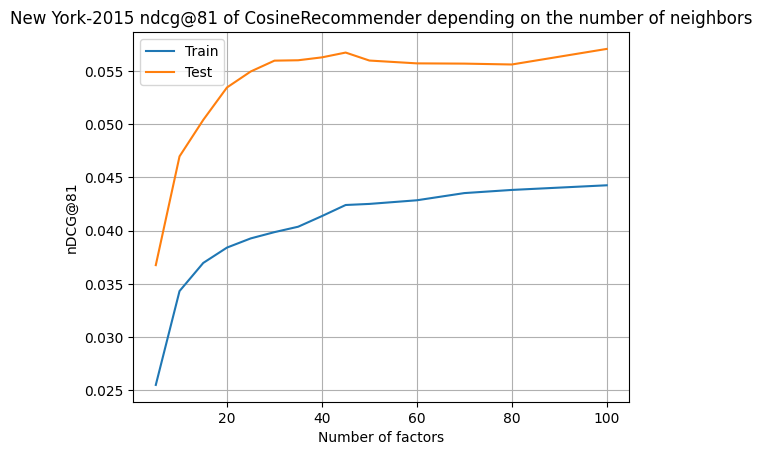

City: New York, Year: 2016


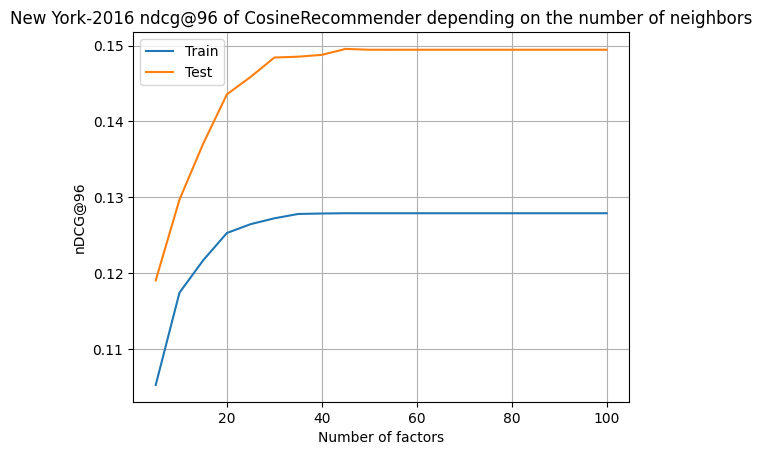

City: New York, Year: 2017


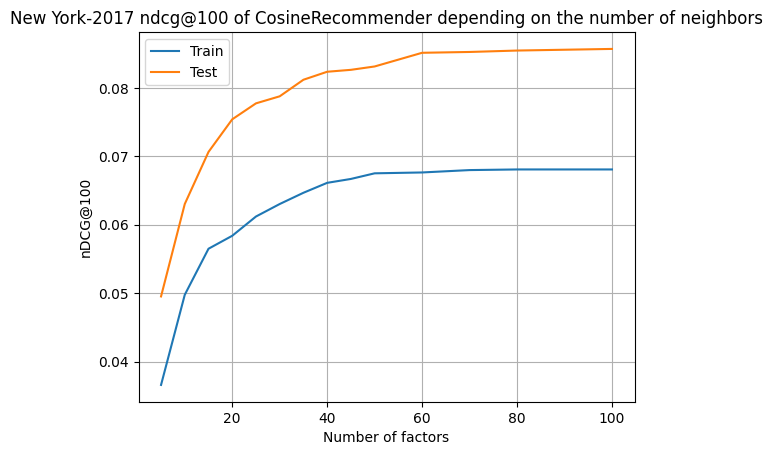

In [ ]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        plt.plot(model["ib"]["params"]["K"], ib_train_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        plt.plot(model["ib"]["params"]["K"], ib_test_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        plt.xlabel("Number of factors")
        plt.ylabel(f"nDCG@{n_ndcg_dict[city][year]}")
        plt.title(f"{city}-{year} ndcg@{n_ndcg_dict[city][year]} of CosineRecommender depending on the number of neighbors")
        plt.grid(True)
        plt.legend(["Train", "Test"])
        plt.show()

### Summary of Optimal Number of Neighbors `k` based on NDCG@N
| City       | Year | Best `K` | Explanation |
|------------|------|---------|-------------|
| **Cambridge** | 2014 | **35** | `Test` stabilizes around K≈35, avoiding overfitting. |
| **Cambridge** | 2015 | **60** | `Test` reaches its peak at K≈60 without further degradation. |
| **Cambridge** | 2016 | **40** | `Test` improves until K≈40 and then stabilizes with no further gains. |
| **Cambridge** | 2017 | **50** | `Test` keeps improving until K≈50 with no signs of overfitting. |
| **Miami**     | 2014 | **40** | `Test` reaches its peak at K≈40, avoiding unnecessary computation. |
| **Miami**     | 2015 | **35** | `Test` reaches its maximum performance at K≈35 and remains stable. |
| **Miami**     | 2016 | **45** | `Test` peaks at K≈45 with no further degradation. |
| **Miami**     | 2017 | **40** | `Test` improves up to K≈40 and remains stable afterward. |
| **New York**  | 2014 | **35** | `Test` stabilizes at K≈35, with no further improvements. |
| **New York**  | 2015 | **45** | `Test` reaches its best performance at K≈45 before stabilizing. |
| **New York**  | 2016 | **45** | `Test` increases up to K≈45, after which no significant improvement is observed. |
| **New York**  | 2017 | **50** | `Test` reaches its best performance at K≈50 with no degradation. |

As we have manually selected the optimal `k`, number of neighbors value, now we have to change the nf values for cosine recommender. The new approach will be:
$$
Nf = min(max(round(1.2*K), 30), 100)
$$

In [ ]:
# Dictionary storing optimal K values for CosineRecommender (Item-Based)
optimal_k_ib_cos_dist_dict = {
    "Cambridge": {'2014': 35, '2015': 60, '2016': 40, '2017': 50},
    "Miami": {'2014': 40, '2015': 35, '2016': 45, '2017': 40},
    "New York": {'2014': 35, '2015': 45, '2016': 45, '2017': 50}
}
optimal_nf_ib_cos_dist_dict = {}
for city in cities:
    optimal_nf_ib_cos_dist_dict[city] = {}
    for year in years:
        optimal_nf_ib_cos_dist_dict[city][year] = min(max(round(1.2*optimal_k_ib_cos_dist_dict[city][year]), 5), 100)

print(optimal_k_ib_cos_dist_dict)
print(optimal_nf_ib_cos_dist_dict)

{'Cambridge': {'2014': 35, '2015': 60, '2016': 40, '2017': 50}, 'Miami': {'2014': 40, '2015': 35, '2016': 45, '2017': 40}, 'New York': {'2014': 35, '2015': 45, '2016': 45, '2017': 50}}
{'Cambridge': {'2014': 42, '2015': 72, '2016': 48, '2017': 60}, 'Miami': {'2014': 48, '2015': 42, '2016': 54, '2017': 48}, 'New York': {'2014': 42, '2015': 54, '2016': 54, '2017': 60}}


In this step, we are going to train the Cosine Recommender using the best `k` values from `optimal_k_ib_cos_dist_dict`.

In [ ]:
final_metrics_ib_results = {}
for city in cities:
    final_metrics_ib_results[city] = {}
    for year in years:
        dataset = build_db_name(city, year)
        best_factor = optimal_k_ib_cos_dist_dict[city][year]
        m = CosineRecommender(K=best_factor)
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        rm_train = sps.csr_matrix(rm_train.astype(np.float32))
        rm_test = sps.csr_matrix(rm_test.astype(np.float32))
        m.fit(rm_train)
        
        final_metrics_ib = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=optimal_nf_ib_cos_dist_dict[city][year]).mean().to_dict(),
            index=['ib']
        )
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_ib.to_csv(f"../../data/final_metrics/{city_year_directory_name}/ib_final_metrics.csv", sep="|")
        
        final_metrics_ib_results[city][year] = final_metrics_ib

In [ ]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        rm_train = sps.csr_matrix(rm_train.astype(np.float32))
        rm_test = sps.csr_matrix(rm_test.astype(np.float32))

        recs_cosine = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='ib',
            model=CosineRecommender,
            city=city,
            year=year,
            N=optimal_nf_ib_cos_dist_dict[city][year],
            params={'K':optimal_k_ib_cos_dist_dict[city][year]},
            save=True
        )
        
        print(f"Recomendations saved for {city}-{year}")

  0%|          | 0/348 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2014


  0%|          | 0/252 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2015


  0%|          | 0/378 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2016


  0%|          | 0/550 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2017


  0%|          | 0/294 [00:00<?, ?it/s]

Recomendations saved for Miami-2014


  0%|          | 0/251 [00:00<?, ?it/s]

Recomendations saved for Miami-2015


  0%|          | 0/328 [00:00<?, ?it/s]

Recomendations saved for Miami-2016


  0%|          | 0/327 [00:00<?, ?it/s]

Recomendations saved for Miami-2017


  0%|          | 0/403 [00:00<?, ?it/s]

Recomendations saved for New York-2014


  0%|          | 0/542 [00:00<?, ?it/s]

Recomendations saved for New York-2015


  0%|          | 0/643 [00:00<?, ?it/s]

Recomendations saved for New York-2016


  0%|          | 0/1005 [00:00<?, ?it/s]

Recomendations saved for New York-2017


## CosineRecommenderUB for K Neighbours
`CosineRecommenderUB` is a User-Based Nearest Neighbors Recommender that relies on cosine similarity between users to generate recommendations. Instead of comparing intems, this model finds similar users and recommends items that were popular among those similar users.

Firstly, it computes cosine similarity between user vectors in the user-item interaction matrix. User who interacted with similar items will have higher similarity score.

Secondly, it finds the `k` most similar users. It only considers k neighbors, filtering out low-similarity connections.

Finally, it generates recommendations based on the items that the similar users interacted with. Items that are popular among similar users are recommended to the target user.

In [ ]:
cos_ub_dict_metrics_results = {}
cos_ub_dict_train_results = {}
cos_ub_dict_test_results = {}

cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']

for city in cities:
    cos_ub_dict_metrics_results[city] = {}
    cos_ub_dict_train_results[city] = {}
    cos_ub_dict_test_results[city] = {}
    
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        model={"ub": {'m': CosineRecommenderUB,
               'params':{"K": [5, 10, 20, 30, 50, 100]+[i for i in range(150, 301, 50)]}}}
        
        metric_results_cosineUB, train_results_cosineUB, test_results_cosineUB, _ = \
            tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=n_ndcg_dict[city][year], model=model, check_overfitting=True)
        cos_ub_dict_metrics_results[city][year] = metric_results_cosineUB
        cos_ub_dict_train_results[city][year] = train_results_cosineUB
        cos_ub_dict_test_results[city][year] = test_results_cosineUB
        
        print(f"City: {city}, Year: {year}")
        print(metric_results_cosineUB)

In [7]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        print(cos_ub_dict_metrics_results[city][year])
        # I need to take the best hyperparameter
        best_hyperparameter = int(cos_ub_dict_metrics_results[city][year].index[0][2:])
        print(f"Best hyperparameter: {best_hyperparameter} ")

City: Cambridge, Year: 2014
       precision    recall       map   ndcg@52       auc       mrr        f1
ub100   0.018447  0.349824  0.122858  0.191979  0.036381  0.176905  0.033015
Best hyperparameter: 100 
City: Cambridge, Year: 2015
       precision    recall       map   ndcg@38       auc       mrr        f1
ub150   0.019079  0.355496  0.070797  0.146577  0.031867  0.107391  0.035307
Best hyperparameter: 150 
City: Cambridge, Year: 2016
       precision    recall       map   ndcg@57       auc       mrr        f1
ub200    0.01343  0.412183  0.151128  0.220291  0.043987  0.194776  0.024913
Best hyperparameter: 200 
City: Cambridge, Year: 2017
       precision    recall       map  ndcg@82       auc       mrr        f1
ub150   0.014793  0.413118  0.108834  0.19604  0.043105  0.172017  0.027527
Best hyperparameter: 150 
City: Miami, Year: 2014
       precision  recall       map   ndcg@44       auc       mrr        f1
ub300    0.00669  0.1636  0.097765  0.115489  0.017166  0.108577  0.012

City: Cambridge, Year: 2014


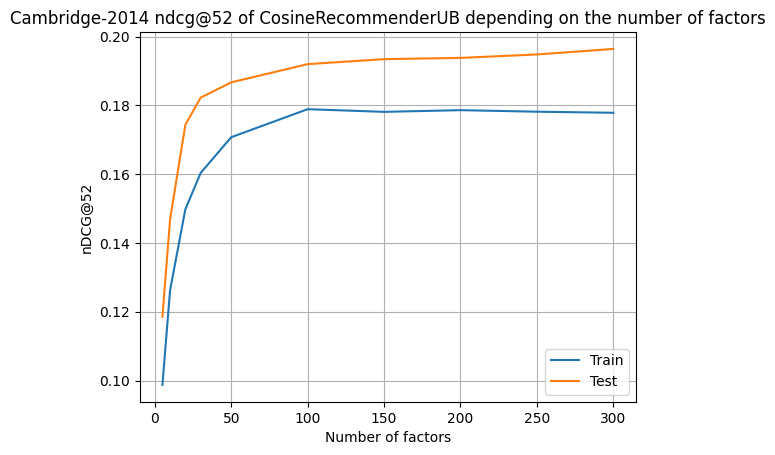

City: Cambridge, Year: 2015


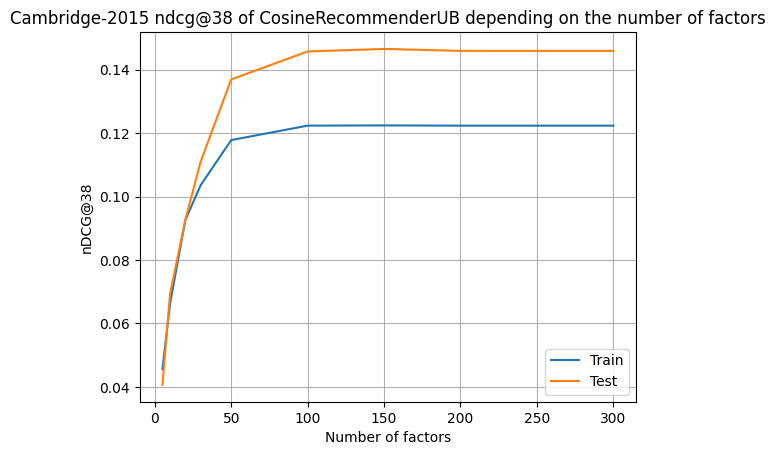

City: Cambridge, Year: 2016


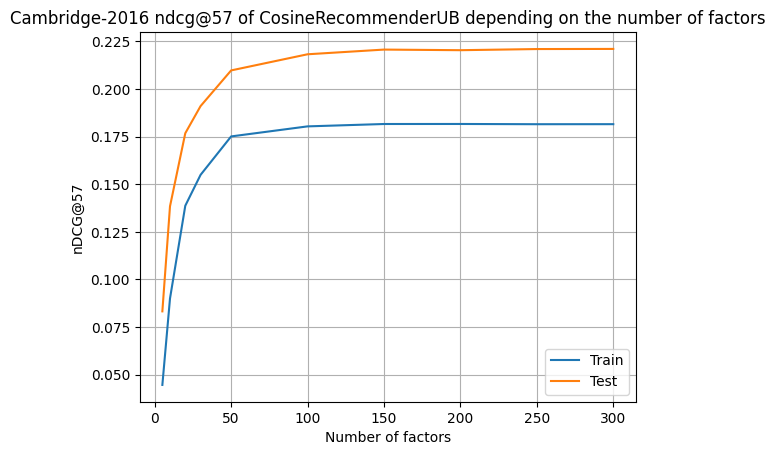

City: Cambridge, Year: 2017


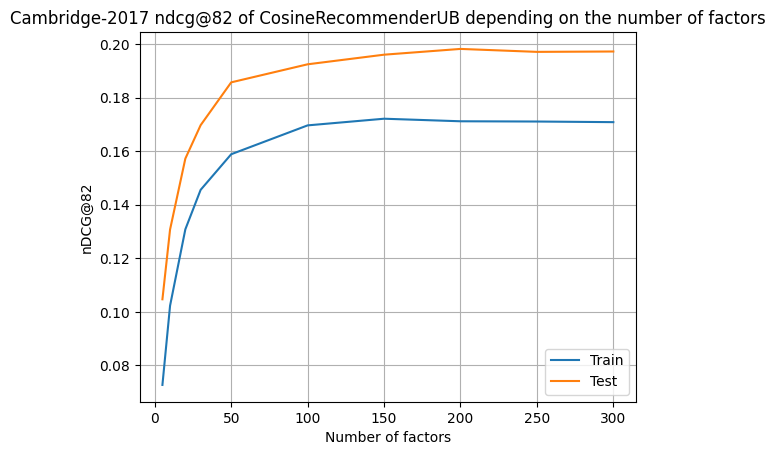

City: Miami, Year: 2014


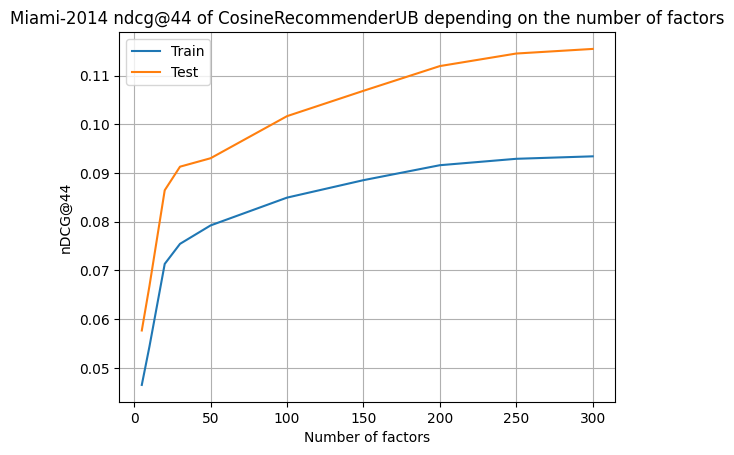

City: Miami, Year: 2015


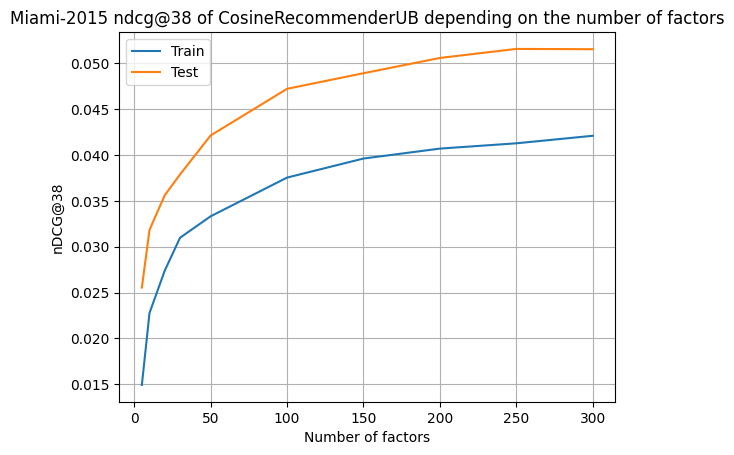

City: Miami, Year: 2016


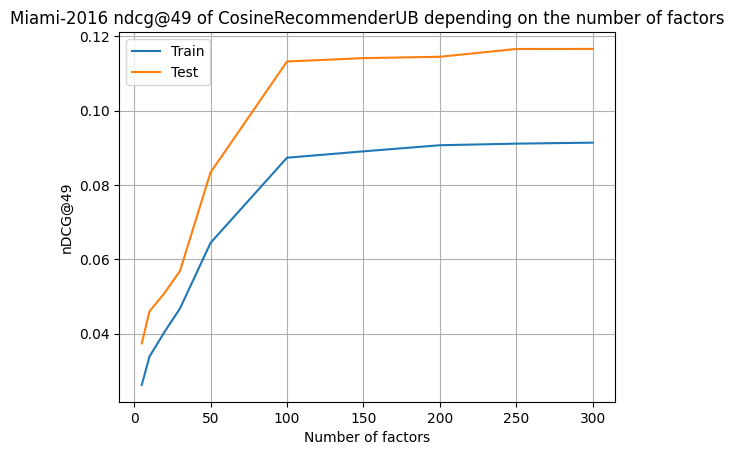

City: Miami, Year: 2017


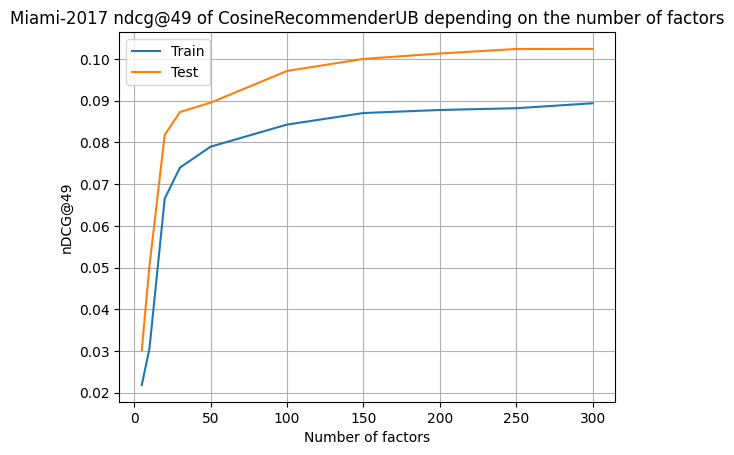

City: New York, Year: 2014


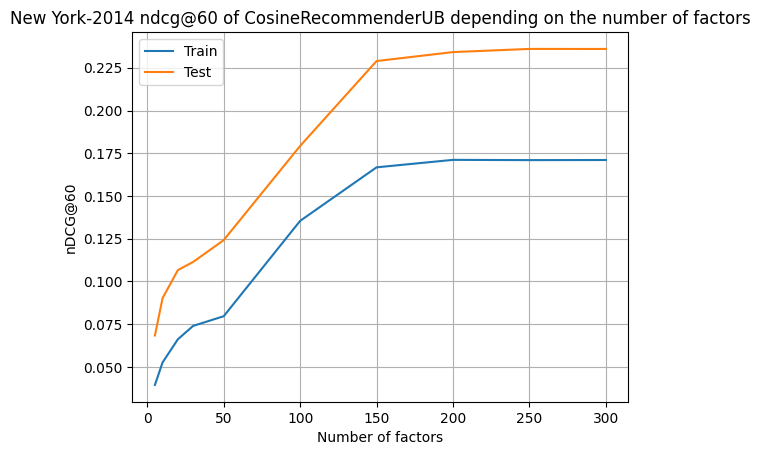

City: New York, Year: 2015


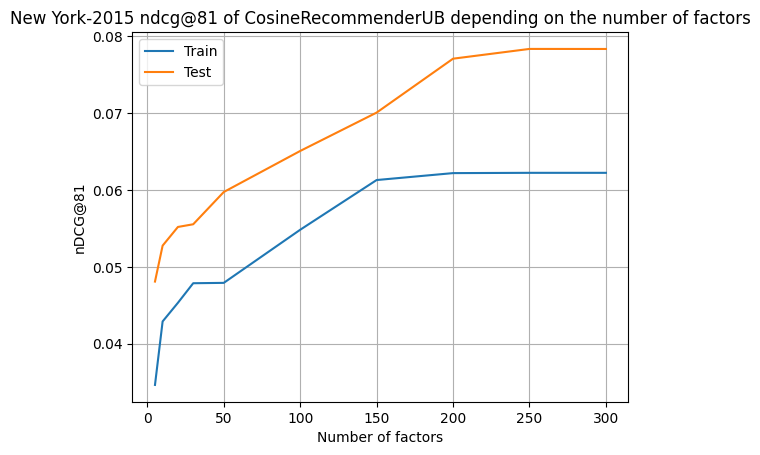

City: New York, Year: 2016


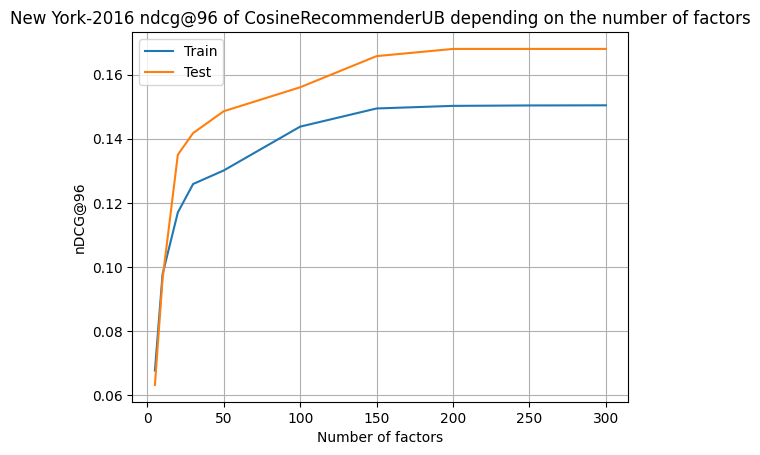

City: New York, Year: 2017


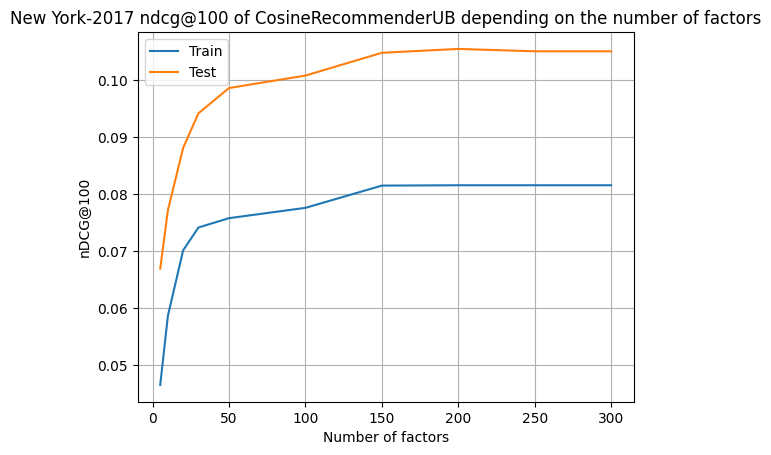

In [8]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        plt.plot(model["ub"]["params"]["K"], cos_ub_dict_train_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        plt.plot(model["ub"]["params"]["K"], cos_ub_dict_test_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        plt.xlabel("Number of factors")
        plt.ylabel(f"nDCG@{n_ndcg_dict[city][year]}")
        plt.title(f"{city}-{year} ndcg@{n_ndcg_dict[city][year]} of CosineRecommenderUB depending on the number of factors")
        plt.grid(True)
        plt.legend(["Train", "Test"])
        plt.show()

### Summary of Optimal Number of Neighbors `K` for CosineRecommenderUB based on NDCG@N

| City       | Year | Best `K` | Explanation |
|------------|------|---------|-------------|
| **Cambridge** | 2014 | **150** | `Test` stabilizes around K≈150, avoiding overfitting. |
| **Cambridge** | 2015 | **100** | `Test` reaches its peak at K≈100 and remains stable. |
| **Cambridge** | 2016 | **150** | `Test` improves until K≈150 and then stabilizes. |
| **Cambridge** | 2017 | **150** | `Test` reaches its maximum performance at K≈150 before flattening. |
| **Miami**     | 2014 | **200** | `Test` reaches its peak at K≈200, avoiding unnecessary computation. |
| **Miami**     | 2015 | **150** | `Test` reaches its best performance at K≈150 and remains stable. |
| **Miami**     | 2016 | **100** | `Test` peaks at K≈100, after which no significant improvement is observed. |
| **Miami**     | 2017 | **150** | `Test` improves up to K≈150 and remains stable afterward. |
| **New York**  | 2014 | **150** | `Test` stabilizes at K≈150, with no further improvements. |
| **New York**  | 2015 | **150** | `Test` reaches its best performance at K≈150 before flattening. |
| **New York**  | 2016 | **150** | `Test` increases up to K≈150, after which no significant improvement is observed. |
| **New York**  | 2017 | **150** | `Test` reaches its best performance at K≈150 with no degradation. |


In [110]:
# Dictionary storing optimal K values for CosineRecommenderUB (User-Based)
optimal_k_ub_cos_dist_dict = {
    "Cambridge": {'2014': 150, '2015': 100, '2016': 150, '2017': 150},
    "Miami": {'2014': 200, '2015': 150, '2016': 100, '2017': 150},
    "New York": {'2014': 150, '2015': 150, '2016': 150, '2017': 150}
}

optimal_nf_ub_cos_dist_dict = {}
for city in cities:
    optimal_nf_ub_cos_dist_dict[city] = {}
    for year in years:
        optimal_nf_ub_cos_dist_dict[city][year] = min(max(round(1.2*optimal_k_ub_cos_dist_dict[city][year]), 5), 100)

In [ ]:
final_metrics_cos_ub_results = {}
for city in cities:
    final_metrics_cos_ub_results[city] = {}
    for year in years:
        dataset = build_db_name(city, year)
        best_factor = optimal_k_ub_cos_dist_dict[city][year]
        best_nf = optimal_nf_ub_cos_dist_dict[city][year]
        m = CosineRecommenderUB(K=best_factor)
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        rm_train = sps.csr_matrix(rm_train.astype(np.float32))
        rm_test = sps.csr_matrix(rm_test.astype(np.float32))
        m.fit(rm_train)
        
        final_metrics_cos_ub = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=best_nf).mean().to_dict(),
            index=['ub']
        )
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_cos_ub.to_csv(f"../../data/final_metrics/{city_year_directory_name}/ub_final_metrics.csv", sep="|")
        
        final_metrics_cos_ub_results[city][year] = final_metrics_cos_ub

In [152]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        rm_train = sps.csr_matrix(rm_train.astype(np.float32))
        rm_test = sps.csr_matrix(rm_test.astype(np.float32))

        recs_cosine_ub = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='ub',
            model=CosineRecommenderUB,
            city=city,
            year=year,
            N=optimal_nf_ub_cos_dist_dict[city][year],
            params={'K':optimal_k_ub_cos_dist_dict[city][year]},
            save=True
        )
        
        print(f"Recomendations saved for {city}-{year}")

  0%|          | 0/874 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2014


  0%|          | 0/528 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2015


  0%|          | 0/856 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2016


  0%|          | 0/1575 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2017


  0%|          | 0/4387 [00:00<?, ?it/s]

Recomendations saved for Miami-2014


  0%|          | 0/6947 [00:00<?, ?it/s]

Recomendations saved for Miami-2015


  0%|          | 0/6907 [00:00<?, ?it/s]

Recomendations saved for Miami-2016


  0%|          | 0/6341 [00:00<?, ?it/s]

Recomendations saved for Miami-2017


  0%|          | 0/1861 [00:00<?, ?it/s]

Recomendations saved for New York-2014


  0%|          | 0/2365 [00:00<?, ?it/s]

Recomendations saved for New York-2015


  0%|          | 0/2253 [00:00<?, ?it/s]

Recomendations saved for New York-2016


  0%|          | 0/3045 [00:00<?, ?it/s]

Recomendations saved for New York-2017


## Bayesian Personalized Ranking 

In [ ]:
baypr_dict_metrics_results = {}
baypr_dict_train_results = {}
baypr_dict_test_results = {}

cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']

for city in cities:
    baypr_dict_metrics_results[city] = {}
    baypr_dict_train_results[city] = {}
    baypr_dict_test_results[city] = {}
    
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        model={"bpr": {'m':BayesianPersonalizedRanking,
               'params':{"factors": [5]+[i for i in range(10, 101, 10)]}}}
        
        metric_results_baypr, train_results_baypr, test_results_baypr, _ = \
            tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=n_ndcg_dict[city][year], model=model, check_overfitting=True)
        baypr_dict_metrics_results[city][year] = metric_results_baypr
        baypr_dict_train_results[city][year] = train_results_baypr
        baypr_dict_test_results[city][year] = test_results_baypr
        
        print(f"City: {city}, Year: {year}")
        print(metric_results_baypr)

City: Cambridge, Year: 2014


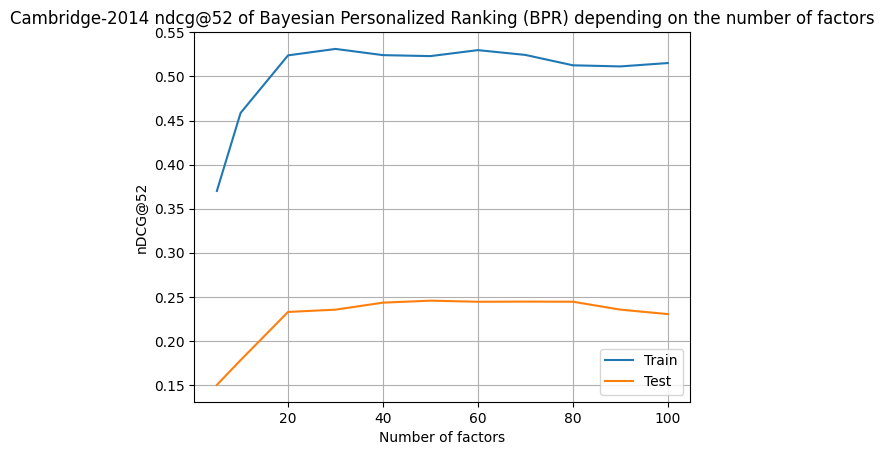

City: Cambridge, Year: 2015


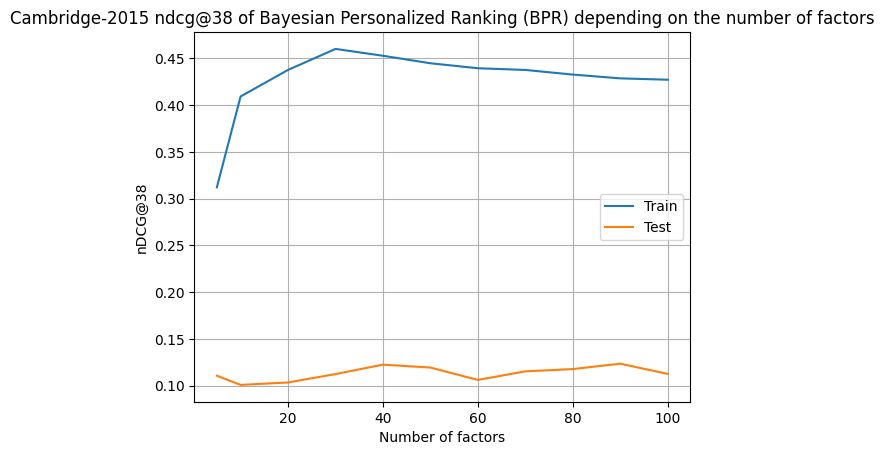

City: Cambridge, Year: 2016


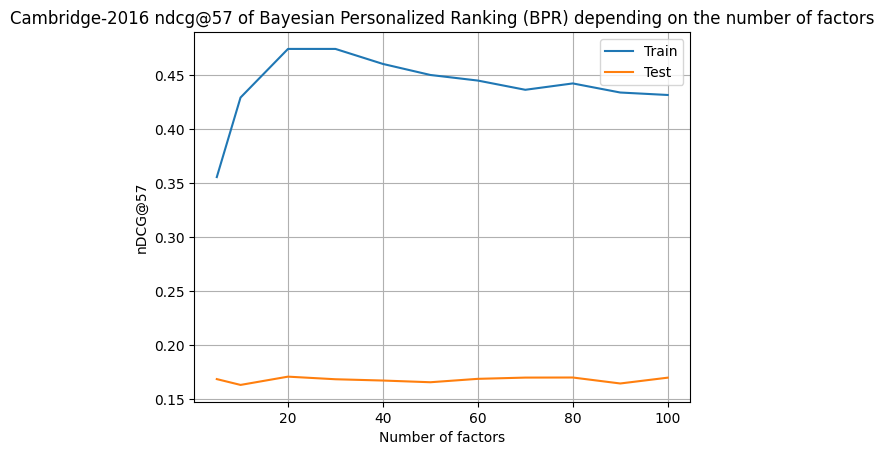

City: Cambridge, Year: 2017


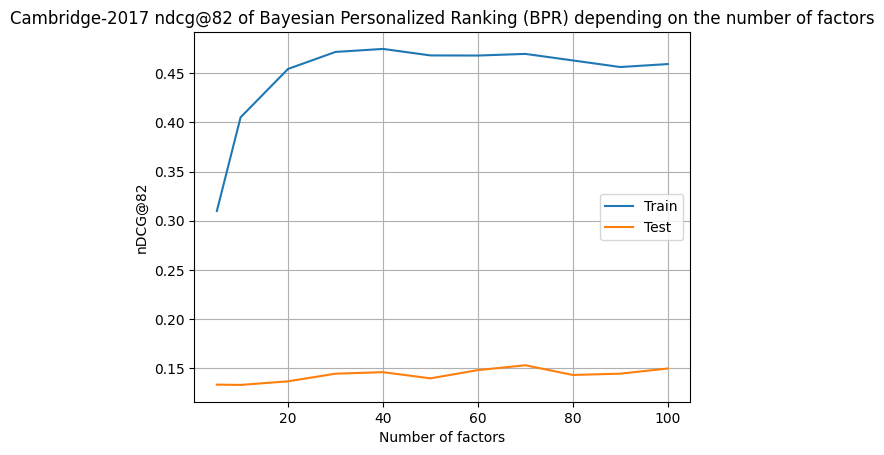

City: Miami, Year: 2014


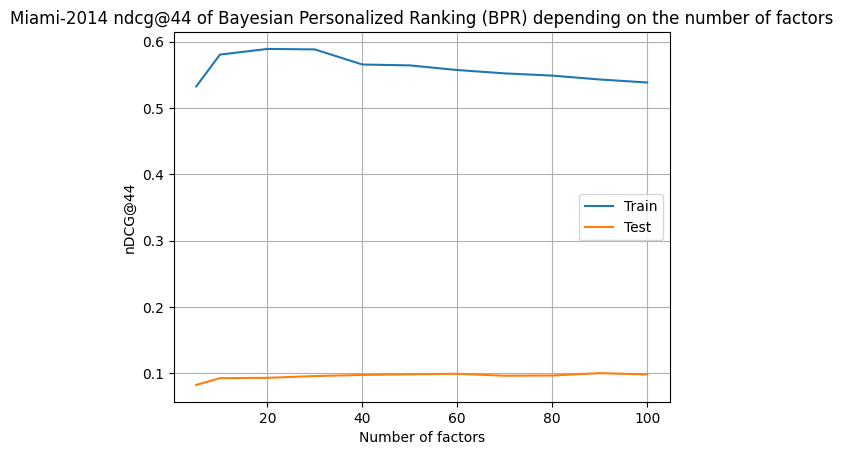

City: Miami, Year: 2015


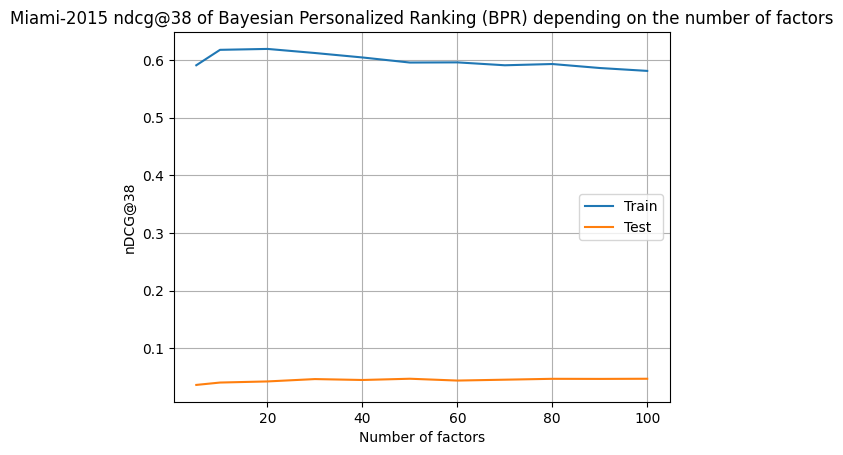

City: Miami, Year: 2016


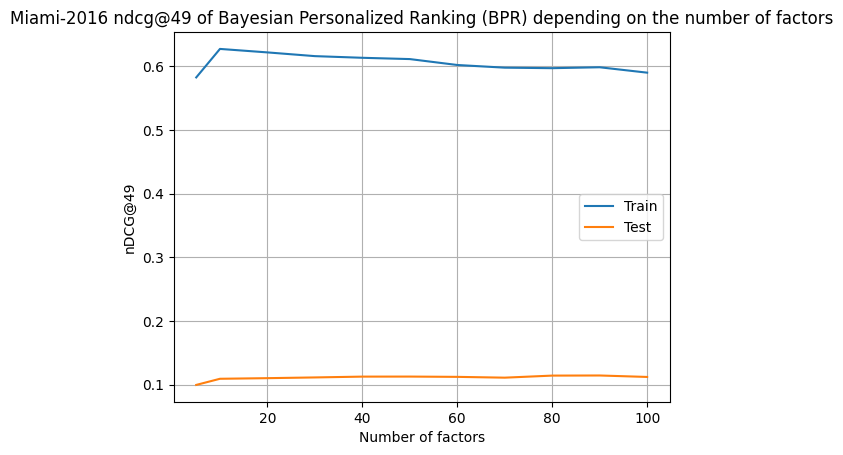

City: Miami, Year: 2017


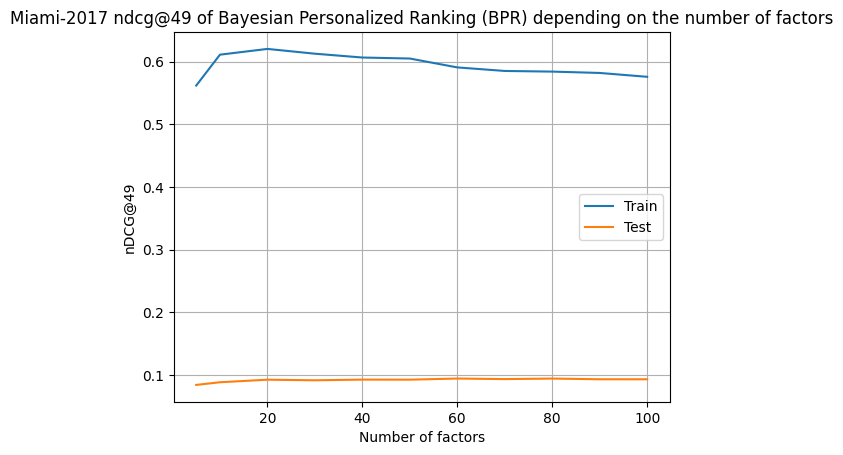

City: New York, Year: 2014


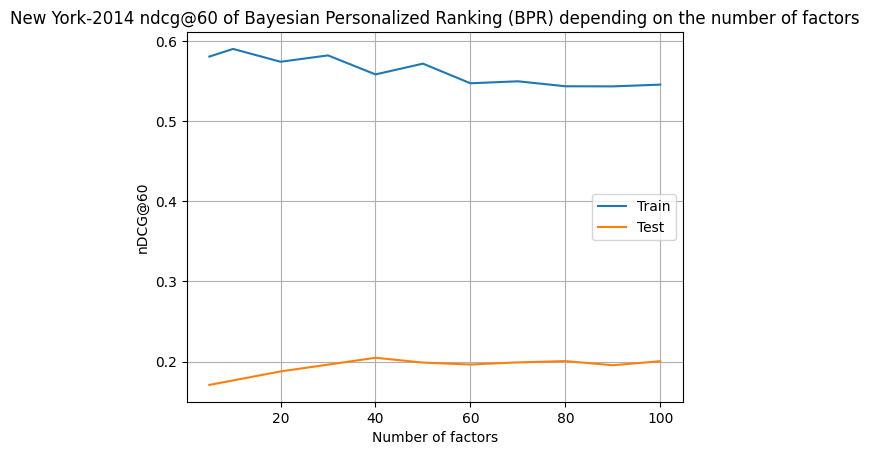

City: New York, Year: 2015


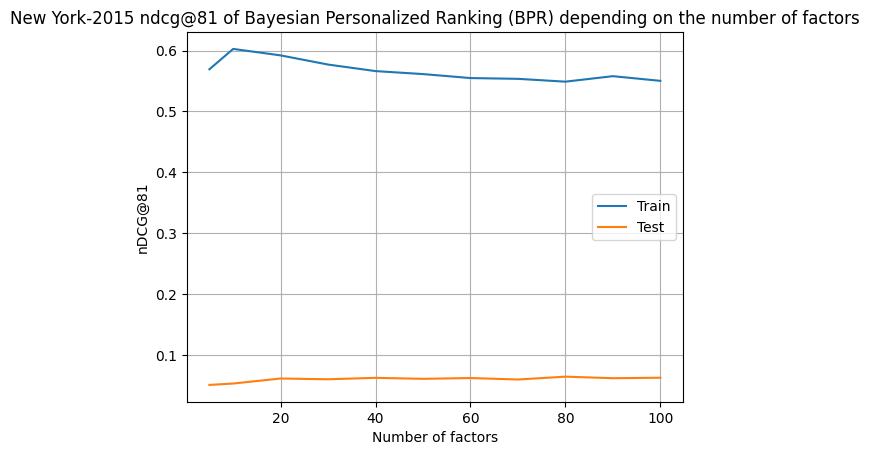

City: New York, Year: 2016


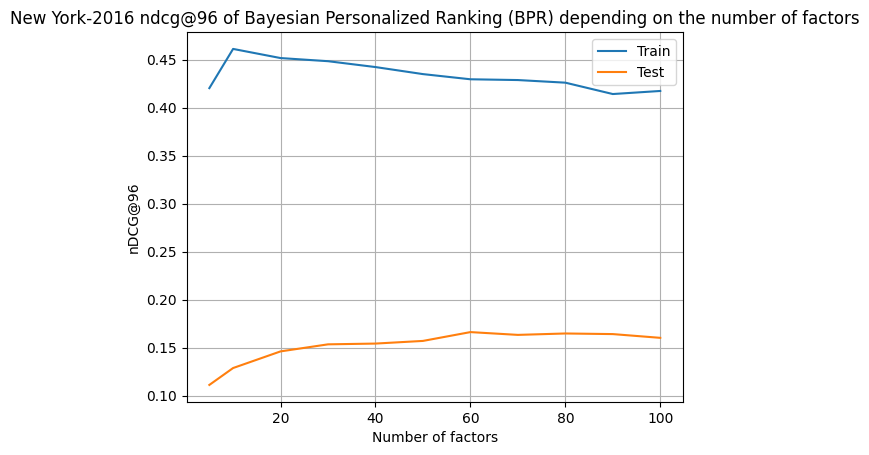

City: New York, Year: 2017


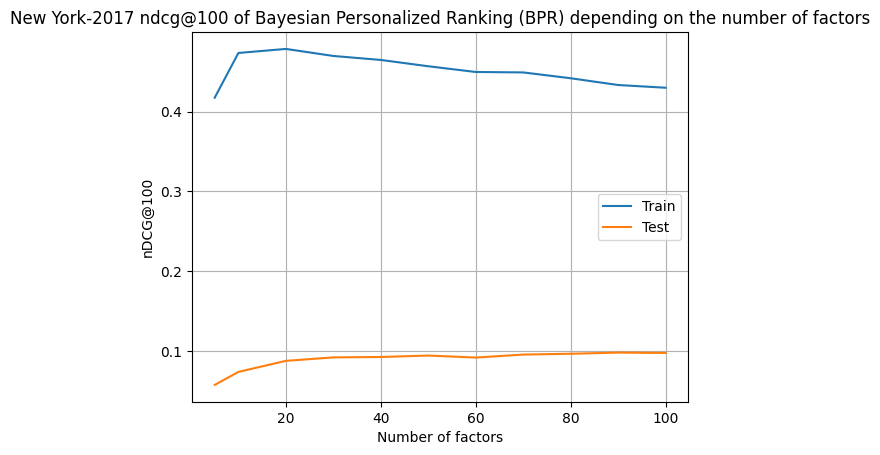

In [15]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        plt.plot(model["bpr"]["params"]["factors"], baypr_dict_train_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        plt.plot(model["bpr"]["params"]["factors"], baypr_dict_test_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        plt.xlabel("Number of factors")
        plt.ylabel(f"nDCG@{n_ndcg_dict[city][year]}")
        plt.title(f"{city}-{year} ndcg@{n_ndcg_dict[city][year]} of Bayesian Personalized Ranking (BPR) depending on the number of factors")
        plt.grid(True)
        plt.legend(["Train", "Test"])
        plt.show()

The initial test results indicate a strong overfitting issue, as the training scores are significantly higher than the test scores across all datasets. This suggests that the Bayesian Personalized Ranking model is learning patterns too specific to the training data, failing to generalize well to unseen data. The primary reasons for this overfitting could be the high number of latent factors, excessive training iterations and insufficient regularization. To address this issue, we weill implement several adjustments:
1. Increasing the regularization parameter to penalize complex factorization models.
2. Reducing the number of training iterations to prevent overfitting.
3. Limitating the number of latent factors to avoid excessive model complexity.
4. Enhancing cross validation to ensure better generalization.

### Second attempt

In [ ]:
baypr_dict_metrics_results = {}
baypr_dict_train_results = {}
baypr_dict_test_results = {}

cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']

for city in cities:
    baypr_dict_metrics_results[city] = {}
    baypr_dict_train_results[city] = {}
    baypr_dict_test_results[city] = {}
    
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']

        model = {
            "bpr": {
                'm': BayesianPersonalizedRanking,
                'params': {
                    "factors": list(range(5, 100, 5)),  
                    "regularization": [0.2],
                }
            }
        }
        
        metric_results_baypr, train_results_baypr, test_results_baypr, _ = \
            tunning_and_metrics(
                rm_train, 
                rm_test, 
                cvk=8,
                N=n_ndcg_dict[city][year], 
                model=model, 
                check_overfitting=True
            )
        
        baypr_dict_metrics_results[city][year] = metric_results_baypr
        baypr_dict_train_results[city][year] = train_results_baypr
        baypr_dict_test_results[city][year] = test_results_baypr

        print(f"City: {city}, Year: {year}")
        print(metric_results_baypr)


In [24]:
print(baypr_dict_train_results['Cambridge']['2014'])


                auc        f1       map       mrr   ndcg@52  precision  \
bpr50.05   0.085732  0.047391  0.328701  0.371361  0.432350   0.025692   
bpr100.05  0.097901  0.054514  0.423750  0.476546  0.526327   0.029614   
bpr200.05  0.102474  0.057213  0.467759  0.526089  0.568859   0.031118   
bpr300.05  0.102922  0.057127  0.474651  0.535911  0.573928   0.031048   
bpr400.05  0.101096  0.056480  0.472604  0.535802  0.570101   0.030714   
bpr500.05  0.101711  0.056241  0.468552  0.526418  0.566793   0.030549   

             recall  std_ndcg@52  var_coef_ndcg@52  
bpr50.05   0.729305     0.108409          0.250745  
bpr100.05  0.798076     0.188953          0.359004  
bpr200.05  0.833255     0.198506          0.348954  
bpr300.05  0.827924     0.219811          0.382994  
bpr400.05  0.819603     0.220612          0.386970  
bpr500.05  0.823576     0.213388          0.376483  


City: Cambridge, Year: 2014


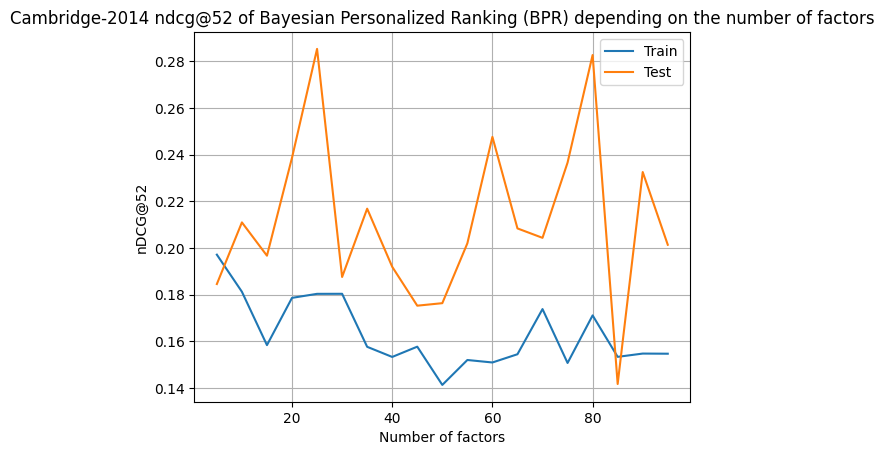

City: Cambridge, Year: 2015


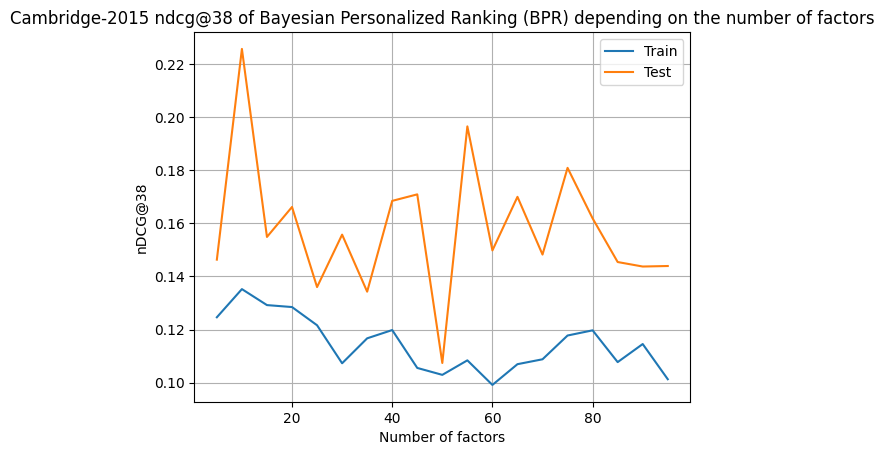

City: Cambridge, Year: 2016


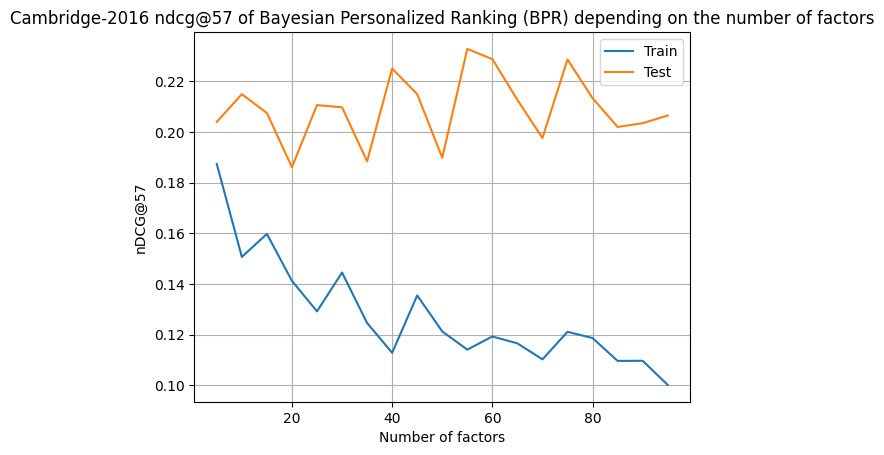

City: Cambridge, Year: 2017


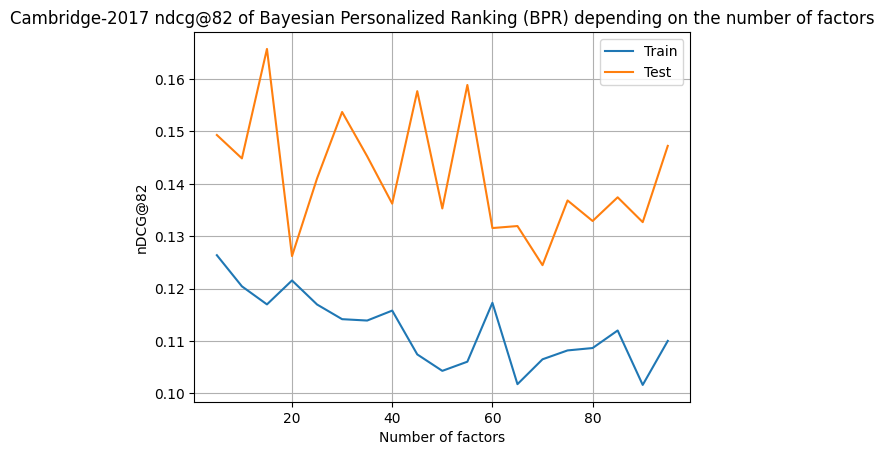

City: Miami, Year: 2014


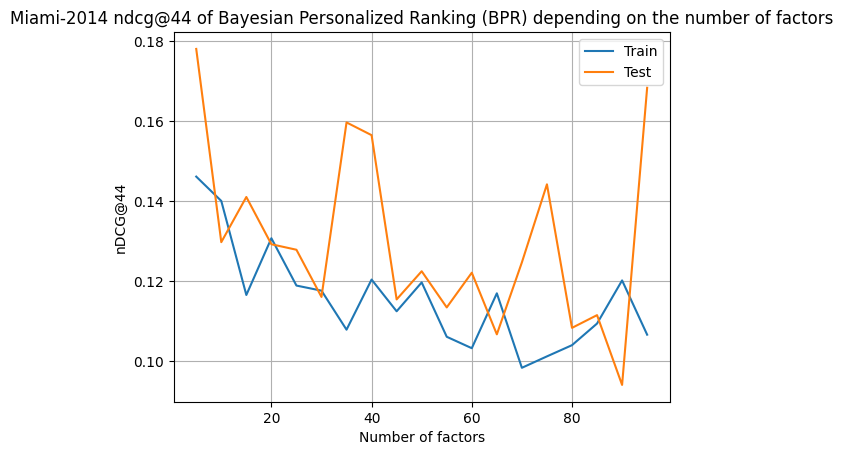

City: Miami, Year: 2015


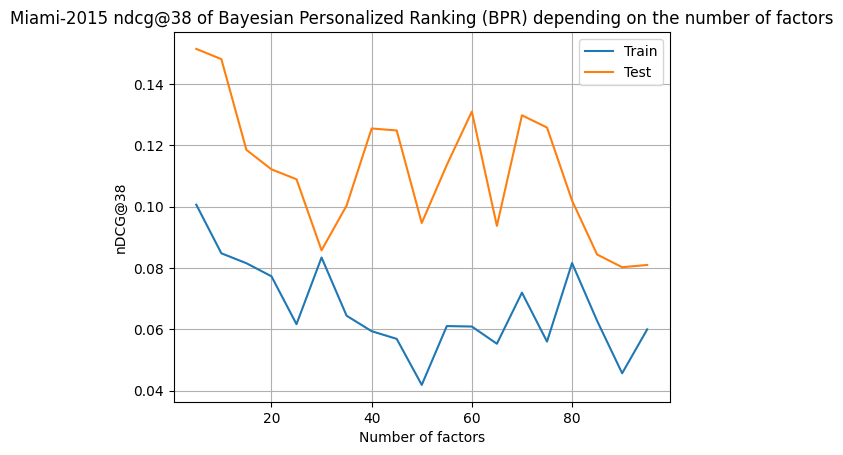

City: Miami, Year: 2016


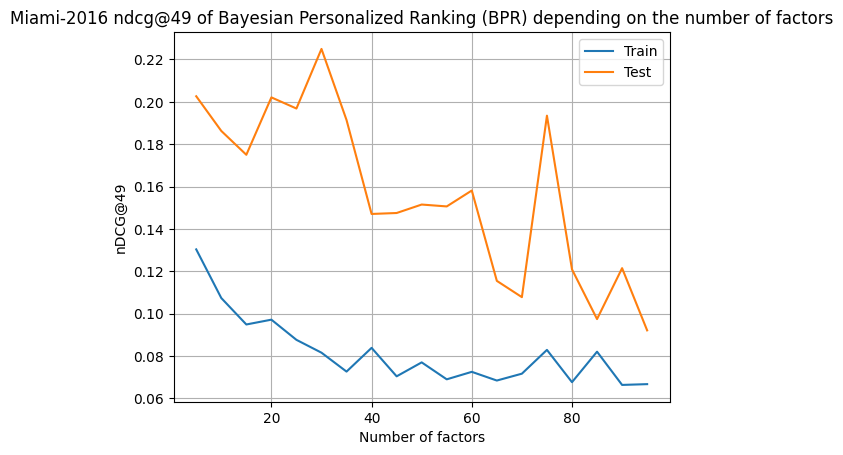

City: Miami, Year: 2017


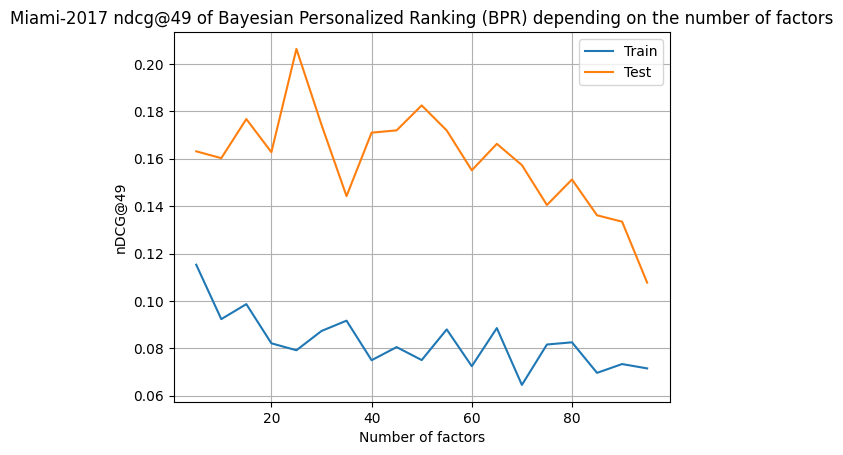

City: New York, Year: 2014


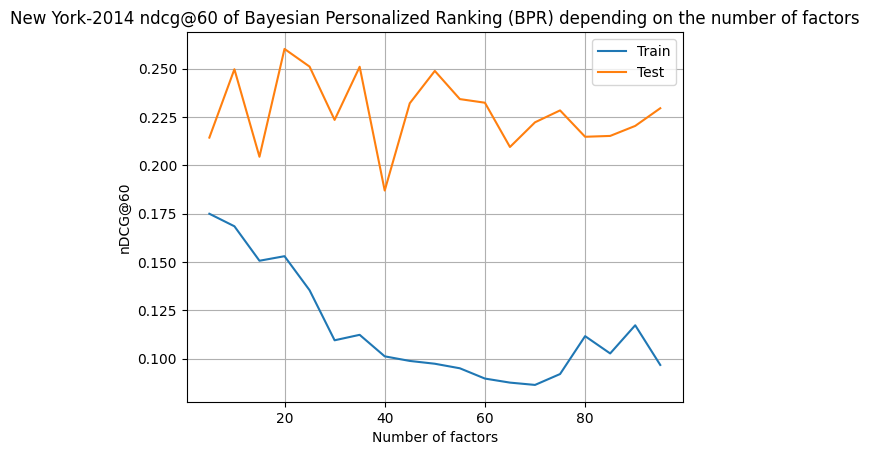

City: New York, Year: 2015


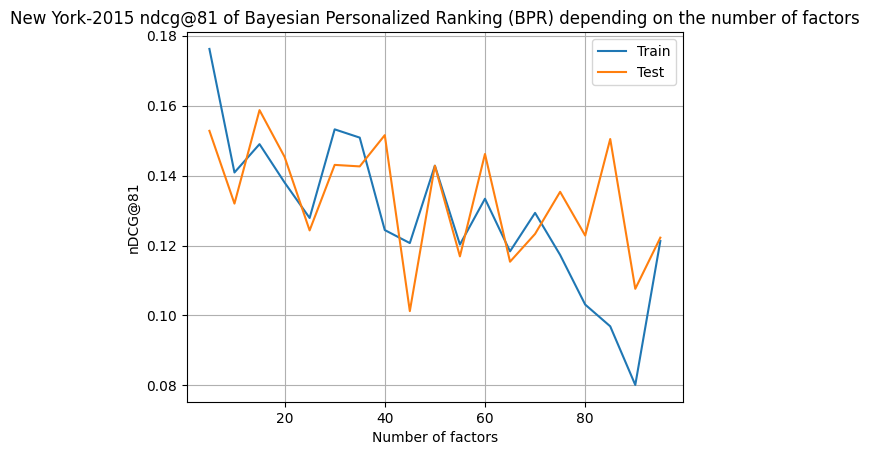

City: New York, Year: 2016


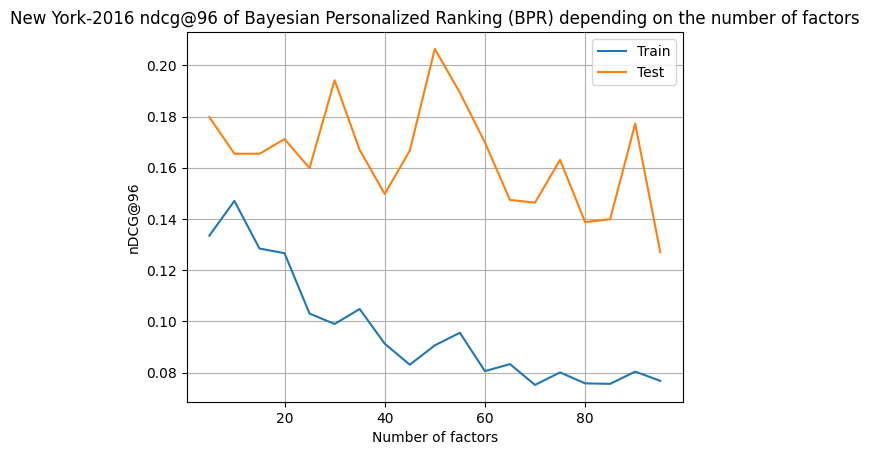

City: New York, Year: 2017


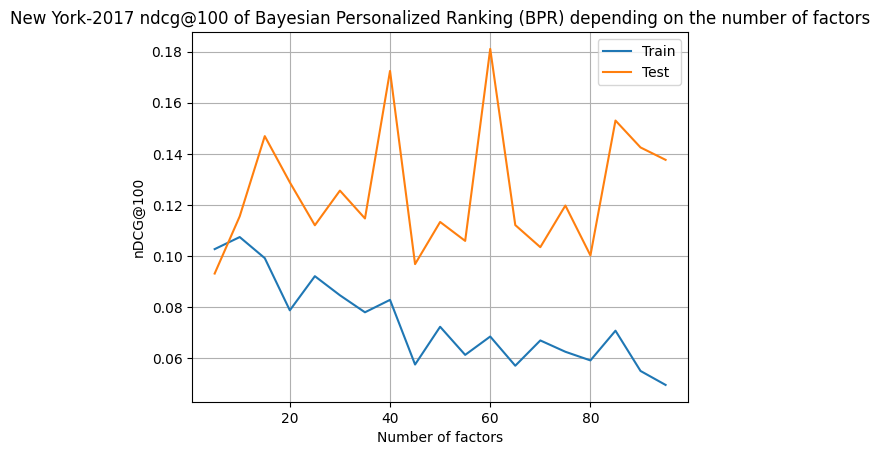

In [29]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        plt.plot(model["bpr"]["params"]["factors"], baypr_dict_train_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        plt.plot(model["bpr"]["params"]["factors"], baypr_dict_test_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        plt.xlabel("Number of factors")
        plt.ylabel(f"nDCG@{n_ndcg_dict[city][year]}")
        plt.title(f"{city}-{year} ndcg@{n_ndcg_dict[city][year]} of Bayesian Personalized Ranking (BPR) depending on the number of factors")
        plt.grid(True)
        plt.legend(["Train", "Test"])
        plt.show()

### Choose the best hyperparameters for BPR
We are going to use the number of factors that maximizes the NDCG@100 metric for the BPR algorithm in the training set.

In [54]:
baypr_dict_best_factors = {}
for city in cities:
    baypr_dict_best_factors[city] = {}
    for year in years:
        best_factor = int(baypr_dict_train_results[city][year][f'ndcg@{N}'].idxmax()[3:])
        baypr_dict_best_factors[city][year] = best_factor
        print(f"City: {city}, Year: {year}, Best factor: {best_factor}")

City: Cambridge, Year: 2014, Best factor: 30
City: Cambridge, Year: 2015, Best factor: 40
City: Cambridge, Year: 2016, Best factor: 20
City: Cambridge, Year: 2017, Best factor: 50
City: Miami, Year: 2014, Best factor: 30
City: Miami, Year: 2015, Best factor: 20
City: Miami, Year: 2016, Best factor: 10
City: Miami, Year: 2017, Best factor: 20
City: New York, Year: 2014, Best factor: 10
City: New York, Year: 2015, Best factor: 10
City: New York, Year: 2016, Best factor: 20
City: New York, Year: 2017, Best factor: 20


In [56]:
baypr_dict_final_metrics = {}
for city in cities:
    baypr_dict_final_metrics[city] = {}
    for year in years:
        bestNumFactors = baypr_dict_best_factors[city][year]
        m = BayesianPersonalizedRanking(factors=bestNumFactors)
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        m.fit(rm_train)
        
        final_metrics_baypr = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
            index=['bpr']
        )
        
        baypr_dict_final_metrics[city][year] = final_metrics_baypr
        print(f"City: {city}, Year: {year}")
        print(final_metrics_baypr)
        

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=319)

BayesianPersonalizedRanking
City: Cambridge, Year: 2014
     precision    recall     map   ndcg@50       auc       mrr        f1
bpr   0.019812  0.500489  0.1658  0.254667  0.054206  0.208438  0.035934


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=200)

BayesianPersonalizedRanking
City: Cambridge, Year: 2015
     precision    recall       map   ndcg@50       auc       mrr        f1
bpr     0.0091  0.257351  0.067344  0.113434  0.029842  0.091443  0.017282


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=290)

BayesianPersonalizedRanking
City: Cambridge, Year: 2016
     precision    recall       map   ndcg@50       auc       mrr       f1
bpr   0.011586  0.341643  0.110764  0.167725  0.029362  0.149419  0.02136


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=568)

BayesianPersonalizedRanking
City: Cambridge, Year: 2017
     precision    recall       map   ndcg@50      auc       mrr        f1
bpr   0.018134  0.392848  0.091635  0.172329  0.02469  0.132876  0.032888


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=1060)

BayesianPersonalizedRanking
City: Miami, Year: 2014
     precision    recall       map   ndcg@50      auc       mrr        f1
bpr    0.01117  0.441332  0.077177  0.150013  0.04524  0.081914  0.021541


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=1535)

BayesianPersonalizedRanking
City: Miami, Year: 2015
     precision    recall       map   ndcg@50       auc       mrr        f1
bpr   0.003961  0.180749  0.024996  0.054563  0.018269  0.026424  0.007729


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=1595)

BayesianPersonalizedRanking
City: Miami, Year: 2016
     precision    recall       map   ndcg@50       auc       mrr       f1
bpr    0.00632  0.282619  0.094988  0.133699  0.031171  0.097914  0.01227


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=1464)

BayesianPersonalizedRanking
City: Miami, Year: 2017
     precision    recall       map   ndcg@50       auc      mrr        f1
bpr   0.006571  0.292438  0.075984  0.118675  0.029827  0.07756  0.012789


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=462)

BayesianPersonalizedRanking
City: New York, Year: 2014
     precision    recall       map  ndcg@50       auc       mrr        f1
bpr   0.008658  0.404229  0.166612  0.21749  0.039078  0.171612  0.016889


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=544)

BayesianPersonalizedRanking
City: New York, Year: 2015
     precision    recall       map   ndcg@50       auc       mrr        f1
bpr   0.017169  0.764423  0.113653  0.249214  0.051107  0.123486  0.033009


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=608)

BayesianPersonalizedRanking
City: New York, Year: 2016
     precision    recall       map   ndcg@50       auc       mrr        f1
bpr   0.003914  0.163103  0.052767  0.075044  0.007456  0.056713  0.007607


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=776)

BayesianPersonalizedRanking
City: New York, Year: 2017
     precision    recall       map   ndcg@50       auc       mrr        f1
bpr   0.006701  0.302767  0.068228  0.117255  0.010603  0.072677  0.013008


In [57]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        
        recs_baypr = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='bpr',
            model=BayesianPersonalizedRanking,
            params={'factors':baypr_dict_best_factors[city][year]},
            city=city,
            year=year,
            N=Nf,
            save=True
        )
        
        print(f"Recomendations saved for {city}-{year}")

  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2014


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2015


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2016


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for Cambridge-2017


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for Miami-2014


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for Miami-2015


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for Miami-2016


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for Miami-2017


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for New York-2014


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for New York-2015


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for New York-2016


  0%|          | 0/100 [00:00<?, ?it/s]

Recomendations saved for New York-2017


## Content Based Recommender
It generates personalized recommendations by leveraging attributes associated with items and user preferences. The central idea is to recommend items similar to those a user has previously liked or interacted with, based on the content (categories or locations) of the items.

In a content-based recommender system, items and users are represented as profiles in the same feature space. For instance, an item profile is a vector representing the item´s association with certain tags or attributes, and a user profile is a constructed based on the aggregated attributes of items that the user previously interacted with. 

Let $I$ be the set of items, $U$ be the set of users and $T$ the set of all possible attributes. Each item $i \in I$ has an item profile $q_i \in \mathbb{R}^{|T|}$:
$$
q_i = \left(w_{i,1}, w_{i,2}, \ldots, w_{i,|T|}\right)
$$
where $w_{i,t}$ is the weight of attribute $t$ in item $i$. 

Similarly, each user $u \in U$ has a user profile $p_u \in \mathbb{R}^{|T|}$, constructed from the item profiles the user has interacted with:
$$
p_u = \frac{1}{|I_u|} \sum_{i \in I_u} q_i
$$
where $I_u$ is the set of items that user $u$ has interacted with.

The similarity score between a user $u$ and an item $i$ is computed using cosine similarity, explained before.


### Content Based Recommender - Categories

In [ ]:
cbcat_dict_metrics_results = {}
cbcat_nf_dict_metrics_results = {}

for city in cities:
    cbcat_dict_metrics_results[city] = {}
    cbcat_nf_dict_metrics_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        rm_info = all_data[db_name]['rm_info']
        
        model={
            "cb_cat": {
                'm':ContentBasedRecommender, 
                'params':{
                    'it_cat_matrix': [it_cat_data[db_name]['it_cat_info']['it_cat']],
                    }
                }
            }
        metric_results_cb_cat, _,_,_ = tunning_and_metrics(
            rm_train,
            rm_test,
            N=n_ndcg_dict[city][year],
            model=model,
            Nf=None
            )
        cbcat_dict_metrics_results[city][year] = metric_results_cb_cat
        
        metric_results_cb_cat, _,_,_ = tunning_and_metrics(
            rm_train,
            rm_test,
            N=n_ndcg_dict[city][year],
            model=model,
            Nf=nf_ndcg_dict[city][year]
            )
        cbcat_nf_dict_metrics_results[city][year] = metric_results_cb_cat

In [61]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        print(cbcat_dict_metrics_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'])
        print(cbcat_nf_dict_metrics_results[city][year][f'ndcg@{nf_ndcg_dict[city][year]}'])

City: Cambridge, Year: 2014
cb_cat    0.046223
Name: ndcg@52, dtype: float64
cb_cat    0.049456
Name: ndcg@70, dtype: float64
City: Cambridge, Year: 2015
cb_cat    0.055063
Name: ndcg@38, dtype: float64
cb_cat    0.069011
Name: ndcg@50, dtype: float64
City: Cambridge, Year: 2016
cb_cat    0.035058
Name: ndcg@57, dtype: float64
cb_cat    0.045962
Name: ndcg@76, dtype: float64
City: Cambridge, Year: 2017
cb_cat    0.030977
Name: ndcg@82, dtype: float64
cb_cat    0.036517
Name: ndcg@100, dtype: float64
City: Miami, Year: 2014
cb_cat    0.011569
Name: ndcg@44, dtype: float64
cb_cat    0.014586
Name: ndcg@59, dtype: float64
City: Miami, Year: 2015
cb_cat    0.007079
Name: ndcg@38, dtype: float64
cb_cat    0.008049
Name: ndcg@50, dtype: float64
City: Miami, Year: 2016
cb_cat    0.007165
Name: ndcg@49, dtype: float64
cb_cat    0.008298
Name: ndcg@66, dtype: float64
City: Miami, Year: 2017
cb_cat    0.006205
Name: ndcg@49, dtype: float64
cb_cat    0.007799
Name: ndcg@65, dtype: float64
City: N

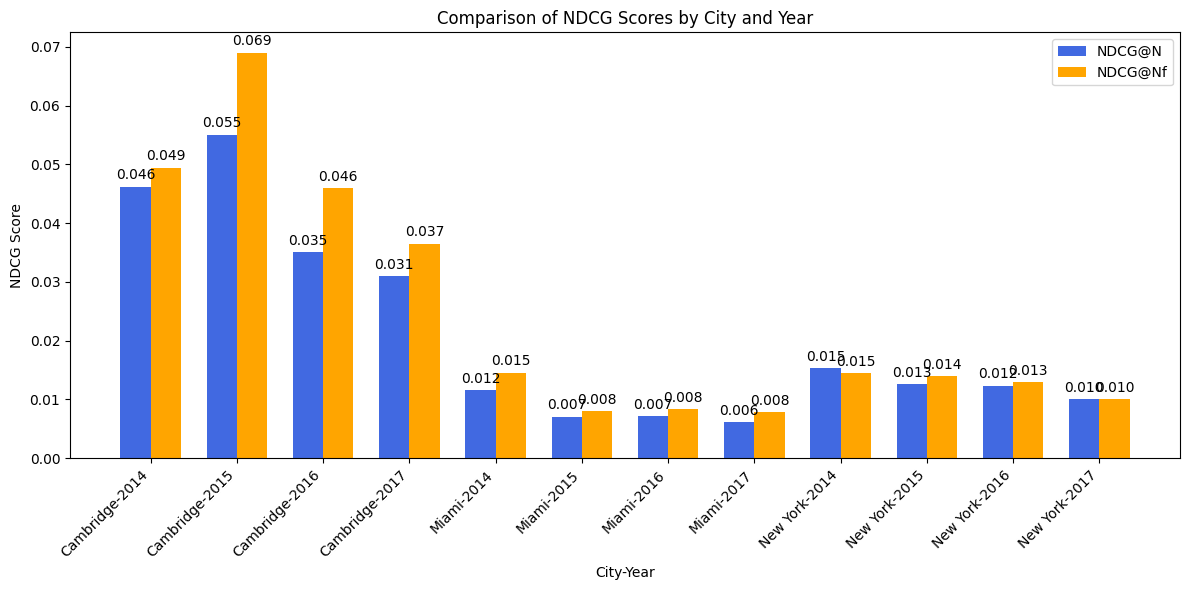

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer los datos para graficar
labels = []
ndcg_values_n = []
ndcg_values_nf = []

for city in cbcat_dict_metrics_results.keys():
    for year in cbcat_dict_metrics_results[city].keys():
        labels.append(f"{city}-{year}")

        # Obtener un valor único (promedio o primer valor)
        ndcg_values_n.append(cbcat_dict_metrics_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'].iloc[0])
        ndcg_values_nf.append(cbcat_nf_dict_metrics_results[city][year][f'ndcg@{nf_ndcg_dict[city][year]}'].iloc[0])

# Configuración del gráfico de barras
x = np.arange(len(labels))  # Posiciones de las etiquetas
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, ndcg_values_n, width, label='NDCG@N', color='royalblue')
rects2 = ax.bar(x + width/2, ndcg_values_nf, width, label='NDCG@Nf', color='orange')

# Etiquetas y título
ax.set_xlabel('City-Year')
ax.set_ylabel('NDCG Score')
ax.set_title('Comparison of NDCG Scores by City and Year')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Mostrar valores sobre las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(rects1)
add_labels(rects2)

# Mostrar gráfico
plt.tight_layout()
plt.show()


When comparing the performance of the Content-Based Recommender using categories, we observe that the metric ndcg@n is lower than ndcg@nf for all datasets except New York 2014. That is the reason why we are going to use the 'Nf' value instead of 'N' for the Content Based Recommender using categories.

In [112]:
for city in cities:
    for year in years:
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        dataframe = cbcat_nf_dict_metrics_results[city][year]
        dataframe.to_csv(f"../../data/final_metrics/{city_year_directory_name}/cb_cat_final_metrics.csv", sep="|")
        

In [158]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        
        recs_cbcat = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='cb_cat',
            model=ContentBasedRecommender,
            params={'it_cat_matrix': it_cat_data[dataset]['it_cat_info']['it_cat']},
            N=nf_ndcg_dict[city][year],
            save=True,
            city=city,
            year=year,
        )
        print(f"Recomendations saved for {city}-{year}")

Recomendations saved for Cambridge-2014
Recomendations saved for Cambridge-2015
Recomendations saved for Cambridge-2016
Recomendations saved for Cambridge-2017
Recomendations saved for Miami-2014
Recomendations saved for Miami-2015
Recomendations saved for Miami-2016
Recomendations saved for Miami-2017
Recomendations saved for New York-2014
Recomendations saved for New York-2015
Recomendations saved for New York-2016
Recomendations saved for New York-2017


### Content Based Recommender - Locations

In [7]:
it_loc_data = dict()

for city in cities:
    for year in years:
        db_name = build_db_name(city, year)
        it_loc_data[db_name] = dict()
        it_loc_info = get_item_location_info(city, year)
        it_loc_data[db_name]['it_loc_info'] = it_loc_info

In [ ]:
cbloc_dict_metrics_results = {}
cbloc_nf_dict_metrics_results = {}

for city in cities:
    cbloc_dict_metrics_results[city] = {}
    cbloc_nf_dict_metrics_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        rm_info = all_data[db_name]['rm_info']
        
        model={
            "cb_loc": {
                'm':ContentBasedRecommender, 
                'params':{
                    'it_cat_matrix': [it_loc_data[db_name]['it_loc_info']['it_loc']],
                    }
                }
            }
        metric_results_cb_loc, _,_,_ = tunning_and_metrics(
            rm_train,
            rm_test,
            N=n_ndcg_dict[city][year],
            model=model,
            Nf=None
            )
        cbloc_dict_metrics_results[city][year] = metric_results_cb_loc
        
        metric_results_cb_loc, _,_,_ = tunning_and_metrics(
            rm_train,
            rm_test,
            N=n_ndcg_dict[city][year],
            model=model,
            Nf=nf_ndcg_dict[city][year]
            )
        cbloc_nf_dict_metrics_results[city][year] = metric_results_cb_loc
        

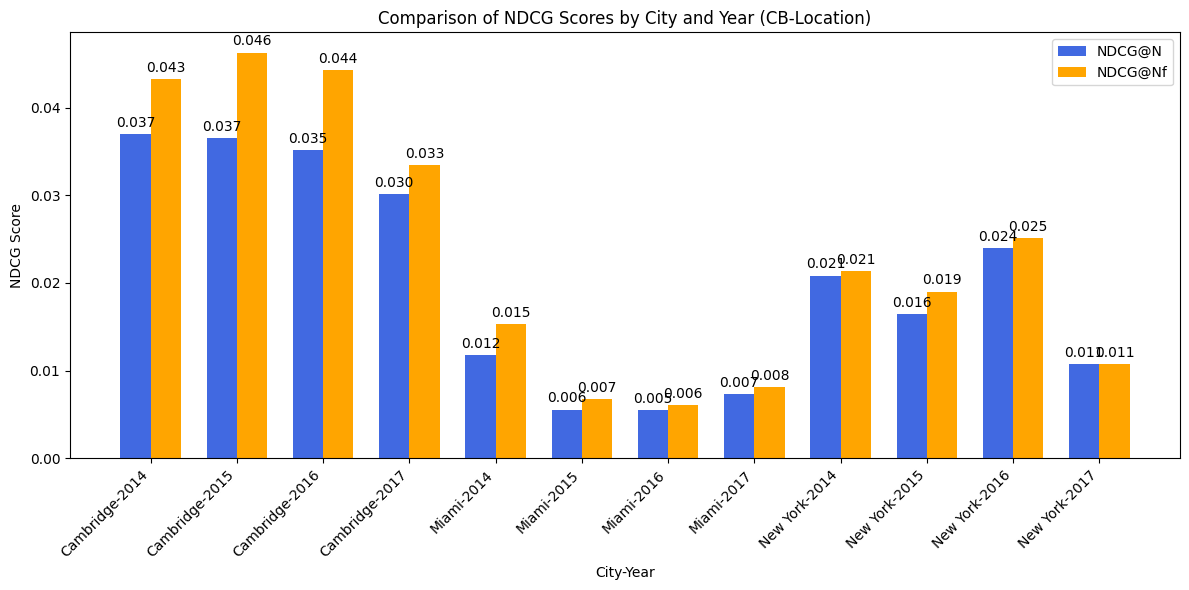

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer los datos para graficar
labels = []
ndcg_values_n = []
ndcg_values_nf = []

for city in cbloc_dict_metrics_results.keys():
    for year in cbloc_dict_metrics_results[city].keys():
        labels.append(f"{city}-{year}")

        # Obtener un valor único (promedio o primer valor)
        ndcg_values_n.append(cbloc_dict_metrics_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'].iloc[0])
        ndcg_values_nf.append(cbloc_nf_dict_metrics_results[city][year][f'ndcg@{nf_ndcg_dict[city][year]}'].iloc[0])

# Configuración del gráfico de barras
x = np.arange(len(labels))  # Posiciones de las etiquetas
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, ndcg_values_n, width, label='NDCG@N', color='royalblue')
rects2 = ax.bar(x + width/2, ndcg_values_nf, width, label='NDCG@Nf', color='orange')

# Etiquetas y título
ax.set_xlabel('City-Year')
ax.set_ylabel('NDCG Score')
ax.set_title('Comparison of NDCG Scores by City and Year (CB-Location)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Mostrar valores sobre las barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(rects1)
add_labels(rects2)

# Mostrar gráfico
plt.tight_layout()
plt.show()


In [8]:
for city in cities:
    for year in years:
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        dataframe = cbloc_nf_dict_metrics_results[city][year]
        dataframe.to_csv(f"../../data/final_metrics/{city_year_directory_name}/cb_loc_final_metrics.csv", sep="|")
        

In [10]:
for city in cities:
    for year in years:
        dataset = build_db_name(city, year)
        rm_info = all_data[dataset]['rm_info']
        rm_train = all_data[dataset]['rm_train']
        rm_test = all_data[dataset]['rm_test']
        
        recs_cbloc = gen_recommendations(
            rm_info=rm_info,
            rm_train=rm_train,
            rm_test=rm_test,
            model_name='cb_loc',
            model=ContentBasedRecommender,
            params={'it_cat_matrix': it_loc_data[dataset]['it_loc_info']['it_loc']},
            N=nf_ndcg_dict[city][year],
            save=True,
            city=city,
            year=year,
        )
        print(f"Recomendations saved for {city}-{year}")

Recomendations saved for Cambridge-2014
Recomendations saved for Cambridge-2015
Recomendations saved for Cambridge-2016
Recomendations saved for Cambridge-2017
Recomendations saved for Miami-2014
Recomendations saved for Miami-2015
Recomendations saved for Miami-2016
Recomendations saved for Miami-2017
Recomendations saved for New York-2014
Recomendations saved for New York-2015
Recomendations saved for New York-2016
Recomendations saved for New York-2017


## Hybrid User Based
It combines Content-Based and User-Based Collaborative Filtering techniques. This hybrid approach computes user similarities based on the content-based profiles, rather than directly using their historical item interactions. The final approach is to recommend items liked by similar users, where user similarity is computed according to shared interests, inferred from their content-based profiles. 

Let's see its mathematical formulation. It is divided into three main steps:
1. Build user profiles (Content-Based).
2. Build User similarity.
3. Calculate recommendations score.

Now, we are going to analyze the different steps of the algorithm in detail.
1. Build user profiles:
Each user profile vector $p_u$ is built using item profiles of items the user has previously interacted with:
$$
p_u = \frac{1}{|I_u|} \sum_{i \in I_u} q_i$$
Where:
- $I_u$ is the set of items that user $u$ has interacted with.
- $q_i$ is the content-based item profile vector.

2. User similarity:
The similarity between two users $u$ and $v$ is computed using cosine similarity based on their content-based profiles $p_u$ and $p_v$. This generates a user-user similarity matrix based entirely on user content preferences inferred from item features.

3. Recommendation score:
The final score for recommending an item $i$ to a user $u$ is calculated by aggregating ratings of similar users, weighted by user similarity:
$$
\text{score}(u,i) = \frac{\sum_{v \in U_i} \text{sim}(u,v) \cdot r_{v,i}}{\sum_{v \in U_i} |\text{sim}(u,v)|}
$$
Where:
- $U_i$ is the set of users who have interacted with item $i$.
- $r_{v,i}$ represents the interaction between user $v$ and item $i$.


### Hybrid User Based - Categories

In [ ]:
cbcat_dict_metrics_results = {}
cbcat_dict_train_results = {}
cbcat_dict_test_results = {}

for city in cities:
    cbcat_dict_metrics_results[city] = {}
    cbcat_dict_train_results[city] = {}
    cbcat_dict_test_results[city] = {}
    
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        rm_info = all_data[db_name]['rm_info']
        num_users = rm_info['rm'].shape[0]
        print(f"City: {city}, Year: {year}")
        print(f"Number of users: {num_users}")
        model={
            "cbub_cat": {
                'm':HybridRecommenderUB, 
                'params':{
                    'it_cat_matrix': [it_cat_data[db_name]['it_cat_info']['it_cat']],
                    'tag': ['category'],
                    "K": [k for k in [5] + list(range(50, num_users, 50)) + [1000, 2000, 6000] if k < num_users],
                    }
                }
            }
        metric_results_cbub_cat, train_results_cbub_cat, test_results_cbub_cat,_ = tunning_and_metrics(
            rm_train,
            rm_test,
            cvk=cvk,
            N=n_ndcg_dict[city][year],
            model=model,
            check_overfitting=True,
            )
        cbcat_dict_metrics_results[city][year] = metric_results_cbub_cat
        cbcat_dict_train_results[city][year] = train_results_cbub_cat
        cbcat_dict_test_results[city][year] = test_results_cbub_cat

City: Cambridge, Year: 2014


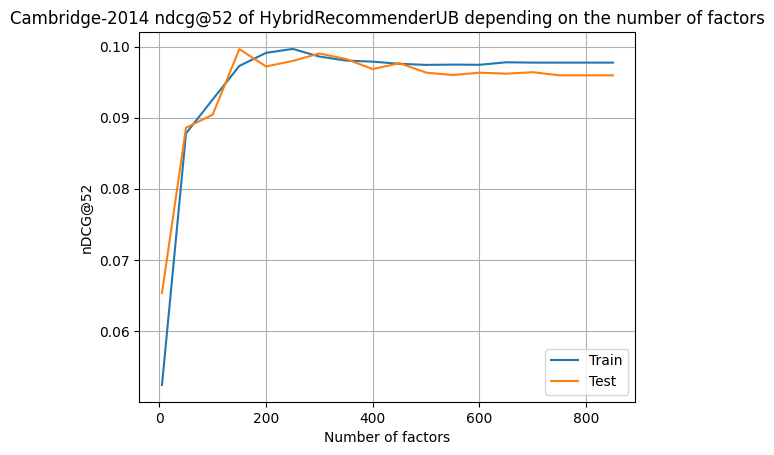

City: Cambridge, Year: 2015


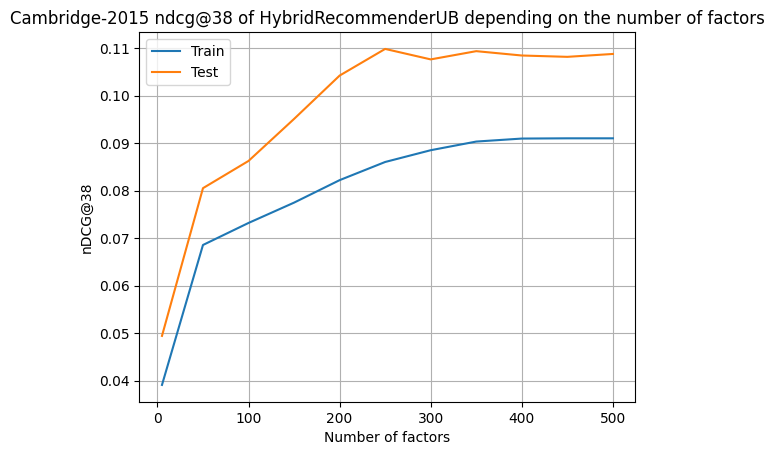

City: Cambridge, Year: 2016


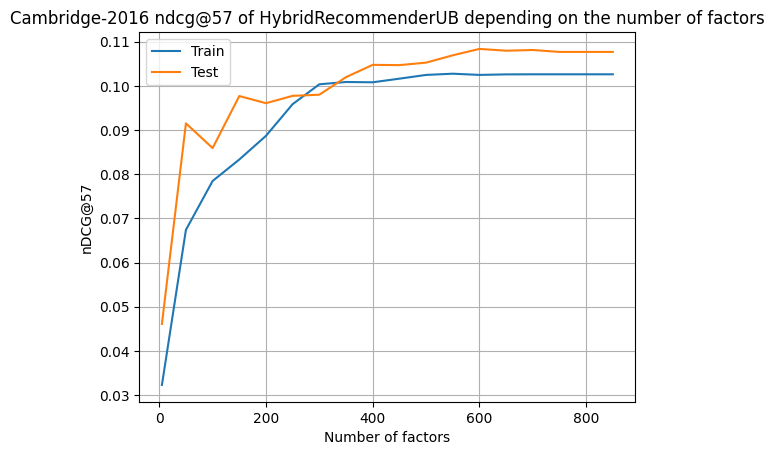

City: Cambridge, Year: 2017


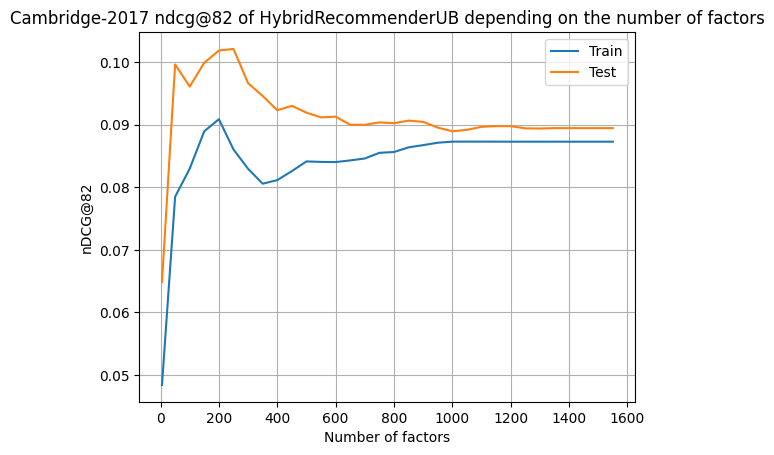

City: Miami, Year: 2014


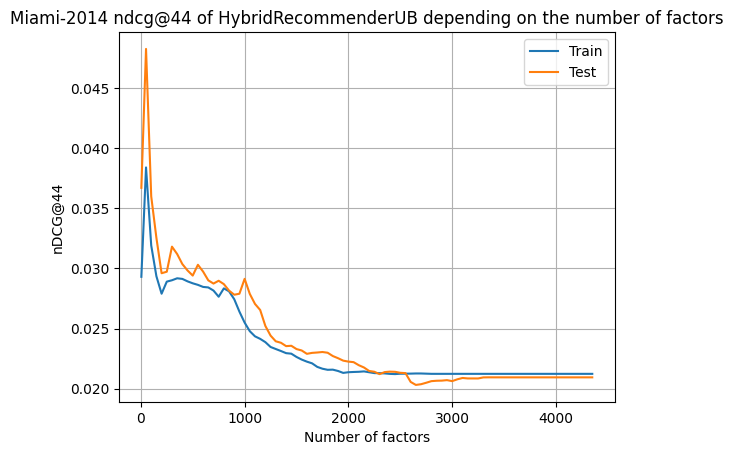

City: Miami, Year: 2015


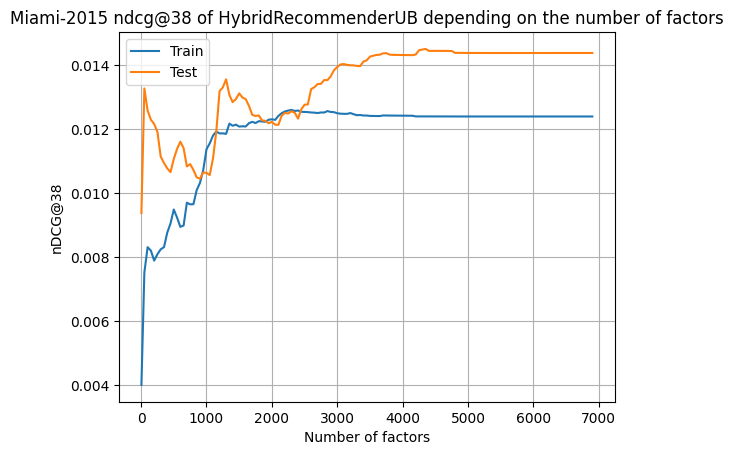

City: Miami, Year: 2016


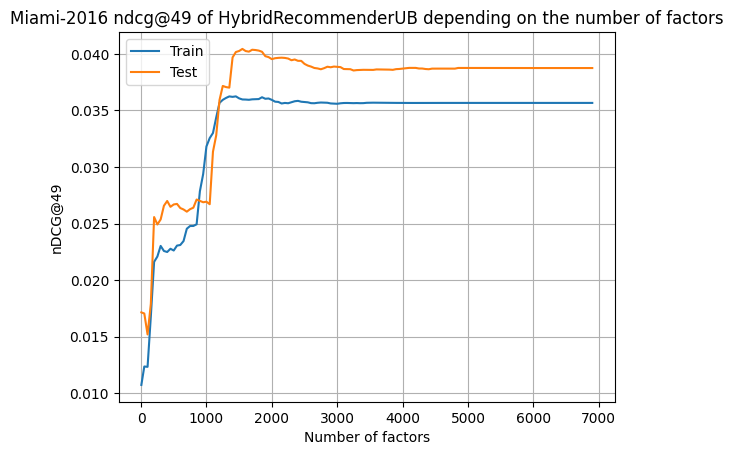

City: Miami, Year: 2017


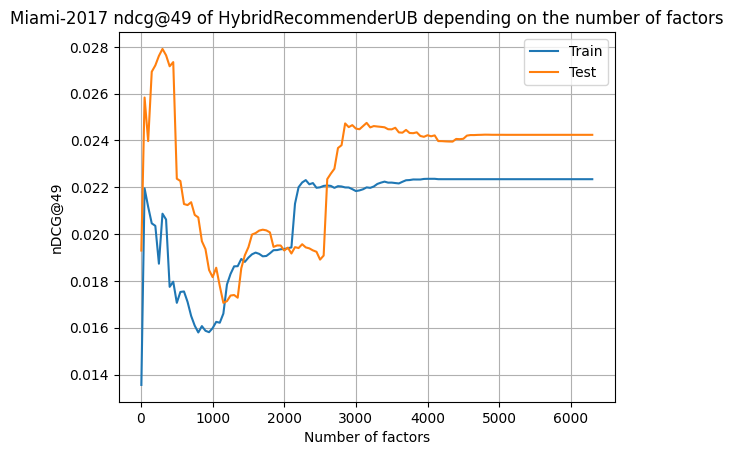

City: New York, Year: 2014


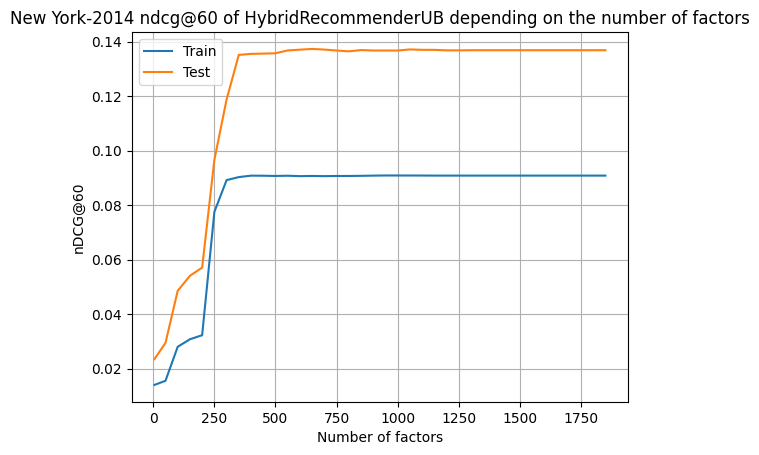

City: New York, Year: 2015


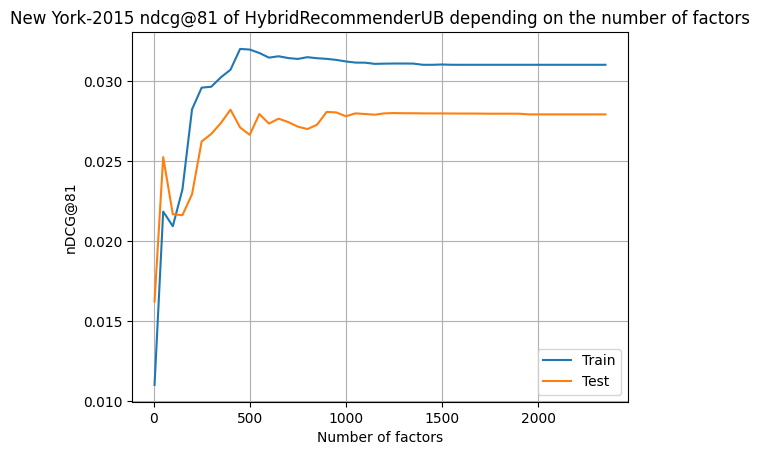

City: New York, Year: 2016


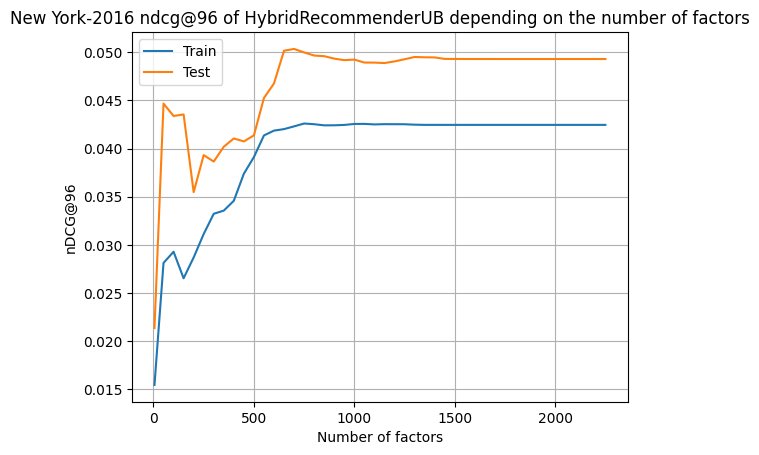

City: New York, Year: 2017


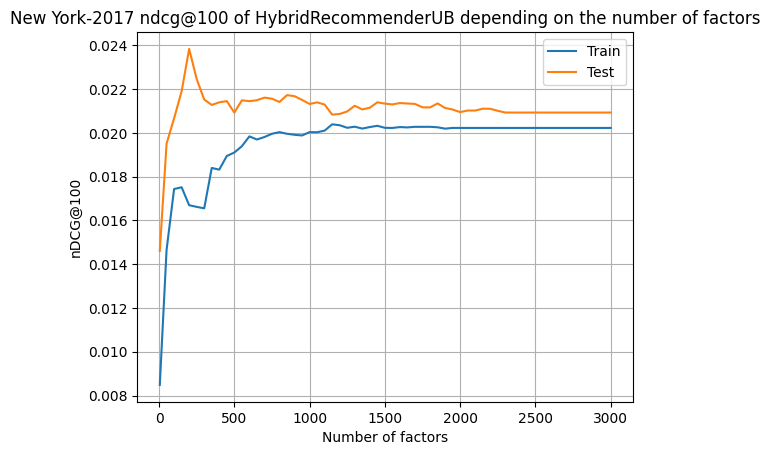

In [83]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        num_users = all_data[build_db_name(city, year)]['rm_info']['rm'].shape[0]
        length = len([k for k in [5] + list(range(50, num_users, 50)) if k < num_users])
        plt.plot(
            [k for k in [5] + list(range(50, num_users, 50)) if k < num_users],
            cbcat_dict_train_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'][0:length]
            )
        plt.plot(
            [k for k in [5] + list(range(50, num_users, 50)) if k < num_users],
            cbcat_dict_test_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'][0:length]
            )
        plt.xlabel("Number of factors")
        plt.ylabel(f"nDCG@{n_ndcg_dict[city][year]}")
        plt.title(f"{city}-{year} ndcg@{n_ndcg_dict[city][year]} of HybridRecommenderUB depending on the number of factors")
        plt.grid(True)
        plt.legend(["Train", "Test"])
        plt.show()

#### **`K` values for HybridRecommenderUB**
| City      | Year | Best `K` | Explanation |
|-----------|------|---------|-------------|
| Cambridge | 2014 | 200     | Stabilizes at ~200, further increase yields minimal gains. |
| Cambridge | 2015 | 300     | Consistent performance, optimal balance at 300. |
| Cambridge | 2016 | 400     | Best trade-off observed at 400. |
| Cambridge | 2017 | 600     | Gains continue until ~600, then plateau. |
| Miami     | 2014 | 500     | After 500, performance starts to decrease. |
| Miami     | 2015 | 3000    | Performance stabilizes at ~3000. |
| Miami     | 2016 | 1500    | Best results observed around 1500 and then it balances. |
| Miami     | 2017 | 3000    | Stables at 3000. |
| New York  | 2014 | 300     | No significant improvement beyond. |
| New York  | 2015 | 750     | Best results around 750, then stagnates. |
| New York  | 2016 | 740     | Gains continue until ~1000, then minimal improvement. |
| New York  | 2017 | 1000    | Best performance observed around 1000. |


In [113]:
best_k_values_hybrid = {
    "Cambridge": {
        "2014": 200,
        "2015": 300,
        "2016": 400,
        "2017": 600
    },
    "Miami": {
        "2014": 500,
        "2015": 3000,
        "2016": 1500,
        "2017": 3000
    },
    "New York": {
        "2014": 300,
        "2015": 750,
        "2016": 740,
        "2017": 1000
    }
}

In [115]:
final_metrics_cbub_results = {}
for city in cities:
    final_metrics_cbub_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        m = HybridRecommenderUB(
            K=best_k_values_hybrid[city][year],
            it_cat_matrix=it_cat_data[db_name]['it_cat_info']['it_cat'],
            tag='category',
        )
        
        m.fit(rm_train)
        
        final_metrics_cbub = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=nf_ndcg_dict[city][year]).mean().to_dict(),
            index=['cbub_cat']
        )
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_cbub.to_csv(f"../../data/final_metrics/{city_year_directory_name}/cbub_cat_final_metrics.csv", sep="|")
        
        final_metrics_cbub_results[city][year] = final_metrics_cbub
        print(f"City: {city}, Year: {year}")
        print(final_metrics_cbub)
        

  0%|          | 0/874 [00:00<?, ?it/s]

IntProgress(value=0, max=319)

HybridRecommenderUB
City: Cambridge, Year: 2014
          precision   recall       map   ndcg@70       auc       mrr        f1
cbub_cat   0.012674  0.31047  0.043246  0.111037  0.035716  0.076262  0.023201


  0%|          | 0/528 [00:00<?, ?it/s]

IntProgress(value=0, max=200)

HybridRecommenderUB
City: Cambridge, Year: 2015
          precision    recall       map   ndcg@50       auc       mrr  \
cbub_cat     0.0141  0.336982  0.049602  0.119566  0.038378  0.068665   

                f1  
cbub_cat  0.026531  


  0%|          | 0/856 [00:00<?, ?it/s]

IntProgress(value=0, max=290)

HybridRecommenderUB
City: Cambridge, Year: 2016
          precision    recall       map   ndcg@76       auc       mrr  \
cbub_cat   0.008757  0.351865  0.043703  0.113413  0.045944  0.053748   

                f1  
cbub_cat  0.016545  


  0%|          | 0/1575 [00:00<?, ?it/s]

IntProgress(value=0, max=568)

HybridRecommenderUB
City: Cambridge, Year: 2017
          precision    recall       map  ndcg@100       auc       mrr       f1
cbub_cat   0.009507  0.315533  0.027311  0.097507  0.035355  0.045327  0.01788


  0%|          | 0/4387 [00:00<?, ?it/s]

IntProgress(value=0, max=1060)

HybridRecommenderUB
City: Miami, Year: 2014
          precision    recall       map   ndcg@59       auc       mrr  \
cbub_cat   0.003454  0.099806  0.011362  0.031231  0.011242  0.012633   

                f1  
cbub_cat  0.006544  


  0%|          | 0/6947 [00:00<?, ?it/s]

IntProgress(value=0, max=1535)

HybridRecommenderUB
City: Miami, Year: 2015
          precision    recall       map   ndcg@50     auc       mrr        f1
cbub_cat   0.001577  0.057828  0.004622  0.015575  0.0063  0.005541  0.003044


  0%|          | 0/6907 [00:00<?, ?it/s]

IntProgress(value=0, max=1595)

HybridRecommenderUB
City: Miami, Year: 2016
          precision    recall       map   ndcg@66       auc       mrr  \
cbub_cat   0.002498  0.128637  0.021293  0.043227  0.017494  0.022481   

                f1  
cbub_cat  0.004824  


  0%|          | 0/6341 [00:00<?, ?it/s]

IntProgress(value=0, max=1464)

HybridRecommenderUB
City: Miami, Year: 2017
          precision    recall       map   ndcg@65       auc       mrr  \
cbub_cat   0.002301  0.109318  0.006925  0.027101  0.012799  0.007404   

                f1  
cbub_cat  0.004451  


  0%|          | 0/1861 [00:00<?, ?it/s]

IntProgress(value=0, max=462)

HybridRecommenderUB
City: New York, Year: 2014
          precision    recall       map   ndcg@81       auc       mrr      f1
cbub_cat   0.003714  0.261578  0.079562  0.120107  0.036622  0.083602  0.0073


  0%|          | 0/2365 [00:00<?, ?it/s]

IntProgress(value=0, max=544)

HybridRecommenderUB
City: New York, Year: 2015
          precision    recall       map  ndcg@100       auc       mrr  \
cbub_cat   0.001783  0.102241  0.011353  0.029713  0.011359  0.013052   

                f1  
cbub_cat  0.003416  


  0%|          | 0/2253 [00:00<?, ?it/s]

IntProgress(value=0, max=608)

HybridRecommenderUB
City: New York, Year: 2016
          precision    recall       map  ndcg@100       auc       mrr      f1
cbub_cat   0.002286  0.177138  0.018113  0.050186  0.019816  0.020946  0.0045


  0%|          | 0/3045 [00:00<?, ?it/s]

IntProgress(value=0, max=776)

HybridRecommenderUB
City: New York, Year: 2017
          precision    recall       map  ndcg@100       auc       mrr  \
cbub_cat   0.001392  0.081687  0.006997  0.021318  0.004093  0.009103   

                f1  
cbub_cat  0.002696  


In [154]:
for city in cities:
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        recs_cbub_cat = gen_recommendations(
            rm_info,
            rm_train,
            rm_test,
            model_name='cbub_cat',
            model=HybridRecommenderUB,
            save=True,
            city=city,
            year=year,
            N=nf_ndcg_dict[city][year],
            params={
                'it_cat_matrix': it_cat_data[db_name]['it_cat_info']['it_cat'],
                'tag': 'category',
                'K': best_k_values_hybrid[city][year]
            },
        )
        

  0%|          | 0/874 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/4387 [00:00<?, ?it/s]

  0%|          | 0/6947 [00:00<?, ?it/s]

  0%|          | 0/6907 [00:00<?, ?it/s]

  0%|          | 0/6341 [00:00<?, ?it/s]

  0%|          | 0/1861 [00:00<?, ?it/s]

  0%|          | 0/2365 [00:00<?, ?it/s]

  0%|          | 0/2253 [00:00<?, ?it/s]

  0%|          | 0/3045 [00:00<?, ?it/s]

### Hybrid User Based - Location

In [ ]:
cbloc_dict_metrics_results = {}
cbloc_dict_train_results = {}
cbloc_dict_test_results = {}

for city in cities:
    cbloc_dict_metrics_results[city] = {}
    cbloc_dict_train_results[city] = {}
    cbloc_dict_test_results[city] = {}
    
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        rm_info = all_data[db_name]['rm_info']
        num_users = rm_info['rm'].shape[0]
        print(f"City: {city}, Year: {year}")
        print(f"Number of users: {num_users}")
        model={
            "cbub_loc": {
                'm':HybridRecommenderUB, 
                'params':{
                    'it_cat_matrix': [it_loc_data[db_name]['it_loc_info']['it_loc']],
                    'tag': ['category'],
                    "K": [k for k in [5] + list(range(50, num_users, 50)) + [1000, 2000, 6000] if k < num_users],
                    }
                }
            }
        metric_results_cbub_loc, train_results_cbub_loc, test_results_cbub_loc,_ = tunning_and_metrics(
            rm_train,
            rm_test,
            cvk=cvk,
            N=n_ndcg_dict[city][year],
            model=model,
            check_overfitting=True,
            )
        cbloc_dict_metrics_results[city][year] = metric_results_cbub_loc
        cbloc_dict_train_results[city][year] = train_results_cbub_loc
        cbloc_dict_test_results[city][year] = test_results_cbub_loc

City: Cambridge, Year: 2014


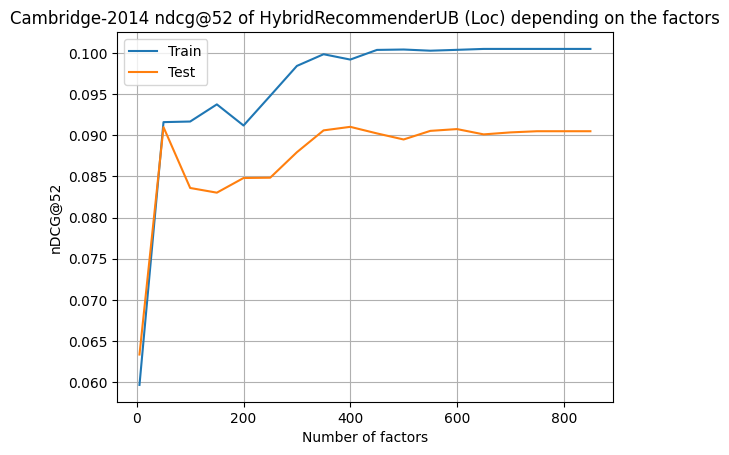

City: Cambridge, Year: 2015


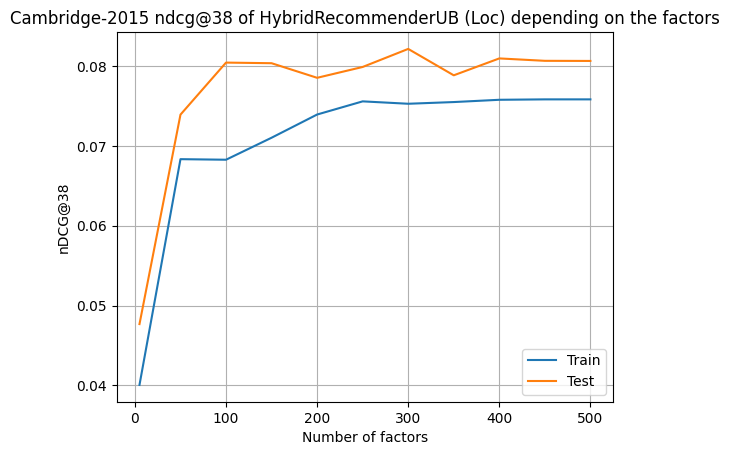

City: Cambridge, Year: 2016


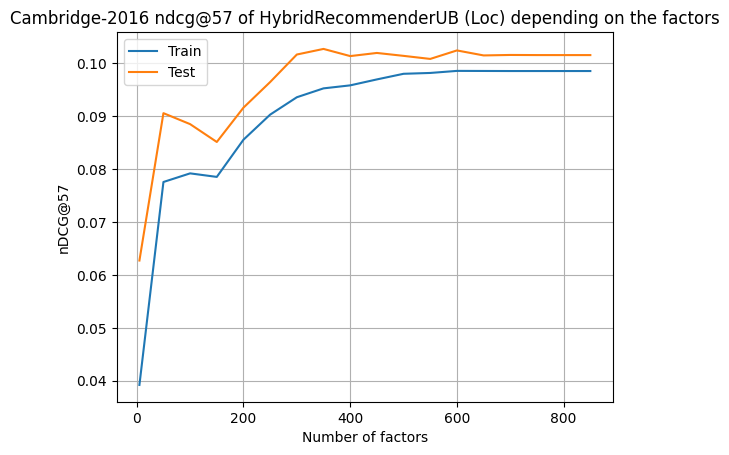

City: Cambridge, Year: 2017


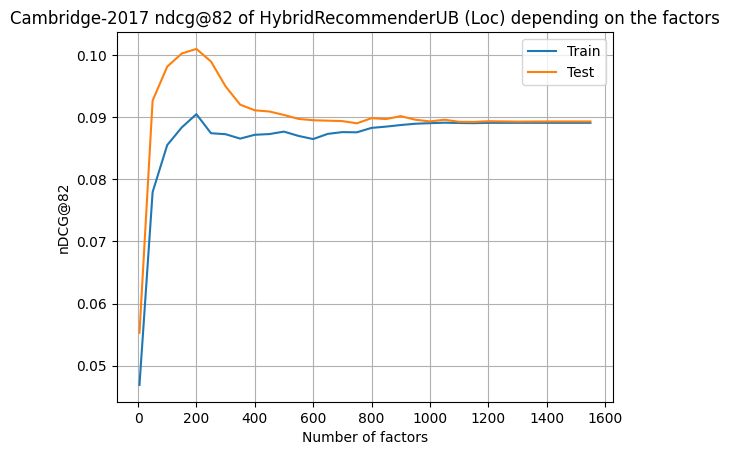

City: Miami, Year: 2014


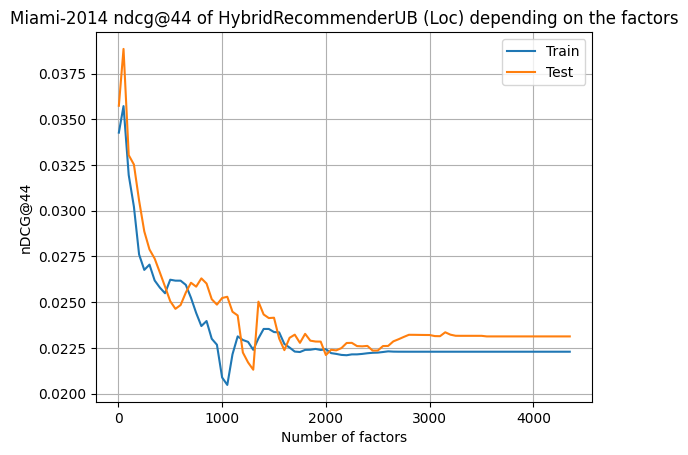

City: Miami, Year: 2015


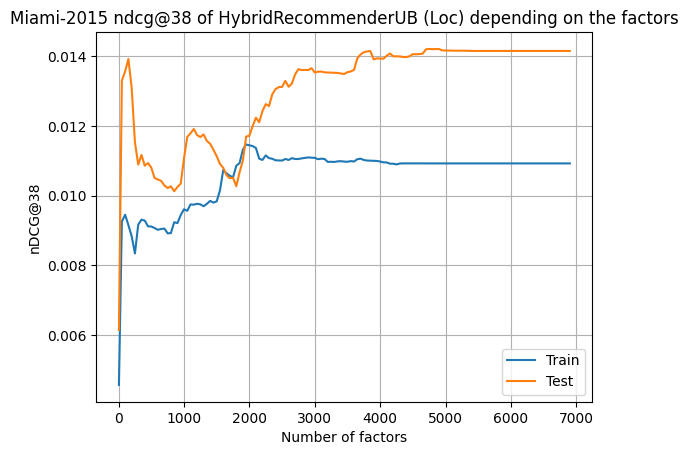

City: Miami, Year: 2016


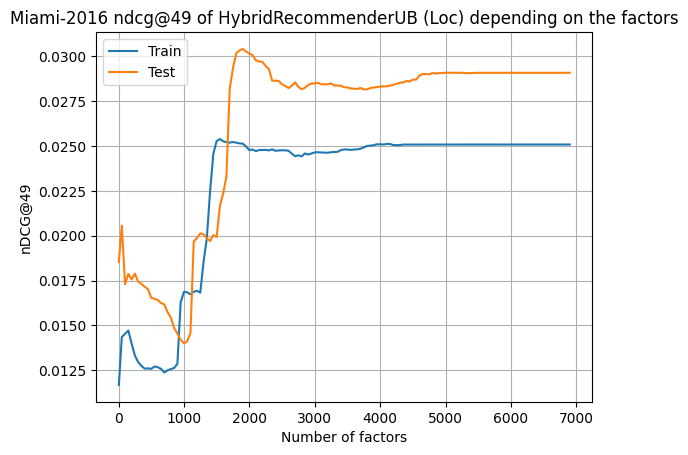

City: Miami, Year: 2017


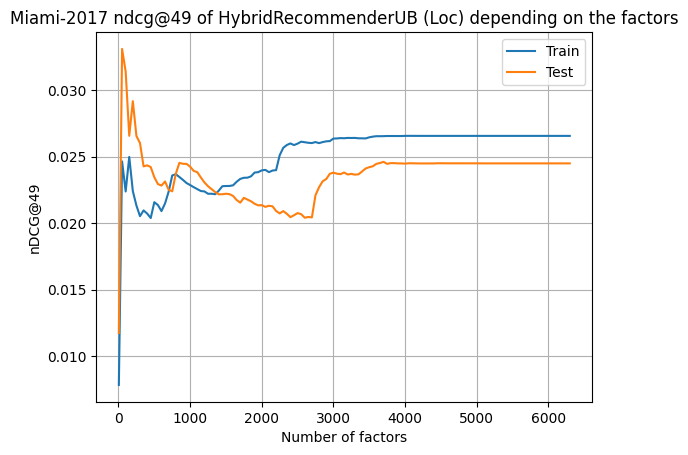

City: New York, Year: 2014


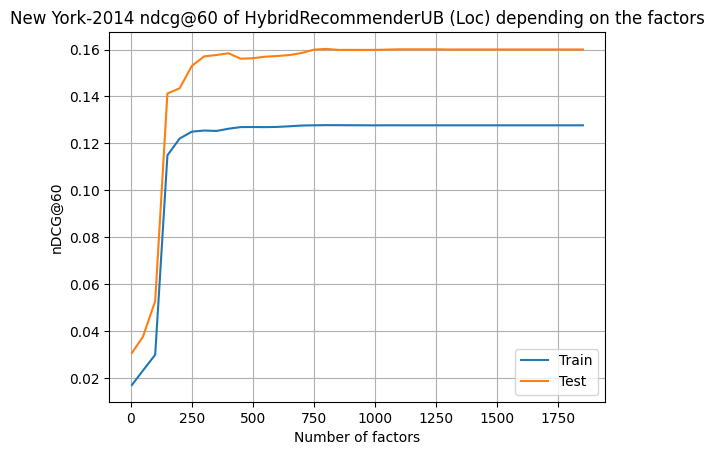

City: New York, Year: 2015


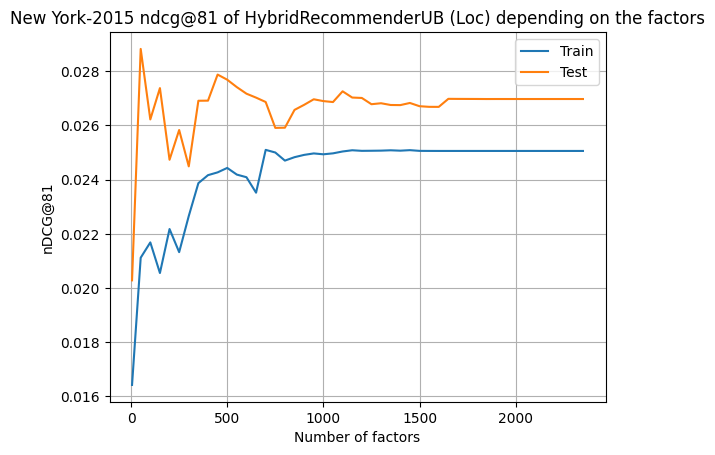

City: New York, Year: 2016


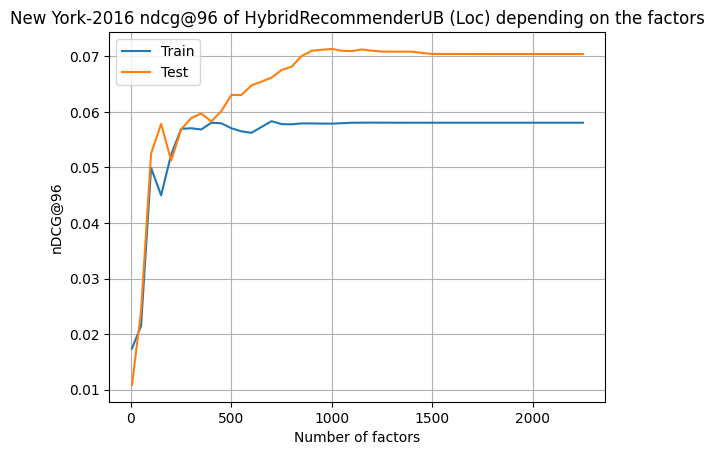

City: New York, Year: 2017


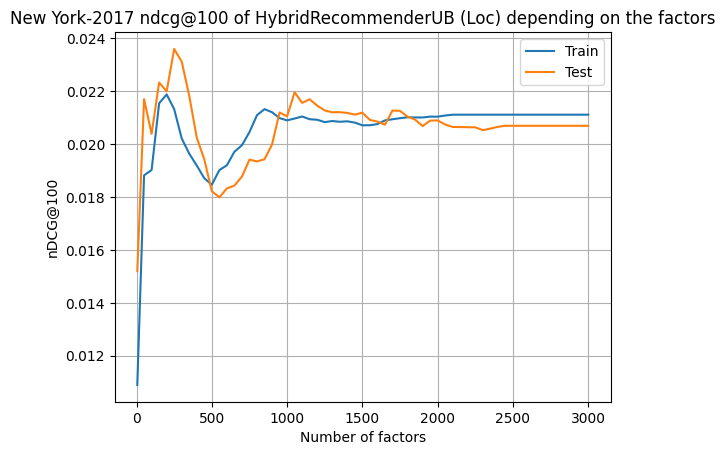

In [12]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        num_users = all_data[build_db_name(city, year)]['rm_info']['rm'].shape[0]
        length = len([k for k in [5] + list(range(50, num_users, 50)) if k < num_users])
        plt.plot(
            [k for k in [5] + list(range(50, num_users, 50)) if k < num_users],
            cbloc_dict_train_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'][0:length]
            )
        plt.plot(
            [k for k in [5] + list(range(50, num_users, 50)) if k < num_users],
            cbloc_dict_test_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}'][0:length]
            )
        plt.xlabel("Number of factors")
        plt.ylabel(f"nDCG@{n_ndcg_dict[city][year]}")
        plt.title(f"{city}-{year} ndcg@{n_ndcg_dict[city][year]} of HybridRecommenderUB (Loc) depending on the factors")
        plt.grid(True)
        plt.legend(["Train", "Test"])
        plt.show()

#### **`K` values for HybridRecommenderUB (Location)**
| City      | Year | Best `K` | Explanation |
|-----------|------|---------|-------------|
| Cambridge | 2014 | 55     | Less difference between train and test, then overfit. |
| Cambridge | 2015 | 100     | Test stabilizes at 100. |
| Cambridge | 2016 | 300     | It remains stable from that point. |
| Cambridge | 2017 | 200     | Highest test score and highest difference. |
| Miami     | 2014 | 200     | After 200, performance starts to decrease. |
| Miami     | 2015 | 4000    | Continue learning until 4000. |
| Miami     | 2016 | 2000    | Stables at 2000. |
| Miami     | 2017 | 200    | Stables at 200. |
| New York  | 2014 | 750     | No significant improvement beyond. |
| New York  | 2015 | 1000     | Best results around 750, then stagnates. |
| New York  | 2016 | 1000     | Gains continue until 1000, then minimal improvement. |
| New York  | 2017 | 1000    | Not best performance observed around 1000 but it remains stable. |

In [ ]:
best_k_values_hybrid_loc = {
    "Cambridge": {
        "2014": 55,
        "2015": 100,
        "2016": 300,
        "2017": 200
    },
    "Miami": {
        "2014": 200,
        "2015": 4000,
        "2016": 2000,
        "2017": 200
    },
    "New York": {
        "2014": 750,
        "2015": 1000,
        "2016": 1000,
        "2017": 1000
    }
}

In [15]:
final_metrics_cbub_loc_results = {}
for city in cities:
    final_metrics_cbub_loc_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        m = HybridRecommenderUB(
            K=best_k_values_hybrid_loc[city][year],
            it_cat_matrix=it_loc_data[db_name]['it_loc_info']['it_loc'],
            tag='category',
        )
        
        m.fit(rm_train)
        
        final_metrics_cbub_loc = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=nf_ndcg_dict[city][year]).mean().to_dict(),
            index=['cbub_loc']
        )
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_cbub_loc.to_csv(f"../../data/final_metrics/{city_year_directory_name}/cbub_loc_final_metrics.csv", sep="|")
        
        final_metrics_cbub_loc_results[city][year] = final_metrics_cbub_loc
        print(f"City: {city}, Year: {year}")
        print(final_metrics_cbub_loc)
        

  0%|          | 0/874 [00:00<?, ?it/s]

IntProgress(value=0, max=319)

HybridRecommenderUB
City: Cambridge, Year: 2014
          precision    recall       map   ndcg@70       auc       mrr  \
cbub_loc   0.012494  0.272107  0.035401  0.097807  0.028705  0.070722   

                f1  
cbub_loc  0.022721  


  0%|          | 0/528 [00:00<?, ?it/s]

IntProgress(value=0, max=200)

HybridRecommenderUB
City: Cambridge, Year: 2015
          precision    recall       map   ndcg@50       auc       mrr  \
cbub_loc     0.0125  0.299163  0.029327  0.092761  0.029827  0.046375   

                f1  
cbub_loc  0.023511  


  0%|          | 0/856 [00:00<?, ?it/s]

IntProgress(value=0, max=290)

HybridRecommenderUB
City: Cambridge, Year: 2016
          precision    recall       map   ndcg@76       auc       mrr  \
cbub_loc    0.00912  0.370624  0.041269  0.114225  0.046508  0.052426   

                f1  
cbub_loc  0.017152  


  0%|          | 0/1575 [00:00<?, ?it/s]

IntProgress(value=0, max=568)

HybridRecommenderUB
City: Cambridge, Year: 2017
          precision    recall       map  ndcg@100       auc       mrr  \
cbub_loc    0.00956  0.313589  0.036571  0.106077  0.035895  0.064231   

                f1  
cbub_loc  0.017965  


  0%|          | 0/4387 [00:00<?, ?it/s]

IntProgress(value=0, max=1060)

HybridRecommenderUB
City: Miami, Year: 2014
          precision    recall       map   ndcg@59       auc       mrr  \
cbub_loc   0.003486  0.099742  0.012686  0.032679  0.010449  0.013921   

                f1  
cbub_loc  0.006616  


  0%|          | 0/6947 [00:00<?, ?it/s]

IntProgress(value=0, max=1535)

HybridRecommenderUB
City: Miami, Year: 2015
          precision    recall       map   ndcg@50       auc       mrr  \
cbub_loc   0.001537  0.056906  0.006081  0.016485  0.005986  0.007095   

                f1  
cbub_loc  0.002967  


  0%|          | 0/6907 [00:00<?, ?it/s]

IntProgress(value=0, max=1595)

HybridRecommenderUB
City: Miami, Year: 2016
          precision    recall       map   ndcg@66       auc       mrr  \
cbub_loc   0.001311  0.057151  0.007647  0.018604  0.007164  0.008596   

                f1  
cbub_loc  0.002518  


  0%|          | 0/6341 [00:00<?, ?it/s]

IntProgress(value=0, max=1464)

HybridRecommenderUB
City: Miami, Year: 2017
          precision    recall     map   ndcg@65       auc      mrr        f1
cbub_loc   0.001587  0.076739  0.0169  0.030131  0.009316  0.01923  0.003053


  0%|          | 0/1861 [00:00<?, ?it/s]

IntProgress(value=0, max=462)

HybridRecommenderUB
City: New York, Year: 2014
          precision    recall       map   ndcg@81       auc       mrr  \
cbub_loc   0.003955  0.270604  0.132563  0.162212  0.045588  0.136751   

                f1  
cbub_loc  0.007751  


  0%|          | 0/2365 [00:00<?, ?it/s]

IntProgress(value=0, max=544)

HybridRecommenderUB
City: New York, Year: 2015
          precision    recall       map  ndcg@100       auc       mrr  \
cbub_loc   0.001838  0.103028  0.009498   0.02862  0.011701  0.011554   

                f1  
cbub_loc  0.003527  


  0%|          | 0/2253 [00:00<?, ?it/s]

IntProgress(value=0, max=608)

HybridRecommenderUB
City: New York, Year: 2016
          precision    recall       map  ndcg@100       auc       mrr       f1
cbub_loc   0.002615  0.190296  0.040449  0.071945  0.021569  0.043915  0.00514


  0%|          | 0/3045 [00:00<?, ?it/s]

IntProgress(value=0, max=776)

HybridRecommenderUB
City: New York, Year: 2017
          precision    recall       map  ndcg@100       auc       mrr  \
cbub_loc   0.001559  0.092785  0.004104  0.021054  0.004548  0.005777   

                f1  
cbub_loc  0.003029  


In [16]:
for city in cities:
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        recs_cbub_loc = gen_recommendations(
            rm_info,
            rm_train,
            rm_test,
            model_name='cbub_loc',
            model=HybridRecommenderUB,
            save=True,
            city=city,
            year=year,
            N=nf_ndcg_dict[city][year],
            params={
                'it_cat_matrix': it_loc_data[db_name]['it_loc_info']['it_loc'],
                'tag': 'category',
                'K': best_k_values_hybrid_loc[city][year]
            },
        )
        

  0%|          | 0/874 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

  0%|          | 0/856 [00:00<?, ?it/s]

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/4387 [00:00<?, ?it/s]

  0%|          | 0/6947 [00:00<?, ?it/s]

  0%|          | 0/6907 [00:00<?, ?it/s]

  0%|          | 0/6341 [00:00<?, ?it/s]

  0%|          | 0/1861 [00:00<?, ?it/s]

  0%|          | 0/2365 [00:00<?, ?it/s]

  0%|          | 0/2253 [00:00<?, ?it/s]

  0%|          | 0/3045 [00:00<?, ?it/s]

## Hybrid Item Based
It combines content-based features and item-based collaborative filtering approaches. Specifically, it computes the similarity between items based on their content attributes, rather than their historical user interactions. Recommendations are generated by identifying items similar in content to those a user has previously liked or interacted with.

Again, the algorithm is divided into three main steps:
1. Build item profiles (Content-Based).
2. Build item similarity.
3. Calculate recommendations score.

Now, we are going to analyze the different steps of the algorithm in detail.
1. Item Profile Vector.
Item profile vectors represent the content-based attributes of items, defined as:
$$
\mathbf{q}_i = (w_{i,1}, w_{i,2}, \dots, w_{i,|T|})
$$
where:
- $w_{i,t}$ is the weight of tag or attribute $t$ for item $i$.

2. Item Similarity.
Similarity between two items $i$ and $j$ is computed using cosine similarity on their content-based profiles $q_i$ and $q_j$:

3. Recommendation Score.
The score for recommending an item $i$ to user $u$ is computed by aggregating similarities of item $i$ with items $j$ previously interacted by user $u$:
$$
\text{score}(u,i) = \frac{\sum_{j \in I_u}\text{sim}(i,j) \cdot r_{u,j}}{\sum_{j \in I_u}|\text{sim}(i,j)|}
$$
where:
- $I_u$ represents the set of items user \( u \) interacted with.
- $r_{u,j}$ represents the interaction (rating or implicit feedback) between user $u$ and item $j$.

### Hybrid Item Based - Categories

In [ ]:
ibcat_dict_metrics_results = {}
ibcat_dict_train_results = {}
ibcat_dict_test_results = {}

for city in cities:
    ibcat_dict_metrics_results[city] = {}
    ibcat_dict_train_results[city] = {}
    ibcat_dict_test_results[city] = {}
    
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        rm_info = all_data[db_name]['rm_info']
        num_users = rm_info['rm'].shape[0]
        print(f"City: {city}, Year: {year}")
        print(f"Number of users: {num_users}")
        model={
            "cbib_cat": {
                'm':HybridRecommenderIB, 
                'params':{
                    'it_cat_matrix': [it_cat_data[db_name]['it_cat_info']['it_cat']],
                    'tag': ['category'],
                    "K": [k for k in list(range(10, 100, 10)) + list(range(100, 201, 20)) if k < num_users],
                    }
                }
            }
        metric_results_ibub_cat, train_results_ibub_cat, test_results_ibub_cat,_ = tunning_and_metrics(
            rm_train,
            rm_test,
            cvk=cvk,
            N=n_ndcg_dict[city][year],
            model=model,
            check_overfitting=True,
            )
        ibcat_dict_metrics_results[city][year] = metric_results_ibub_cat
        ibcat_dict_train_results[city][year] = train_results_ibub_cat
        ibcat_dict_test_results[city][year] = test_results_ibub_cat

City: Cambridge, Year: 2014


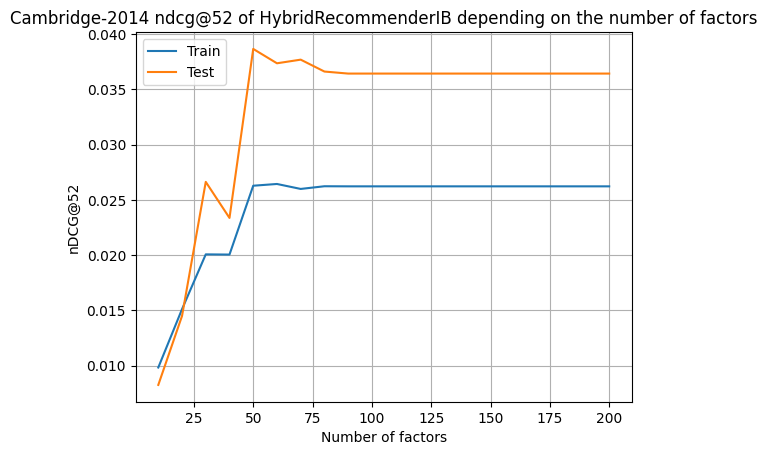

City: Cambridge, Year: 2015


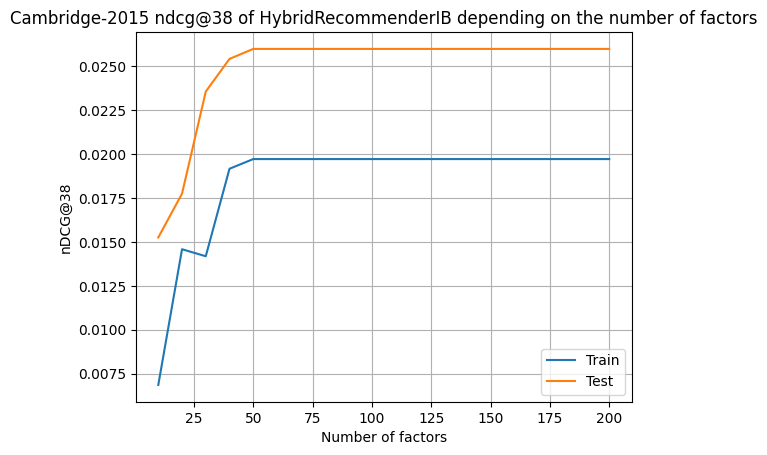

City: Cambridge, Year: 2016


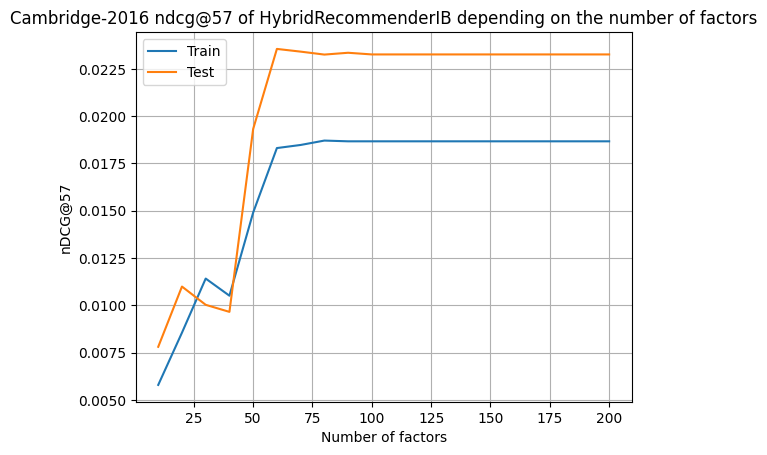

City: Cambridge, Year: 2017


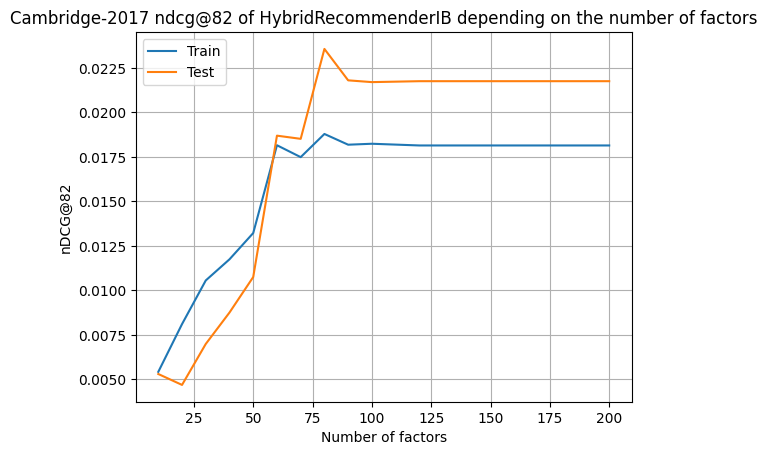

City: Miami, Year: 2014


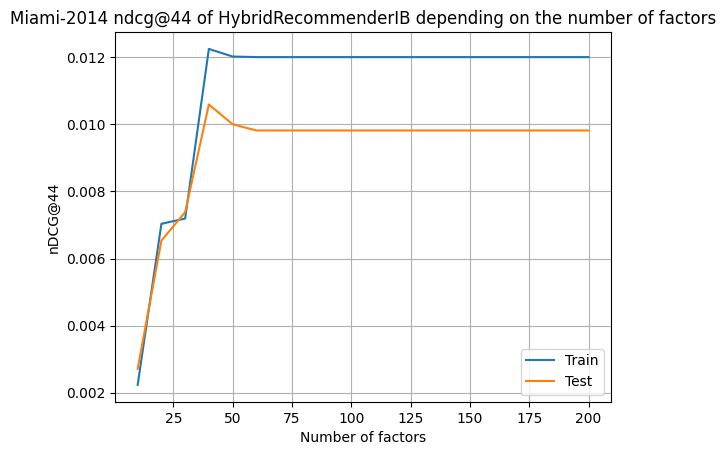

City: Miami, Year: 2015


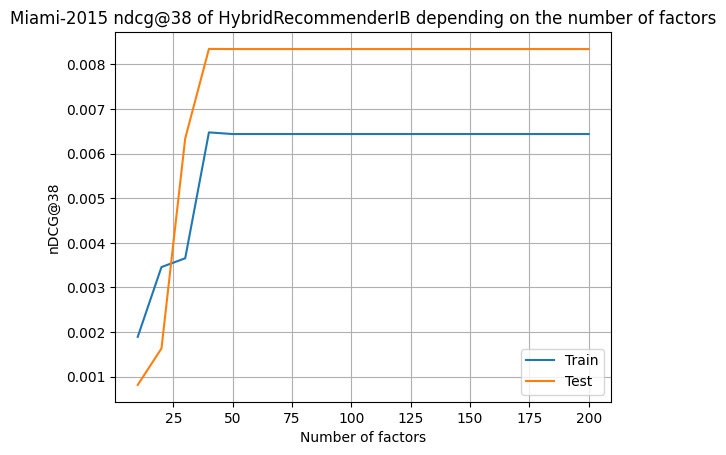

City: Miami, Year: 2016


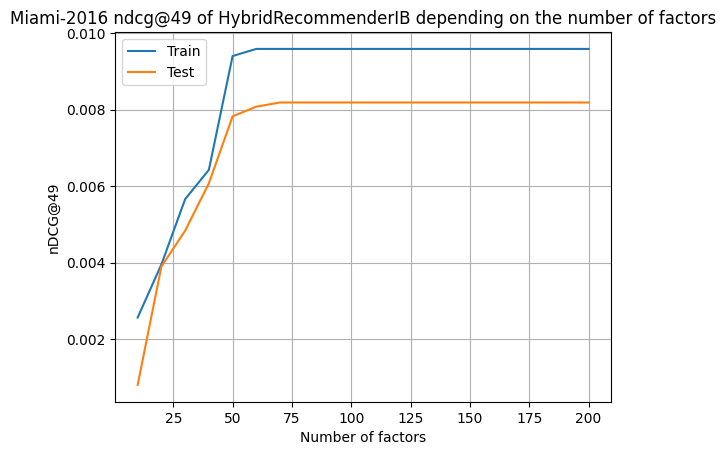

City: Miami, Year: 2017


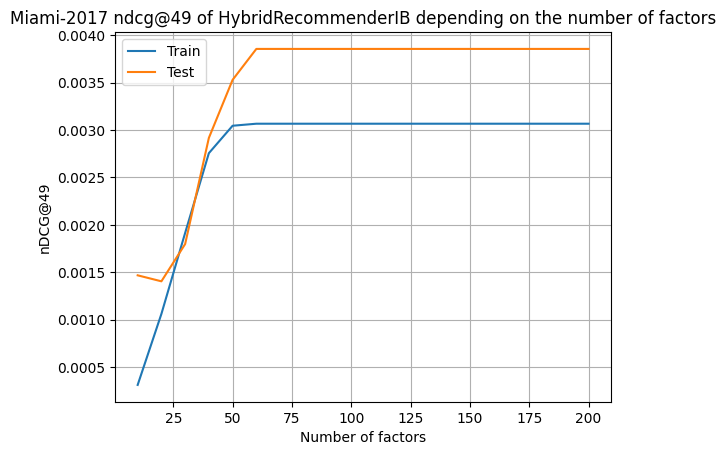

City: New York, Year: 2014


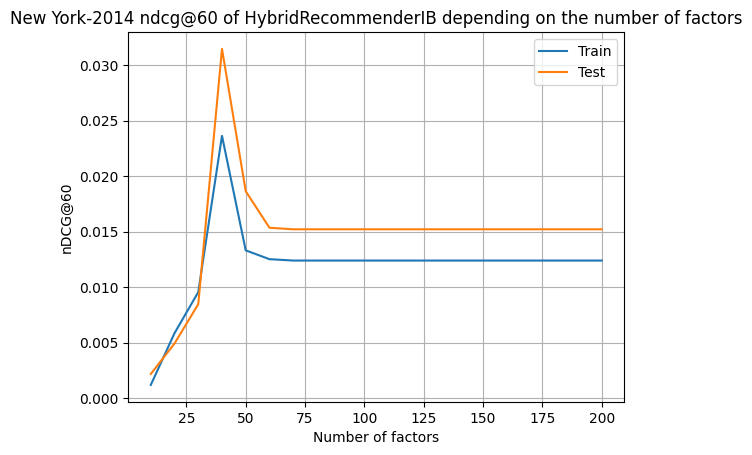

City: New York, Year: 2015


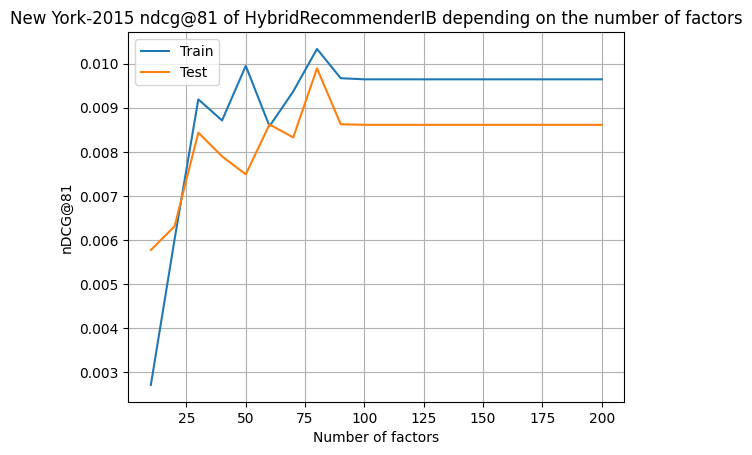

City: New York, Year: 2016


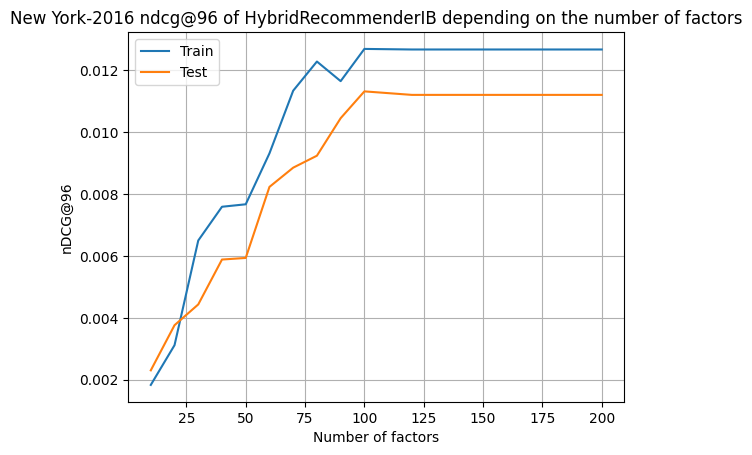

City: New York, Year: 2017


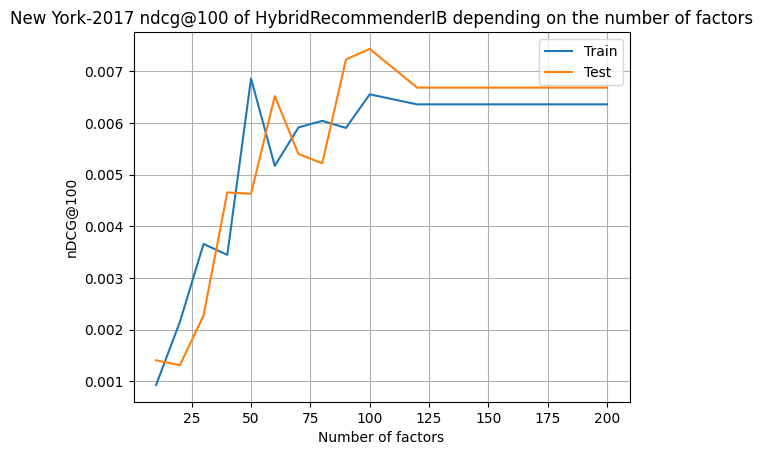

In [18]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        num_users = all_data[build_db_name(city, year)]['rm_info']['rm'].shape[0]

        plt.plot(
            [k for k in list(range(10, 100, 10)) + list(range(100, 201, 20)) if k < num_users],
            ibcat_dict_train_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}']
            )
        plt.plot(
            [k for k in list(range(10, 100, 10)) + list(range(100, 201, 20)) if k < num_users],
            ibcat_dict_test_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}']
            )
        plt.xlabel("Number of factors")
        plt.ylabel(f"nDCG@{n_ndcg_dict[city][year]}")
        plt.title(f"{city}-{year} ndcg@{n_ndcg_dict[city][year]} of HybridRecommenderIB depending on the number of factors")
        plt.grid(True)
        plt.legend(["Train", "Test"])
        plt.show()

#### **`K` values for HybridRecommenderIB**
| City      | Year | Best `K` | Explanation |
|-----------|------|---------|-------------|
| Cambridge | 2014 | 50      | Performance stabilizes around 50, further increase yields minimal gains. |
| Cambridge | 2015 | 50      | Best balance at 50, stable results beyond. |
| Cambridge | 2016 | 60      | Performance gains until 60, then stabilizes. |
| Cambridge | 2017 | 75      | Gains continue until 75, then plateau. |
| Miami     | 2014 | 50      | Optimal performance reached at 50. |
| Miami     | 2015 | 50      | Best results achieved at 50. |
| Miami     | 2016 | 50      | Gains continue until 50, then stabilizes. |
| Miami     | 2017 | 75      | Performance plateaus at 75. |
| New York  | 2014 | 50      | Best trade-off at 50, further increase doesn't improve results. |
| New York  | 2015 | 75      | Best results at 75, minor gains beyond. |
| New York  | 2016 | 100     | Optimal results observed at 100, then stagnates. |
| New York  | 2017 | 100     | Gains continue until ~100, then performance stabilizes. |

In [19]:
best_k_values_hybrid_ib = {
    "Cambridge": {
        "2014": 50,
        "2015": 50,
        "2016": 60,
        "2017": 75,
    },
    "Miami": {
        "2014": 50,
        "2015": 50,
        "2016": 50,
        "2017": 75,
    },
    "New York": {
        "2014": 50,
        "2015": 75,
        "2016": 100,
        "2017": 100,
    }
}


In [21]:
final_metrics_ibub_results = {}
for city in cities:
    final_metrics_ibub_results[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        m = HybridRecommenderIB(
            K=best_k_values_hybrid_ib[city][year],
            it_cat_matrix=it_cat_data[db_name]['it_cat_info']['it_cat'],
            tag='category',
        )
        
        m.fit(rm_train)
        
        final_metrics_ibub = pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=nf_ndcg_dict[city][year]).mean().to_dict(),
            index=['cbib_cat']
        )
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_ibub.to_csv(f"../../data/final_metrics/{city_year_directory_name}/cbib_cat_final_metrics.csv", sep="|")
        final_metrics_ibub_results[city][year] = final_metrics_ibub
        
        print(f"City: {city}, Year: {year}")
        print(final_metrics_ibub)
        

  0%|          | 0/348 [00:00<?, ?it/s]

IntProgress(value=0, max=319)

HybridRecommenderIB
City: Cambridge, Year: 2014
          precision    recall       map  ndcg@70       auc       mrr        f1
cbib_cat   0.005195  0.106083  0.016971  0.04243  0.013513  0.035332  0.009077


  0%|          | 0/252 [00:00<?, ?it/s]

IntProgress(value=0, max=200)

HybridRecommenderIB
City: Cambridge, Year: 2015
          precision    recall       map   ndcg@50       auc       mrr  \
cbib_cat     0.0048  0.110798  0.010578  0.035953  0.011654  0.022822   

                f1  
cbib_cat  0.009025  


  0%|          | 0/378 [00:00<?, ?it/s]

IntProgress(value=0, max=290)

HybridRecommenderIB
City: Cambridge, Year: 2016
          precision    recall       map   ndcg@76       auc       mrr  \
cbib_cat    0.00245  0.069374  0.013114  0.027186  0.008232  0.019809   

                f1  
cbib_cat  0.004163  


  0%|          | 0/550 [00:00<?, ?it/s]

IntProgress(value=0, max=568)

HybridRecommenderIB
City: Cambridge, Year: 2017
          precision    recall       map  ndcg@100       auc       mrr  \
cbib_cat   0.002007  0.056073  0.007204  0.021084  0.006515  0.018002   

                f1  
cbib_cat  0.003675  


  0%|          | 0/294 [00:00<?, ?it/s]

IntProgress(value=0, max=1060)

HybridRecommenderIB
City: Miami, Year: 2014
          precision    recall       map   ndcg@59       auc       mrr  \
cbib_cat   0.001119  0.029326  0.005006  0.011856  0.003794  0.009815   

                f1  
cbib_cat  0.002122  


  0%|          | 0/251 [00:00<?, ?it/s]

IntProgress(value=0, max=1535)

HybridRecommenderIB
City: Miami, Year: 2015
          precision    recall       map   ndcg@50       auc       mrr  \
cbib_cat    0.00073  0.027416  0.003775  0.009203  0.003722  0.005077   

                f1  
cbib_cat  0.001413  


  0%|          | 0/328 [00:00<?, ?it/s]

IntProgress(value=0, max=1595)

HybridRecommenderIB
City: Miami, Year: 2016
          precision    recall       map   ndcg@66       auc       mrr  \
cbib_cat   0.000636  0.028608  0.003458  0.008698  0.002877  0.004374   

                f1  
cbib_cat  0.001228  


  0%|          | 0/327 [00:00<?, ?it/s]

IntProgress(value=0, max=1464)

HybridRecommenderIB
City: Miami, Year: 2017
          precision    recall       map   ndcg@65       auc       mrr  \
cbib_cat   0.000399  0.017657  0.001511  0.004932  0.002083  0.002528   

                f1  
cbib_cat  0.000755  


  0%|          | 0/403 [00:00<?, ?it/s]

IntProgress(value=0, max=462)

HybridRecommenderIB
City: New York, Year: 2014
          precision    recall       map   ndcg@81       auc       mrr  \
cbib_cat   0.001042  0.059163  0.010205  0.020299  0.006716  0.010184   

                f1  
cbib_cat  0.002033  


  0%|          | 0/542 [00:00<?, ?it/s]

IntProgress(value=0, max=544)

HybridRecommenderIB
City: New York, Year: 2015
          precision    recall       map  ndcg@100       auc       mrr  \
cbib_cat   0.000846  0.032684  0.003433   0.00997  0.002546  0.004107   

                f1  
cbib_cat  0.001601  


  0%|          | 0/643 [00:00<?, ?it/s]

IntProgress(value=0, max=608)

HybridRecommenderIB
City: New York, Year: 2016
          precision    recall       map  ndcg@100       auc       mrr  \
cbib_cat   0.000757  0.045121  0.002199  0.010816  0.003817  0.003834   

                f1  
cbib_cat  0.001476  


  0%|          | 0/1005 [00:00<?, ?it/s]

IntProgress(value=0, max=776)

HybridRecommenderIB
City: New York, Year: 2017
          precision    recall      map  ndcg@100       auc       mrr        f1
cbib_cat   0.000438  0.028203  0.00248  0.007435  0.001539  0.002842  0.000856


In [23]:
for city in cities:
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        recs_ibub_cat = gen_recommendations(
            rm_info,
            rm_train,
            rm_test,
            model_name='cbib_cat',
            model=HybridRecommenderIB,
            save=True,
            city=city,
            year=year,
            N=nf_ndcg_dict[city][year],
            params={
                'it_cat_matrix': it_cat_data[db_name]['it_cat_info']['it_cat'],
                'tag': 'category',
                'K': best_k_values_hybrid_ib[city][year]
            },
        )
        

  0%|          | 0/348 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/542 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

### Hybrid Item Based - Location


In [ ]:
ibloc_dict_metrics_results = {}
ibloc_dict_train_results = {}
ibloc_dict_test_results = {}

for city in cities:
    ibloc_dict_metrics_results[city] = {}
    ibloc_dict_train_results[city] = {}
    ibloc_dict_test_results[city] = {}
    
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        rm_train = sps.csr_matrix(rm_train.astype(np.float32))
        rm_test = sps.csr_matrix(rm_test.astype(np.float32))
        
        rm_info = all_data[db_name]['rm_info']
        num_users = rm_info['rm'].shape[0]
        print(f"City: {city}, Year: {year}")
        print(f"Number of users: {num_users}")
        model={
            "cbib_loc": {
                'm':HybridRecommenderIB, 
                'params':{
                    'it_cat_matrix': [it_loc_data[db_name]['it_loc_info']['it_loc']],
                    'tag': ['category'],
                    "K": [k for k in list(range(10, 100, 10)) + list(range(100, 201, 20)) if k < num_users],
                    }
                }
            }
        metric_results_ibub_loc, train_results_ibub_loc, test_results_ibub_loc,_ = tunning_and_metrics(
            rm_train,
            rm_test,
            cvk=cvk,
            N=n_ndcg_dict[city][year],
            model=model,
            check_overfitting=True,
            )
        ibloc_dict_metrics_results[city][year] = metric_results_ibub_loc
        ibloc_dict_train_results[city][year] = train_results_ibub_loc
        ibloc_dict_test_results[city][year] = test_results_ibub_loc

City: Cambridge, Year: 2014


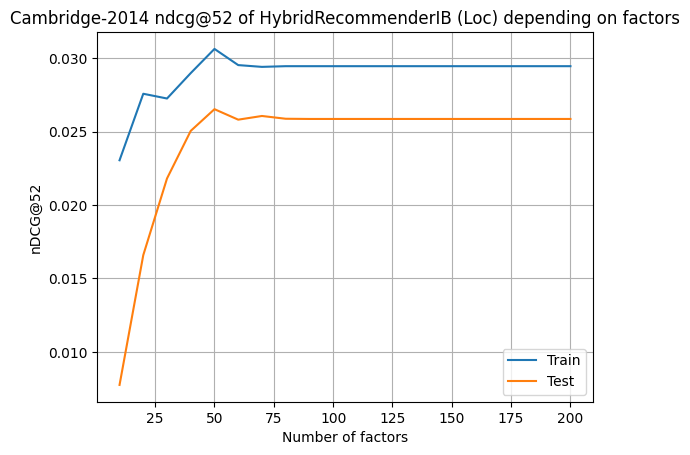

City: Cambridge, Year: 2015


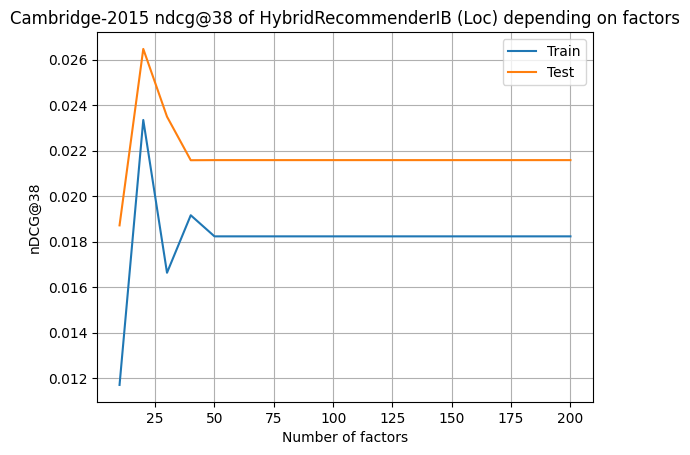

City: Cambridge, Year: 2016


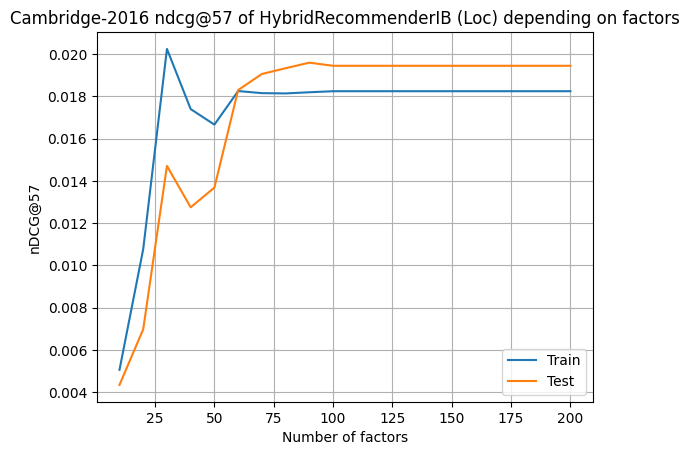

City: Cambridge, Year: 2017


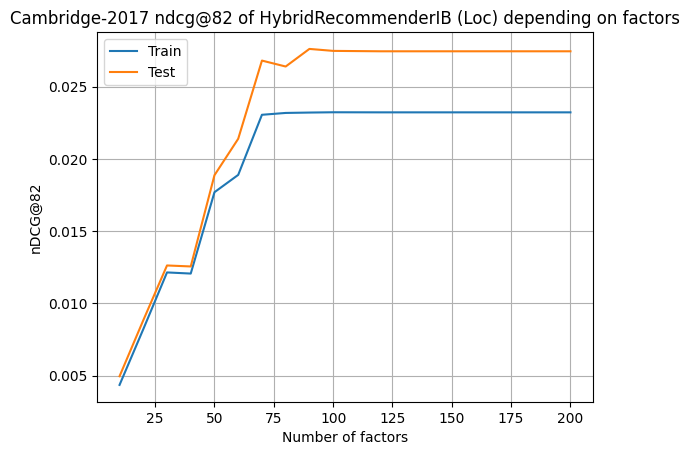

City: Miami, Year: 2014


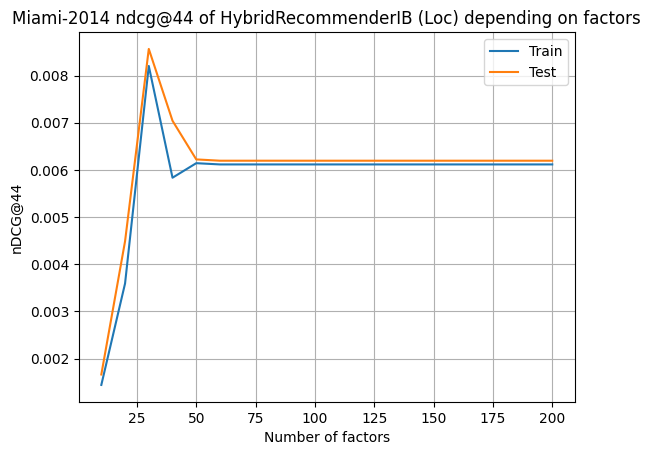

City: Miami, Year: 2015


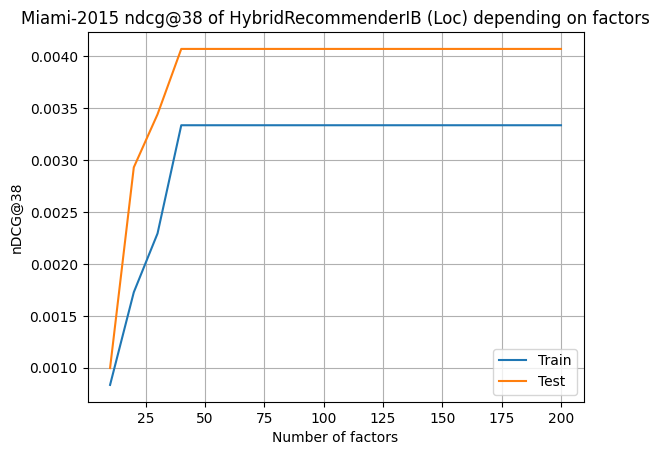

City: Miami, Year: 2016


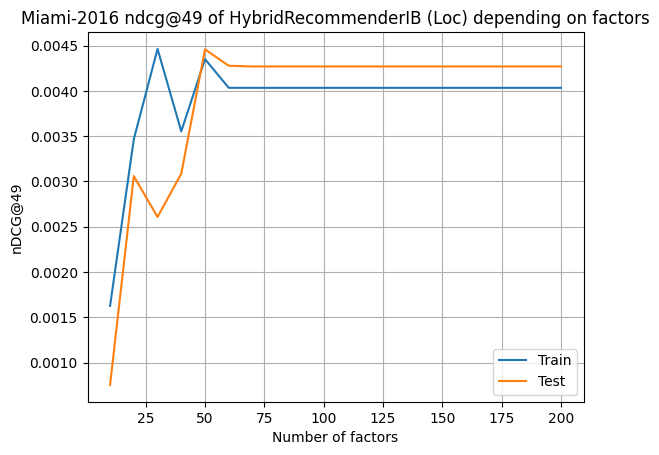

City: Miami, Year: 2017


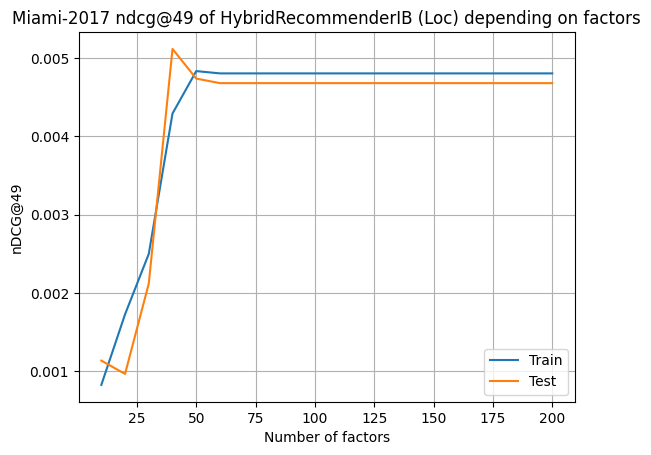

City: New York, Year: 2014


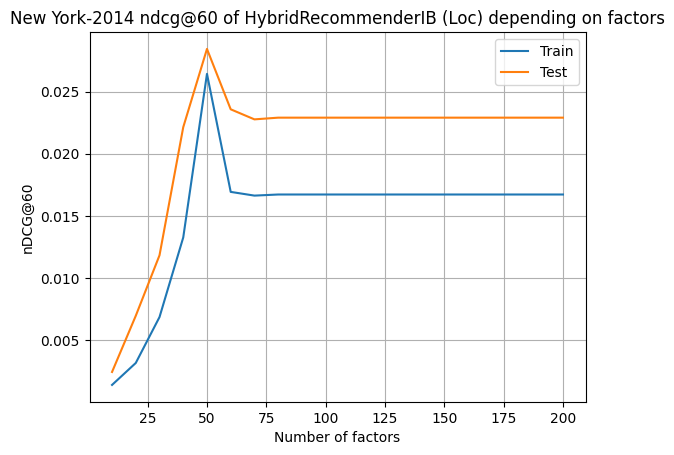

City: New York, Year: 2015


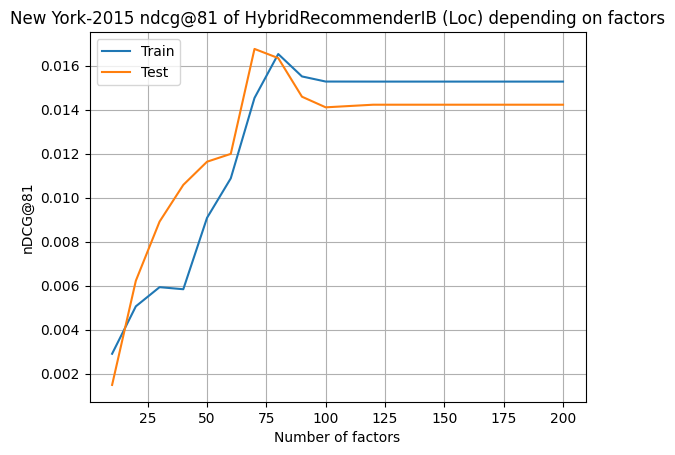

City: New York, Year: 2016


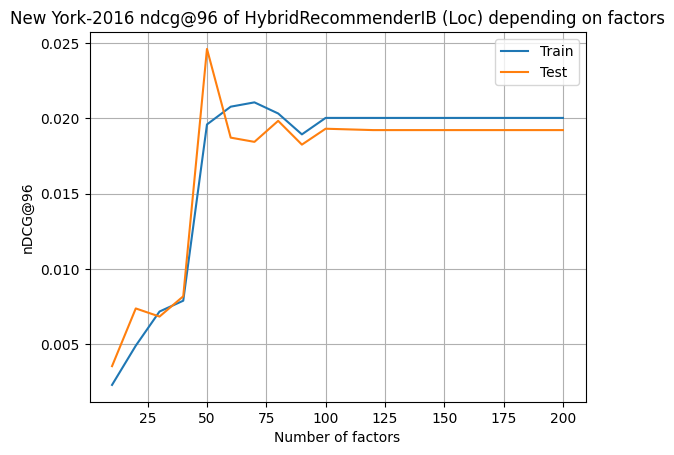

City: New York, Year: 2017


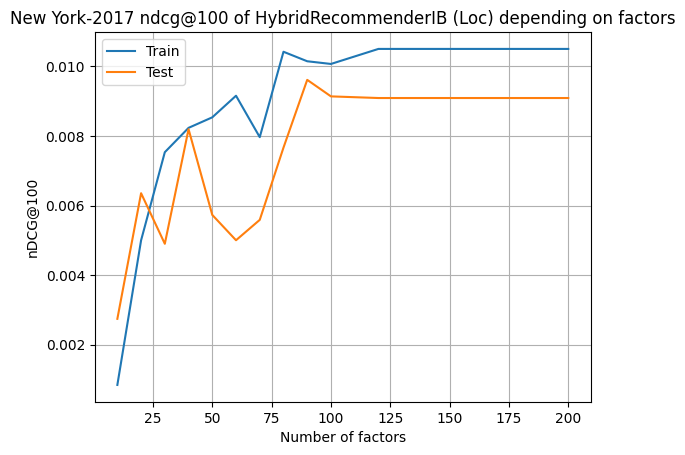

In [10]:
for city in cities:
    for year in years:
        print(f"City: {city}, Year: {year}")
        num_users = all_data[build_db_name(city, year)]['rm_info']['rm'].shape[0]

        plt.plot(
            [k for k in list(range(10, 100, 10)) + list(range(100, 201, 20)) if k < num_users],
            ibloc_dict_train_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}']
            )
        plt.plot(
            [k for k in list(range(10, 100, 10)) + list(range(100, 201, 20)) if k < num_users],
            ibloc_dict_test_results[city][year][f'ndcg@{n_ndcg_dict[city][year]}']
            )
        plt.xlabel("Number of factors")
        plt.ylabel(f"nDCG@{n_ndcg_dict[city][year]}")
        plt.title(f"{city}-{year} ndcg@{n_ndcg_dict[city][year]} of HybridRecommenderIB (Loc) depending on factors")
        plt.grid(True)
        plt.legend(["Train", "Test"])
        plt.show()

#### **`K` values for HybridRecommenderIB (Location)**
| City      | Year | Best `K` | Explanation |
|-----------|------|---------|-------------|
| Cambridge | 2014 | 50      | Performance stabilizes around 50, further increase yields minimal gains. |
| Cambridge | 2015 | 25      | Best balance at 50, stable results beyond. |
| Cambridge | 2016 | 80      | Performance gains until 60, then stabilizes. |
| Cambridge | 2017 | 80      | Gains continue until 85, then plateau. |
| Miami     | 2014 | 30      | Stabilizes at 30. |
| Miami     | 2015 | 40      | Plateau from 40. |
| Miami     | 2016 | 50      | Gains continue until 50, then stabilizes. |
| Miami     | 2017 | 40      | Performance plateaus at 40. |
| New York  | 2014 | 50      | Best trade-off at 50, further increase doesn't improve results. |
| New York  | 2015 | 75      | Peak at 75 without overfitting. |
| New York  | 2016 | 50     | Optimal results observed at 50, then overfitting. |
| New York  | 2017 | 80     | Gains continue until then stabilizes. |

In [13]:
best_k_values_hybrid_ib_loc = {
    "Cambridge": {
        "2014": 50,
        "2015": 25,
        "2016": 80,
        "2017": 80,
    },
    "Miami": {
        "2014": 30,
        "2015": 40,
        "2016": 50,
        "2017": 40,
    },
    "New York": {
        "2014": 50,
        "2015": 75,
        "2016": 50,
        "2017": 80,
    }
}


In [14]:
final_metrics_ibub_results_loc = {}
for city in cities:
    final_metrics_ibub_results_loc[city] = {}
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        m = HybridRecommenderUB(
            K=best_k_values_hybrid_ib_loc[city][year],
            it_cat_matrix=it_loc_data[db_name]['it_loc_info']['it_loc'],
            tag='category',
        )
        
        m.fit(rm_train)
        
        final_metrics_ibub_loc= pd.DataFrame(
            data=ranking_metrics_at_k(m, rm_train, rm_test, K=nf_ndcg_dict[city][year]).mean().to_dict(),
            index=['cbib_loc']
        )
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        final_metrics_ibub_loc.to_csv(f"../../data/final_metrics/{city_year_directory_name}/cbib_loc_final_metrics.csv", sep="|")
        final_metrics_ibub_results_loc[city][year] = final_metrics_ibub_loc
        
        print(f"City: {city}, Year: {year}")
        print(final_metrics_ibub_loc)
        

  0%|          | 0/874 [00:00<?, ?it/s]

IntProgress(value=0, max=319)

HybridRecommenderUB
City: Cambridge, Year: 2014
          precision    recall       map   ndcg@70       auc       mrr  \
cbib_loc   0.012808  0.284614  0.036384  0.101307  0.029158  0.074054   

                f1  
cbib_loc  0.023319  


  0%|          | 0/528 [00:00<?, ?it/s]

IntProgress(value=0, max=200)

HybridRecommenderUB
City: Cambridge, Year: 2015
          precision    recall       map   ndcg@50       auc       mrr  \
cbib_loc     0.0094  0.186351  0.026072  0.069199  0.018511  0.048253   

                f1  
cbib_loc  0.017543  


  0%|          | 0/856 [00:00<?, ?it/s]

IntProgress(value=0, max=290)

HybridRecommenderUB
City: Cambridge, Year: 2016
          precision    recall       map   ndcg@76       auc       mrr  \
cbib_loc   0.007804  0.292815  0.042216  0.098844  0.032175  0.056192   

                f1  
cbib_loc  0.014542  


  0%|          | 0/1575 [00:00<?, ?it/s]

IntProgress(value=0, max=568)

HybridRecommenderUB
City: Cambridge, Year: 2017
          precision    recall       map  ndcg@100       auc       mrr  \
cbib_loc   0.009032  0.270679  0.039472  0.101262  0.030139  0.068299   

                f1  
cbib_loc  0.016923  


  0%|          | 0/4387 [00:00<?, ?it/s]

IntProgress(value=0, max=1060)

HybridRecommenderUB
City: Miami, Year: 2014
          precision    recall       map   ndcg@59       auc       mrr  \
cbib_loc   0.002942  0.079757  0.031484  0.044004  0.007322  0.034625   

                f1  
cbib_loc  0.005567  


  0%|          | 0/6947 [00:00<?, ?it/s]

IntProgress(value=0, max=1535)

HybridRecommenderUB
City: Miami, Year: 2015
          precision    recall       map   ndcg@50       auc       mrr  \
cbib_loc    0.00073  0.027275  0.009403  0.013648  0.002641  0.011344   

                f1  
cbib_loc  0.001409  


  0%|          | 0/6907 [00:00<?, ?it/s]

IntProgress(value=0, max=1595)

HybridRecommenderUB
City: Miami, Year: 2016
          precision    recall       map   ndcg@66       auc       mrr  \
cbib_loc   0.001073  0.042791  0.014116  0.021149  0.005134  0.016089   

                f1  
cbib_loc  0.002043  


  0%|          | 0/6341 [00:00<?, ?it/s]

IntProgress(value=0, max=1464)

HybridRecommenderUB
City: Miami, Year: 2017
          precision   recall       map   ndcg@65       auc       mrr        f1
cbib_loc   0.001251  0.05496  0.027937  0.034206  0.006288  0.029298  0.002391


  0%|          | 0/1861 [00:00<?, ?it/s]

IntProgress(value=0, max=462)

HybridRecommenderUB
City: New York, Year: 2014
          precision    recall       map   ndcg@81       auc       mrr  \
cbib_loc   0.001309  0.074997  0.026518  0.038297  0.006011  0.030831   

                f1  
cbib_loc  0.002544  


  0%|          | 0/2365 [00:00<?, ?it/s]

IntProgress(value=0, max=544)

HybridRecommenderUB
City: New York, Year: 2015
          precision   recall       map  ndcg@100       auc       mrr        f1
cbib_loc   0.001838  0.07099  0.016417   0.02962  0.006705  0.020236  0.003424


  0%|          | 0/2253 [00:00<?, ?it/s]

IntProgress(value=0, max=608)

HybridRecommenderUB
City: New York, Year: 2016
          precision    recall       map  ndcg@100       auc       mrr  \
cbib_loc   0.001086  0.062089  0.012823  0.024148  0.005957  0.014567   

                f1  
cbib_loc  0.002117  


  0%|          | 0/3045 [00:00<?, ?it/s]

IntProgress(value=0, max=776)

HybridRecommenderUB
City: New York, Year: 2017
          precision    recall       map  ndcg@100       auc       mrr  \
cbib_loc   0.001572  0.079149  0.005914  0.021525  0.003789  0.008759   

                f1  
cbib_loc  0.003043  


In [24]:
for city in cities:
    for year in years:
        db_name = build_db_name(city, year)
        rm_train = all_data[db_name]['rm_train']
        rm_test = all_data[db_name]['rm_test']
        
        recs_ibub_loc = gen_recommendations(
            rm_info,
            rm_train,
            rm_test,
            model_name='cbib_loc',
            model=HybridRecommenderIB,
            save=True,
            city=city,
            year=year,
            N=nf_ndcg_dict[city][year],
            params={
                'it_cat_matrix': it_loc_data[db_name]['it_loc_info']['it_loc'],
                'tag': 'category',
                'K': best_k_values_hybrid_ib_loc[city][year]
            },
        )
        

  0%|          | 0/348 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/542 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

# Final Metrics

In [5]:
import re
cities = ['Cambridge', 'Miami', 'New York']
years = ['2014', '2015', '2016', '2017']
algorithms = ['rand','pop','pop_nc','ib','ub','mf','cb_cat','cb_loc','cbub_cat','cbub_loc','cbib_cat','cbib_loc']
final_metrics_styled_dict = {}
for city in cities:
    final_metrics_styled_dict[city] = {}
    for year in years:
        city_list_df = []
        city_directory_name = build_directory_city_name(city)
        city_year_directory_name = f"{city_directory_name}/{year}"
        for alg in algorithms:
            dataframe = pd.read_csv(f"../../data/final_metrics/{city_year_directory_name}/{alg}_final_metrics.csv", sep="|")
            ndcg_col = next(col for col in dataframe.columns if re.match(r'ndcg@\d+', col))
            dataframe.rename(columns={'precision':'Precision',
                                      'recall':'Recall',
                                      'map':'MAP',
                                      ndcg_col:'nDCG',
                                      'mrr':'MRR',
                                      'f1':'F1'},
                             inplace=True)
            dataframe.drop(columns=['auc'], inplace=True)
            city_list_df.append(dataframe)
    
        final_metrics_df = pd.concat(city_list_df)
        final_metrics_df.rename(columns={'Unnamed: 0':'Algorithm'}, inplace=True)
        final_metrics_df.set_index('Algorithm', inplace=True)
        final_metrics_df.to_csv(f"../../data/final_metrics/{city_year_directory_name}/final_metrics.csv", sep="|")
        final_metrics_styled_dict[city][year] = final_metrics_df.style.background_gradient().format('{:.3f}')
        print(f"City: {city}, Year: {year}")
        display(final_metrics_styled_dict[city][year])
        final_metrics_styled_dict[city][year].to_html(f"../../data/final_metrics/{city_year_directory_name}/final_metrics.html")
        
        
             

City: Cambridge, Year: 2014


City: Cambridge, Year: 2015


City: Cambridge, Year: 2016


City: Cambridge, Year: 2017


City: Miami, Year: 2014


City: Miami, Year: 2015


City: Miami, Year: 2016


City: Miami, Year: 2017


City: New York, Year: 2014


City: New York, Year: 2015


City: New York, Year: 2016


City: New York, Year: 2017
